# **Advanced Lane Finding** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

## Introduction

The steps of this project are the following:  

1. [Camera Calibration](#cameracalibration)  Compute the camera calibration matrix and distortion coefficients given a set of chessboard images
2. [Distortion Correction](#distortioncorrection) Apply the distortion correction to the raw image
3. [Color/Gradient Threshold](#colorgradientthershold) Generate a binary image where the lane lines are clearly visible
4. [Perspective Transform](#perspectivetransform) Apply a perspective transform to rectify binary image ("birds-eye view")
5. [Detecting Lane Lines](#detectinglanelines) Detect lane pixels and fit to find lane boundary
6. [Determining Lane Curvature](#determininglanecurvature) Determine curvature of the lane and vehicle position with respect to center
7. [Warping Lane Boundaries](#warpingboundaries) Warp the detected lane boundaries back onto the original image
8. [Test on Videos](#testonvideos) Test on videos based on the above step-by-step procedure

---
### User-defined Classes
* **Line** : The class of a lane line
* **ImgProcess** : The class of processing an image

### Dataset

* **camera_cal** : The images for camera calibration
* **test_images** : The images for testing the pipeline on single frames
* **project_video.mp4** : The video used for the pipeline
* **challenge_video.mp4** : The video used for an extra (and optional) challenge if we want to test our pipeline

### Line and Image Classes

We create two classes: Line and ImgProcess. The Line class mainly has x and y coordinates of a line, a fitted function, and its update. The ImgProcess class has all the functions of processing images for Color Gradient Threshold, Perspective Transform, Hough lines, and so on.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
import numpy as np
import cv2
import glob
from Line import Line
#from ImgProcess import ImgProcess
from Camera import Camera
#from Lane import Lane

### <a name="cameracalibration"></a>1. Camera Calibration

We compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

Inputs: 
1. object points (3D image), 
2. image points (4 points in the orginal image), 
3. grayscale image

Outputs: 
1. camera matrix to transfrom 3D image points to 2D image points (mtx)
2. distortion coefficients (dist)
3. rotation vectors (rvecs)
4. translation vectors (tvecs)

Procedure:
1. Converting an image, imported by cv2 or the glob API, to grayscale using cv2.COLOR_RGB2GRAY for mpimg.imread() or cv2.COLOR_BGR2GRAY for cv2.imread()
2. Finding chessboard corners (for an 8x6 board)
3. Drawing detected corners on an image
4. Camera calibration, given **object points**, **image points**, and the shape of the grayscale image
5. Undistorting a test image

Please refer to `0_camera_calibration.ipynb` provided separately. As a result from the execution of it, the following values are stored. Then, we simply load and use it.

* mtx: camera matrix to transfrom 3D image points to 2D image points
* dist: distortion coefficients

In [2]:
dump_frames = False
test_images = False
test_video1 = True
lane_debug_mode = True
lane_show_plots = False

In [3]:
camera = Camera(debug_mode = False, show_plots =False)
camera.calibrate('calibration_wide/GO*.jpg')

mtx and dist loaded


True

### <a name="distortioncorrection"></a>2. Distortion Correction
Apply the distortion correction to the raw image. 

Inputs: 
1. camera matrix (mtx)
2. distortion coefficients (dist)
3. image

Outputs:
1. undistorted image

Procedure:

cv.undistort

Undistorting test images...
Processing image test_images/test1.jpg
Processing image test_images/test2.jpg
Processing image test_images/test3.jpg
Processing image test_images/test4.jpg
Processing image test_images/test5.jpg
Processing image test_images/test6.jpg


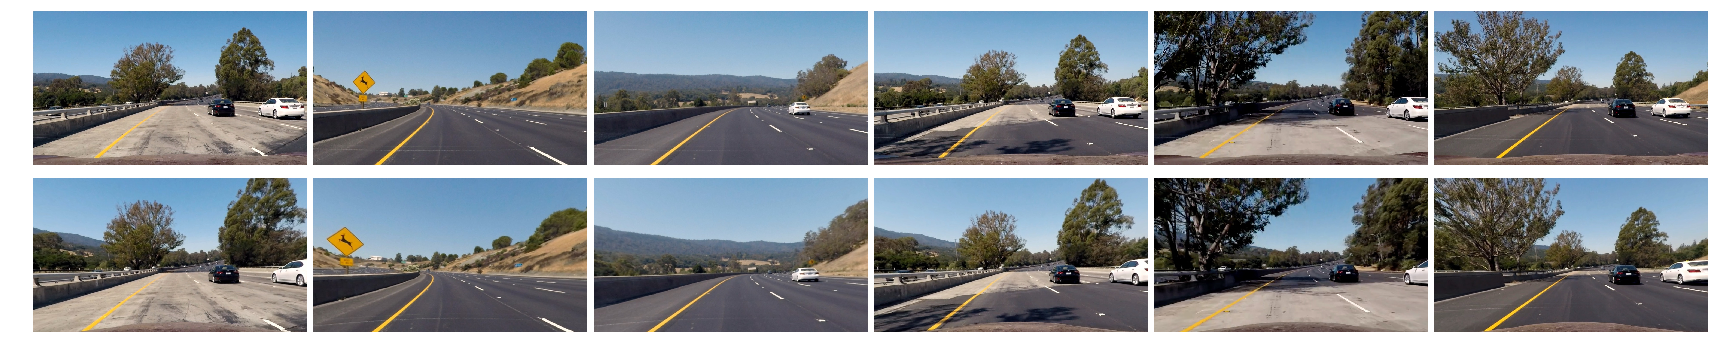

In [4]:
images = glob.glob("test_images/test*.jpg")
org_imgs = []
undist_imgs = []
images.sort()
print("Undistorting test images...")
# Setup the plot grid for test images
plt.figure(figsize = (30,6))
gs1 = gridspec.GridSpec(2,len(images))
gs1.update(wspace=0.025, hspace=0.05)
for i, fname in enumerate(images):
    # Define our lane object
    #lane = Lane(debug_mode=lane_debug_mode, show_plots= lane_show_plots)
    print("Processing image {}".format(fname))
    # Next, let's read in a test image
    img = mpimg.imread(fname)
    # Process the image using our pipeline
    undist = camera.undistort(img)
    undist_imgs.append(undist)
    org_imgs.append(img)
    #combined_img = process_image(img)
    # Plot the original image and the processed images
    ax1 = plt.subplot(gs1[i])
    plt.axis('off')
    ax1.imshow(img)
    ax2 = plt.subplot(gs1[i+6])
    plt.axis('off')
    ax2.imshow(undist)
plt.show()

### <a name="colorgradientthreshold"></a>3. Color/Gradient Threshold

We want to try out various combinations of color and gradient thresholds to generate a binary image where the lane lines are clearly visible.

Inputs:
* image

Outputs:
* image

Procedure:
1. Convert to HLS color space and separate the S channel. Note: img is the undistorted image
2. Grayscale image. NOTE: we already saw that standard grayscaling lost color information for the lane lines
3. Sobel x
4. Threshold x gradient
5. Threshold color channel

Edge-detecting on undistorted images...


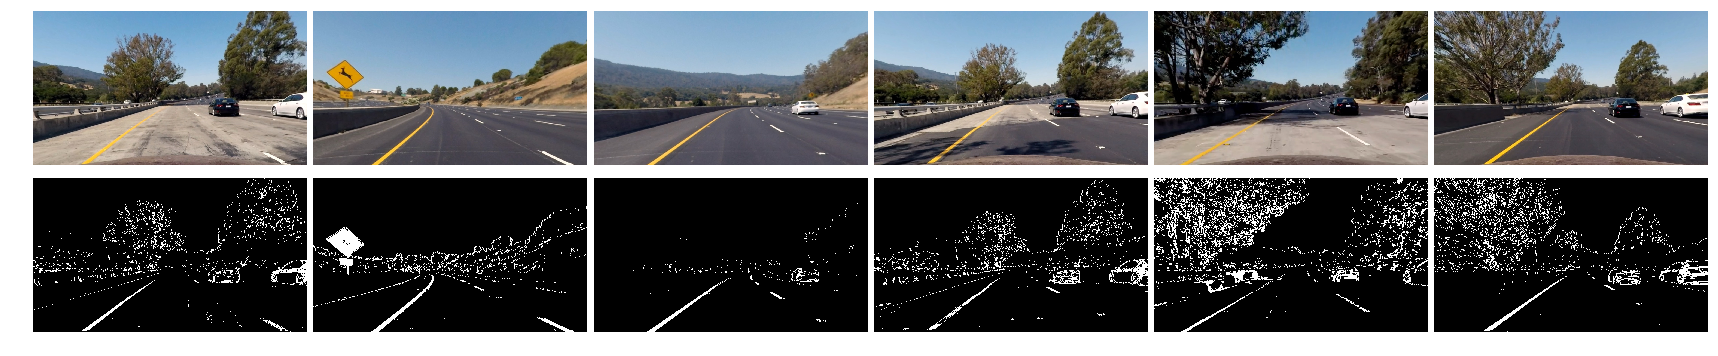

In [5]:
bin_imgs = []
print("Edge-detecting on undistorted images...")
#images.sort()
# Setup the plot grid for test images
plt.figure(figsize = (30,6))
gs1 = gridspec.GridSpec(2,len(undist_imgs))
gs1.update(wspace=0.025, hspace=0.05)
for i, img in enumerate(undist_imgs):
    # Define our lane object
    binary_img = camera.colorGradientThreshold(img)
    bin_imgs.append(binary_img)
    # Plot the original image and the processed images
    ax1 = plt.subplot(gs1[i])
    plt.axis('off')
    ax1.imshow(img)
    ax2 = plt.subplot(gs1[i+6])
    plt.axis('off')
    ax2.imshow(binary_img, cmap='gray')
plt.show()

There's more than one way to achieve a good result, but for example, given the image above, this is our output we go for:

### <a name="perspectivetransform"></a>4. Perspective Transform
Next, we want to identify four source points for your perspective transform. In this case, you can assume the road is a flat plane. This isn't strictly true, but it can serve as an approximation for this project. We would like to pick four points in a trapezoidal shape (similar to region masking) that would represent a rectangle when looking down on the road from above.
Use color transforms, gradients, etc., to create a thresholded binary image.

Those same four source points will now work to transform any image (again, under the assumption that the road is flat and the camera perspective hasn't changed). When applying the transform to new images, the test of whether or not we got the transform correct, is that the lane lines should appear parallel in the warped images, whether they are straight or curved.

Inputs:
* four points of the source (corners)
* combined_binary image

Outputs:
* warped image

Procedure:
1. find the left and right lines: get_hough_lines
2. extract four points on the lines: trapezoidpoints_fit2
3. transform to warped image: warpPerspective

Perspective-transforming on binary images...


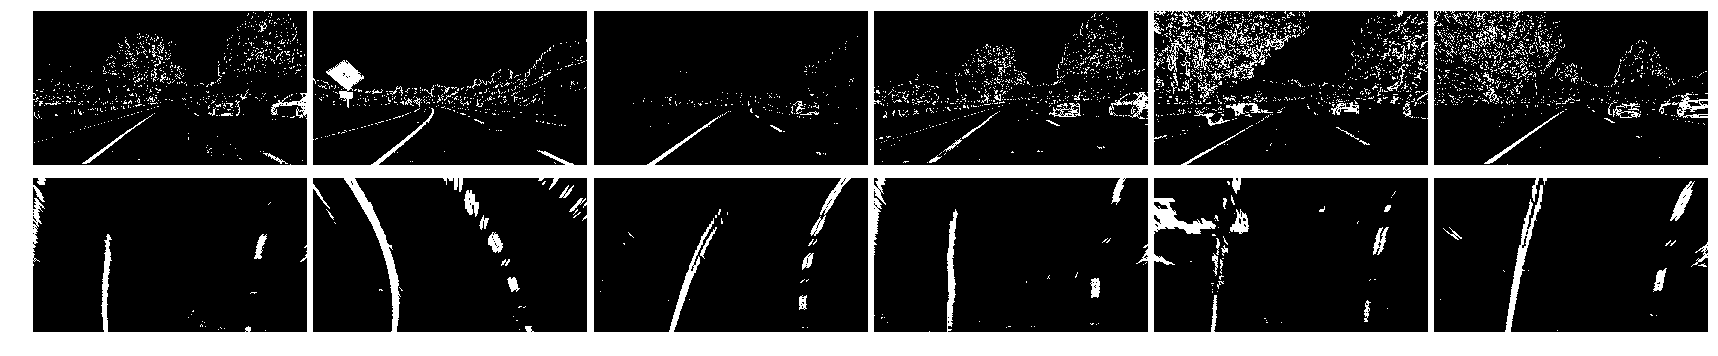

In [8]:
print("Perspective-transforming on binary images...")
# Setup the plot grid for test images
warped_imgs = []
plt.figure(figsize = (30,6))
gs1 = gridspec.GridSpec(2,len(bin_imgs))
gs1.update(wspace=0.025, hspace=0.05)
for i, img in enumerate(bin_imgs):
    # Define our lane object
    warped_img = camera.warpPerspective(img)
    warped_imgs.append(warped_img)
    #combined_img = process_image(img)
    # Plot the original image and the processed images
    ax1 = plt.subplot(gs1[i])
    plt.axis('off')
    ax1.imshow(img, cmap='gray')
    ax2 = plt.subplot(gs1[i+6])
    plt.axis('off')
    ax2.imshow(warped_img, cmap='gray')
plt.show()

### Overlay warped images

I overlay the current and previous warped images in order to increase the chane of finding the lane lines. The following images show how it works. The original images are displayed in the first row, while the overlayed images in the second. As can be seen, the overlayed image has more solid lines.

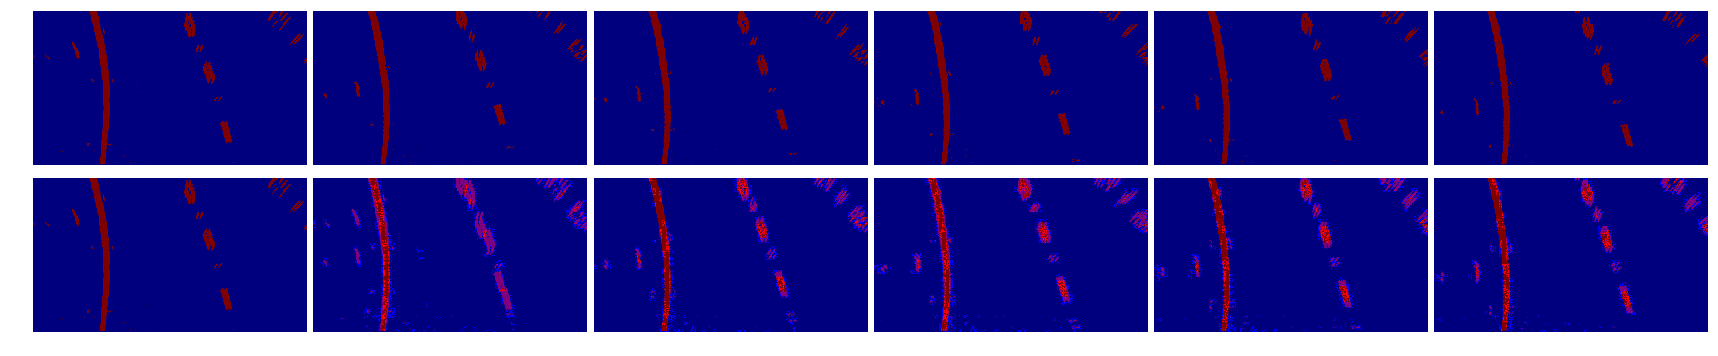

In [100]:
images = glob.glob("video_frames/frame*_persp.jpg")
images.sort()
ov_imgs = []
# Image overlayed
# Setup the plot grid for test images
plt.figure(figsize = (30,6))
gs1 = gridspec.GridSpec(2,6)
gs1.update(wspace=0.025, hspace=0.05)
for i, fname in enumerate(images):
    img = mpimg.imread(fname)
    if not i:
        comb = np.copy(img)
    else:
        comb = img | prev_img 
        #print(comb)
    ov_imgs.append(comb)
    ax1 = plt.subplot(gs1[i])
    plt.axis('off')
    ax1.imshow(img, cmap='gray')
    ax2 = plt.subplot(gs1[i+6])
    plt.axis('off')
    ax2.imshow(comb, cmap='gray')
    prev_img =img
    if i >= 5:
        break
plt.show()

Here's an example of applying a perspective transform to our thresholded binary image, using the same source and destination points as above, showing that the curved lines are (more or less) parallel in the transformed image:

### <a name="detectinglanelines"></a>5. Detecting Lane Lines

After applying calibration, thresholding, and a perspective transform to a road image, you should have a binary image where the lane lines stand out clearly. However, you still need to decide explicitly which pixels are part of the lines and which belong to the left line and which belong to the right line.

I first take a histogram along all the columns in the lower half of the image. In our thresholded binary image, pixels are either 0 or 1, so the two most prominent peaks in this histogram will be good indicators of the x-position of the base of the lane lines. We can use that as a starting point for where to search for the lines. From that point, we can use a sliding window, placed around the line centers, to find and follow the lines up to the top of the frame.

Inputs:
* warped image
* number of slides

Outputs:
* marked image that represents the lane

Procedure:
1. get highest histogram values given the areas of the warped
2. slide a window on the warped
3. repeat 1 and 2

Histogram on test images...
358 24 679
341 66 552
106 115 556
349 95 679
225 88 711
190 97 671


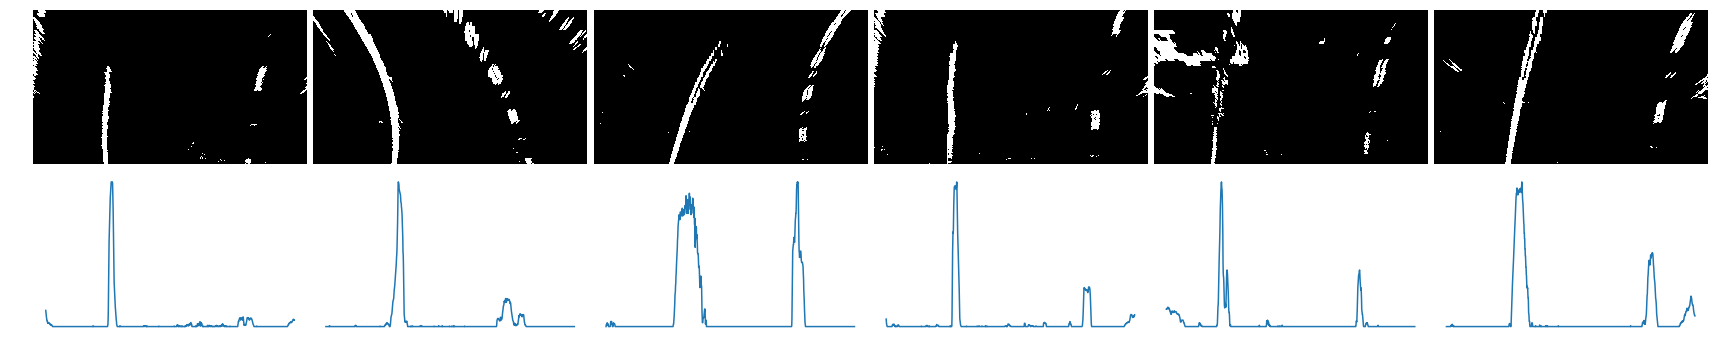

In [348]:
histos = []
print("Histogram on test images...")
# Setup the plot grid for test images
plt.figure(figsize = (30,6))
gs1 = gridspec.GridSpec(2,len(warped_imgs))
gs1.update(wspace=0.025, hspace=0.05)
for i, img in enumerate(warped_imgs):
    #a histogram along all the columns in the lower half of the image
    histo = np.sum(img[img.shape[0]//2:,:], axis=0)
    histos.append(histo)
    midpoint = int(img.shape[1]/2)
    lindx = np.argmax(histo[:midpoint])
    rindx = np.argmax(histo[midpoint:]) + midpoint
    print(histo[lindx], histo[rindx], rindx - lindx)
    #combined_img = process_image(img)
    # Plot the original image and the processed images
    ax1 = plt.subplot(gs1[i])
    plt.axis('off')
    ax1.imshow(img, cmap='gray')
    ax2 = plt.subplot(gs1[i+6])
    plt.axis('off')
    ax2.plot(histo)
plt.show()

In [335]:
midpoint = img.shape[1]//2
linx= np.argmax(histo[midpoint:])
print(histo[linx])
rinx= np.argmax(histo[:midpoint])+midpoint
print(histo[rinx])

43
14


In [11]:
def slidingWindow(binary_warped, margin=100):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    #out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        #cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        #(0,255,0), 2) 
        #cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        #(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    return left_lane_inds, right_lane_inds

In [12]:
def getPolyfit(binary_warped, left_lane_inds, right_lane_inds):
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    return left_fit, right_fit

In [65]:
def updatePolyfit(binary_warped, margin, left_fit, right_fit):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_lane_inds, right_lane_inds, left_fit, right_fit

Sliding-window applied on warped images...


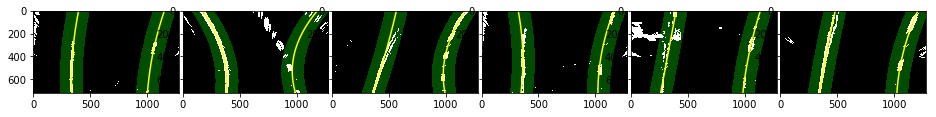

In [63]:
print("Sliding-window applied on warped images...")
# Setup the plot grid for test images
plt.figure(figsize = (16,18))
gs1 = gridspec.GridSpec(1,len(bin_warped_imgs))
gs1.update(wspace=0.025, hspace=0.05)
fit_results = []
left_fit = []
right_fit = []
left_curverad = 0
right_curverad = 0
margin = 100
for i, img in enumerate(warped_imgs):    
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    if i == 0:
        left_inds, right_inds = slidingWindow(img, margin)
        left_fit, right_fit = getPolyfit(img, left_inds, right_inds)
    else:
        left_fit, right_fit = updatePolyfit(img, margin, left_fit, right_fit)
        
    # Generate x and y values for plotting
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Identify the x and y positions of all nonzero pixels in the image
    #nonzero = img.nonzero()
    #nonzeroy = np.array(nonzero[0])
    #nonzerox = np.array(nonzero[1])        
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((img, img, img))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    #out_img[nonzeroy[left_inds], nonzerox[left_inds]] = [255, 0, 0]
    #out_img[nonzeroy[right_inds], nonzerox[right_inds]] = [0, 0, 255]
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
    
    # Plot the original image and the processed images
    #ax1 = plt.subplot(gs1[i,i])
    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    ax1 = plt.subplot(gs1[i])
    ax1.imshow(result)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    
    fit_results.append([ploty, left_fitx, right_fitx])
    
plt.show()

## Alternative to sliding window search
Another way to approach the sliding window method is to apply a convolution, which will maximize the number of "hot" pixels in each window. A convolution is the summation of the product of two separate signals, in our case the window template and the vertical slice of the pixel image.

You slide your window template across the image from left to right and any overlapping values are summed together, creating the convolved signal. The peak of the convolved signal is where there was the highest overlap of pixels and the most likely position for the lane marker.

Now let's try using convolutions to find the best window center positions in a thresholded road image. The code below allows you to experiment with using convolutions for a sliding window search function. Go ahead and give it a try.

In [256]:
# window settings
window_width = 50 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching
#warped = bin_warped_imgs[0]
def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),
           max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(warped, window_width=50, window_height=80, margin=100):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum 
    # to get the vertical image slice and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    l_delta, r_delta = 0, 0
    print(r_center)
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(warped.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Use window_width/2 as offset because convolution signal reference is 
        # at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
        l_temp = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        ndot = len(conv_signal[l_min_index:l_max_index].nonzero()[0])
        if ndot > 50: # detected?
            if abs(l_temp - l_center) > 60:
                l_center += l_delta
            else:
                l_delta = int((l_temp - l_center + l_delta)/2)
                l_center = l_temp
            #print(ndot, l_temp, l_delta)
        elif l_delta > 0:
            l_center += l_delta
        #print(ndot, l_temp, l_center, l_delta)
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
        r_temp = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        ndot = len(conv_signal[r_min_index:r_max_index].nonzero()[0])
        if ndot > 50: # detected?
            if abs(r_temp - r_center) > 60:
                r_center += r_delta
            else:
                r_delta = int((r_temp - r_center + r_delta)/2)
                r_center = r_temp
        elif r_delta > 0:
            r_center += r_delta
        #print(ndot, r_temp, r_center, r_delta)
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids

Convolution applied on warped images...
1012.0
998.0
975.0
1028.0
990.0
1022.0


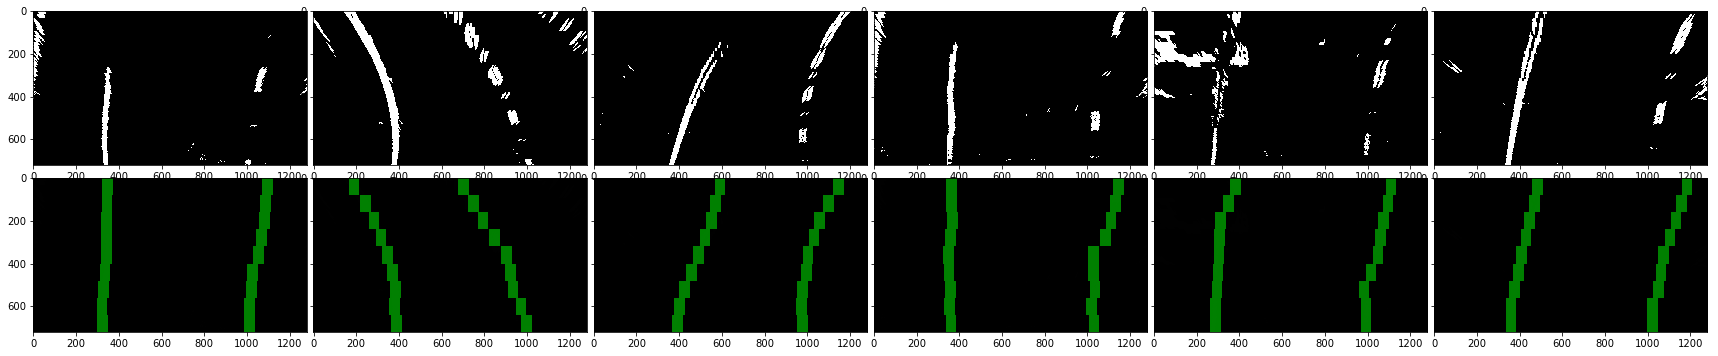

In [258]:
print("Convolution applied on warped images...")
# Setup the plot grid for test images
plt.figure(figsize = (30,6))
gs1 = gridspec.GridSpec(2,len(warped_imgs))
gs1.update(wspace=0.025, hspace=0.05)
fit_results = []
left_fit = []
right_fit = []
left_curverad = 0
right_curverad = 0
margin = 100
for i, img in enumerate(warped_imgs):    
    window_centroids = find_window_centroids(img, window_width, window_height, margin)
    #print(window_centroids)
    # If we found any window centers
    if len(window_centroids) > 0:

        # Points used to draw all the left and right windows
        l_points = np.zeros_like(img)
        r_points = np.zeros_like(img)

        # Go through each level and draw the windows 	
        for level in range(0,len(window_centroids)):
            # Window_mask is a function to draw window areas
            l_mask = window_mask(window_width,window_height,img,window_centroids[level][0],level)
            r_mask = window_mask(window_width,window_height,img,window_centroids[level][1],level)
            # Add graphic points from window mask here to total pixels found 
            l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
            r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

        # Draw the results
        template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
        zero_channel = np.zeros_like(template) # create a zero color channle 
        template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
        warpage = np.array(cv2.merge((img,img,img)),np.uint8) # making the original road pixels 3 color channels
        output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results

    # If no window centers found, just display orginal road image
    else:
        output = np.array(cv2.merge((img,img,img)),np.uint8)
        
    # Display the final results
    ax1 = plt.subplot(gs1[i])
    ax1.imshow(img, cmap='gray')
    ax2 = plt.subplot(gs1[i+6])
    ax2.imshow(output)
    
    
    #ax1 = plt.subplot(gs1[i])
    #plt.imshow(output)
    #plt.title('window fitting results')
plt.show()

### <a name="determininglanecurvature"></a>6. Determining Lane Curvature
Determine curvature of the lane and vehicle position with respect to center.

Inputs:
* lines fit (left_fit, right_fit)

Outputs:
* radius of curvature

The radius of curvature ([awesome tutorial here](https://www.intmath.com/applications-differentiation/8-radius-curvature.php)) at any point x of the function x=f(y) = Ay^2 + By +C is given as follows:

Rcurve = [1+f'(y)^2]^(3/2) / f''(y)

Rcurve = (1+(2Ay+B)^2)^(3/2) / 2A

The y values of your image increase from top to bottom, so if, for example, you wanted to measure the radius of curvature closest to your vehicle, you could evaluate the formula above at the y value corresponding to the bottom of your image, or in Python, at yvalue = image.shape[0].

An insightful student has suggested an alternative approach which may scale more efficiently. That is, once the parabola coefficients are obtained, in pixels, convert them into meters. For example, if the parabola is x= a(y^2) +by+c; and mx and my are the scale for the x and y axis, respectively (in meters/pixel); then the scaled parabola is x= mx / (my ^ 2)a(y^2)+(mx/my)by+c

In [18]:
def calculateCurverad(ploty, left_fit, right_fit):
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    return left_curverad, right_curverad

But now we need to stop and think... We've calculated the radius of curvature based on pixel values, so the radius we are reporting is in pixel space, which is not the same as real world space. So we actually need to repeat this calculation after converting our x and y values to real world space.

This involves measuring how long and wide the section of lane is that we're projecting in our warped image. We could do this in detail by measuring out the physical lane in the field of view of the camera, but for this project, you can assume that if you're projecting a section of lane similar to the images above, the lane is about 30 meters long and 3.7 meters wide. Or, if you prefer to derive a conversion from pixel space to world space in your own images, compare your images with U.S. regulations that require a minimum lane width of 12 feet or 3.7 meters, and the dashed lane lines are 10 feet or 3 meters long each.

So here's a way to repeat the calculation of radius of curvature after correcting for scale in x and y:

In [27]:
def calculateCurvemit(ploty, left_fitx, right_fitx):
    y_eval = np.max(ploty)
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    # Example values: 632.1 m    626.2 m
    return left_curverad, right_curverad

Check out the [U.S. government specifications for highway curvature](http://onlinemanuals.txdot.gov/txdotmanuals/rdw/horizontal_alignment.htm#BGBHGEGC) to see how your numbers compare. There's no need to worry about absolute accuracy in this case, but your results should be "order of magnitude" correct.

### <a name="warpingboundaries"></a>7. Warping Lane Boundaries
Warp the detected lane boundaries back onto the original image.

Unwarp warped images...


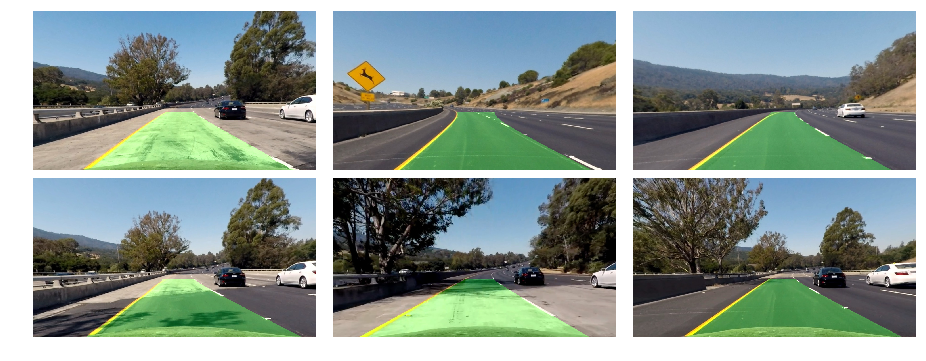

In [64]:
org = org_imgs
undist = undist_imgs
warped = warped_imgs
#fit_results
print("Unwarp warped images...")
# Setup the plot grid for test images
plt.figure(figsize = ((16,6)))
gs1 = gridspec.GridSpec(2,int(len(warped)/2))
gs1.update(wspace=0.025, hspace=0.05)
for i, vals in enumerate(fit_results):
    ploty, left_fitx, right_fitx = vals
    newwarp = camera.unwarpPerspective(org[i], warped[i], ploty, left_fitx, right_fitx)
    # Combine the result with the original image
    result = cv2.addWeighted(undist[i], 1, newwarp, 0.3, 0)
    
    ax1 = plt.subplot(gs1[i])
    plt.axis('off')
    ax1.imshow(result)
#plt.show()

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

### Do your curvature values make sense?

We're not expecting anything like perfection for this project, but a good check on whether or not your perspective transform worked as expected, your conversion from pixel space to world space was correct, and that you successfully calculated the radius of curvature is whether or not your results are roughly consistent with reality.

Here is an image from Google maps of where the project video was made (just northwest of the Udacity office!). Here, I've drawn a circle to coincide with the first left curve in the project video. This is a very rough estimate, but as you can see, the radius of that circle is approximately 1 km. You don't need to tune your algorithm to report exactly a radius of 1 km in the project, but if you're reporting 10 km or 0.1 km, you know there might be something wrong with your calculations!

[img](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/2b62a1c3-e151-4a0e-b6b6-e424fa46ceab/lessons/40ec78ee-fb7c-4b53-94a8-028c5c60b858/concepts/7ee45090-7366-424b-885b-e5d38210958f#)

### Offset
You can assume the camera is mounted at the center of the car, such that the lane center is the midpoint at the bottom of the image between the two lines you've detected. The offset of the lane center from the center of the image (converted from pixels to meters) is your distance from the center of the lane.

In [66]:
def getOffset(ploty, left_fit, right_fit, center):
    lanewidth = 700
    y_val = np.max(ploty)
    leftx_val = left_fit[0]*y_val**2 + left_fit[1]*y_val + left_fit[2]
    rightx_val = right_fit[0]*y_val**2 + right_fit[1]*y_val + right_fit[2]
    deviation = int((rightx_val + leftx_val)/2) - center
    offset = 3.7 * deviation /lanewidth
    return offset

### Tracking
After you've tuned your pipeline on test images, you'll run on a video stream, just like in the first project. In this case, however, you're going to keep track of things like where your last several detections of the lane lines were and what the curvature was, so you can properly treat new detections. To do this, it's useful to define a Line() class to keep track of all the interesting parameters you measure from frame to frame. Here's an example:

In [610]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self, margin):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None   
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  #drawing
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None 
        #y values for detected line pixels
        self.ally = None 
        # x base for sliding window for the last detected line
        self.xbase = None
        # margin
        self.margin = margin
        # n fits
        self.n = 5
        
    def calculateCurverad(self, ploty):
        fit = self.current_fit#self.best_fit
        y = np.max(ploty)
        self.radius_of_curvature = ((1+(2*fit[0]*y + fit[1])**2)**1.5)/np.absolute(2*fit[0])

        return self.radius_of_curvature
    
    def calculateCurvemit(self, ploty):
        fit = self.current_fit#self.bestx
        fitx = fit[0]*ploty**2 + fit[1]*ploty + fit[2]
        y_eval = np.max(ploty)
        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meters per pixel in x dimension

        # Fit new polynomials to x,y in world space
        fit_cr = np.polyfit(ploty*ym_per_pix, fitx*xm_per_pix, 2)
        # Calculate the new radii of curvature
        curvemit = ((1 + (2*fit_cr[0]*y_eval*ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
        # Now our radius of curvature is in meters
        # Example values: 632.1 m    626.2 m
        return curvemit

    def getPolyfitbySlidingWin(self, warped, xbase):
        # Assuming you have created a warped binary image called "warped"
        margin = int(self.margin/2)
        # Choose the number of sliding windows
        nwindows = 9
        # Set height of windows
        window_height = np.int(warped.shape[0]/nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        zx = []
        zy = []
        
        x_current = xbase
        # Set minimum number of pixels found to recenter window
        minpix = 50
        # Create empty lists to receive left and right lane pixel indices
        lane_inds = []
        incr = 0
        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = img.shape[0] - (window+1)*window_height
            win_y_high = img.shape[0] - window*window_height
            win_x_low = x_current - margin
            win_x_high = x_current + margin
            # Draw the windows on the visualization image
            #cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
            #(0,255,0), 2) 
            #cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
            #(0,255,0), 2) 
            # Identify the nonzero pixels in x and y within the window
            good_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_x_low) &  (nonzerox < win_x_high)).nonzero()[0]
            # Append these indices to the lists
            lane_inds.append(good_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_inds) > minpix:
                x_temp = np.int(np.mean(nonzerox[good_inds]))
                incr = int((x_temp - x_current)*0.5 + incr*0.5)
                x_current = x_temp
            else:
                mid_y = int((win_y_high+win_y_low)/2)
                #win_x_low = x_current - int(margin/3)
                #win_x_high = x_current + int(margin/3)
                zy.extend([win_y_high, win_y_high, mid_y, win_y_low, win_y_low])
                zx.extend([win_x_low, win_x_high, x_current, win_x_low, win_x_high])
                #x_current += incr
                #print("{: d} window not found, {: d}, {: d}".format(window, len(good_inds), x_current))

        # Concatenate the arrays of indices
        lane_inds = np.concatenate(lane_inds)
        #zlane_inds = np.concatenate(zlane_inds)
        current_fit = []
        self.allx = nonzerox[lane_inds]
        self.ally = nonzeroy[lane_inds]
        if len(zx)>0 and len(zy)>0:
            self.allx= np.append(self.allx, np.array(zx))
            self.ally= np.append(self.ally, np.array(zy))
        # Fit a second order polynomial to each
        if len(self.allx) > 0 and len(self.ally) > 0:
            current_fit = np.polyfit(self.ally, self.allx, 2)
            self.current_fit = current_fit
            self.detected = True
        elif self.detected:
            current_fit = self.current_fit
        else:
            current_fit = self.best_fit

        return current_fit
    
    def find_window_centroids(self, warped):
        margin = self.margin
        window_width=int(margin/2)
        window_height=80
        # Choose the number of sliding windows
        nwindows = 9
        # Set height of windows
        #window_height = np.int(warped.shape[0]/nwindows)
        ys = [] # Store the window centroid positions per level
        xs = [] # Store the window centroid positions per level
        window = np.ones(window_width) # Create our window template that we will use for convolutions
        
        
        # First find the two starting positions for the left and right lane by using np.sum 
        # to get the vertical image slice and then np.convolve the vertical image slice with the window template 

        # Sum quarter bottom of image to get slice, could use a different ratio
        center = self.xbase
        if center is None:
            lsum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
            center = np.argmax(np.convolve(window,lsum))-window_width/2
            
        incr = 0
        # Go through each layer looking for max pixel locations
        ncount = 0
        #for level in range(1,(int)(warped.shape[0]/window_height)):
        levels = (int)(warped.shape[0]/window_height)
        for level in range(levels):
            # convolve the window into the vertical slice of the image
            win_y_low = warped.shape[0] - (level+1)*window_height
            win_y_high = warped.shape[0] - level*window_height
            image_layer = np.sum(warped[win_y_low:win_y_high,:], axis=0)
            conv_signal = np.convolve(window, image_layer)
            # Use window_width/2 as offset because convolution signal reference is 
            # at right side of window, not center of window
            offset = window_width/2
            min_index = int(max(center+offset-margin,0))
            max_index = int(min(center+offset+margin,warped.shape[1]))
            temp = np.argmax(conv_signal[min_index:max_index])+min_index-offset
            ndot = len(conv_signal[min_index:max_index].nonzero()[0])
            if ndot > 50: # detected?
                if abs(temp - incr) > 60:
                    center += incr
                else:
                    incr = int((temp - center + incr)/2)
                    center = temp
                #print(ndot, l_temp, l_delta)
            else:
                center += incr
            if not level:
                self.xbase = center
            
            #print(ndot, l_temp, l_center, l_delta)
            ys.append([win_y_low, win_y_low, int((win_y_low + win_y_high)/2), 
                      int((win_y_low + win_y_high)/2), win_y_high, win_y_high])
            xs.append([center-offset, center+offset, center, center,
                      center-offset, center+offset])
        ys = np.concatenate(ys)
        xs = np.concatenate(xs)
        # Extract left and right line pixel positions
        self.allx = xs
        self.ally = ys
        self.current_fit = np.polyfit(ys, xs, 2)
        
        return self.current_fit
    
    def updatePolyfit(self, warped):
        # Assume you now have a new warped binary image 
        # from the next frame of video (also called "warped")
        # It's now much easier to find line pixels!
        minpix = 50
        fit = self.current_fit
        nonzero = warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        lane_inds = ((nonzerox > (fit[0]*(nonzeroy**2) + 
                                  fit[1]*nonzeroy + fit[2] - self.margin)) & 
                     (nonzerox < (fit[0]*(nonzeroy**2) + fit[1]*nonzeroy + 
                                  fit[2] + self.margin))) 
        # Again, extract left and right line pixel positions
        x = nonzerox[lane_inds]
        y = nonzeroy[lane_inds] 
        if len(x) == 0 or len(y) == 0:
            # Fit a second order polynomial to each
            update_fit = fit
        else:
            update_fit = np.polyfit(y, x, 2)

        return update_fit
    
    def bufferX(self, ploty, fit):
        if fit is not None:
            #print(fit)
            fitx = fit[0]*ploty**2 + fit[1]*ploty + fit[2]
            if len(self.recent_xfitted) < self.n:
                self.recent_xfitted.append(fitx)
            else:
                self.recent_xfitted.remove(self.recent_xfitted[0])
                self.recent_xfitted.append(fitx)
    
    def updateBest(self, ploty):
        self.bestx = np.mean(self.recent_xfitted, axis=0, dtype=np.int)
        #print(self.bestx)
        #print(self.recent_xfitted)
        self.best_fit = np.polyfit(ploty, self.bestx, 2)
        
    def getBestfit(self, ploty):
        fit = self.best_fit # for test. It should be self.best_fit
        fitx = fit[0]*ploty**2 + fit[1]*ploty + fit[2]
        return fitx
    
    def getCurrfit(self, ploty):
        fit = self.current_fit # for test. It should be self.best_fit
        fitx = fit[0]*ploty**2 + fit[1]*ploty + fit[2]
        return fitx
    
    def getOffset(self, ploty, center):
        lanewidth = 700
        y_val = np.max(ploty)
        fit = self.current_fit#self.best_fit
        
        x_val = fit[0]*y_val**2 + fit[1]*y_val + fit[2]
        deviation = (x_val - center)
        self.line_base_pos = 3.7 * deviation /lanewidth
        return self.line_base_pos

In [363]:
good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [  0,   0,   0, ...,   0,   0,   0],
       ..., 
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)

In [380]:
nonzero = img.nonzero()
print(nonzero, len(nonzero))
nonzeroy = np.array(nonzero[0])
print(nonzeroy, len(nonzeroy))
nonzerox = np.array(nonzero[1])
print(nonzerox, len(nonzerox))

(array([  0,   0,   0, ..., 718, 718, 719]), array([  0,   1,   2, ..., 341, 342, 415])) 2
[  0   0   0 ..., 718 718 719] 43061
[  0   1   2 ..., 341 342 415] 59.80694444444445


In [479]:
a = np.array([1, 2, 3])
b = np.array([2, 3, 4])
np.stack((a, b))
np.append(a,b)

array([1, 2, 3, 2, 3, 4])

You can create an instance of the Line() class for the left and right lane lines to keep track of recent detections and to perform sanity checks.

### Sanity Check
Ok, so your algorithm found some lines. Before moving on, you should check that the detection makes sense. To confirm that your detected lane lines are real, you might consider:

* Checking that they have similar curvature
* Checking that they are separated by approximately the right distance horizontally
* Checking that they are roughly parallel

In [169]:
def checkSanity(ploty, left_fit, right_fit):
    sanityOK = True
    #1. check they have similar curvature
    y_max = np.max(ploty)
    y_ave = np.mean(ploty, dtype=np.int)
    y_min = np.min(ploty)
    left_curverad = ((1+(2*left_fit[0]*y_max + left_fit[1])**2)**1.5)/np.absolute(2*left_fit[0])
    right_curverad = ((1+(2*right_fit[0]*y_max + right_fit[1])**2)**1.5)/np.absolute(2*right_fit[0])
    if abs(left_curverad - right_curverad) > margin * 20:
        sanityOK = False
    #2. check they are separated by the right distance
    leftx_max = left_fit[0]*y_max**2 + left_fit[1]*y_max + left_fit[2]
    rightx_max = right_fit[0]*y_max**2 + right_fit[1]*y_max + right_fit[2]
    leftx_ave = left_fit[0]*y_ave**2 + left_fit[1]*y_ave + left_fit[2]
    rightx_ave = right_fit[0]*y_ave**2 + right_fit[1]*y_ave + right_fit[2]
    leftx_min = left_fit[0]*y_min**2 + left_fit[1]*y_min + left_fit[2]
    rightx_min = right_fit[0]*y_min**2 + right_fit[1]*y_min + right_fit[2]
    botdiff = rightx_min - leftx_min
    middiff = rightx_ave - leftx_ave
    topdiff = rightx_max - leftx_max
    if topdiff < 600 or botdiff < 600 or middiff < 600:
        sanityOK = False
    #3. check they are parallel
    if abs(botdiff - middiff) > 100 or abs(middiff - topdiff) > 100:
        sanityOK = False
    return sanityOK

### Look-Ahead Filter
Once you've found the lane lines in one frame of video, and you are reasonably confident they are actually the lines you are looking for, you don't need to search blindly in the next frame. You can simply search within a window around the previous detection.

For example, if you fit a polynomial, then for each y position, you have an x position that represents the lane center from the last frame. Search for the new line within +/- some margin around the old line center.

Double check the bottom of the page here to remind yourself how this works.

Then check that your new line detections makes sense (i.e. expected curvature, separation, and slope).

### Reset
If your sanity checks reveal that the lane lines you've detected are problematic for some reason, you can simply assume it was a bad or difficult frame of video, retain the previous positions from the frame prior and step to the next frame to search again. If you lose the lines for several frames in a row, you should probably start searching from scratch using a histogram and sliding window, or another method, to re-establish your measurement.

Perform sanity check on fitting...
(3083.86, 2745.72)
radius = (1.011km, 0.895km)
offset = (-1.60m, 1.92m)
(859.85, 1711.66)
radius = (0.275km, 0.514km)
offset = (-1.38m, 1.94m)
(2001.42, 864.25)
radius = (0.603km, 0.270km)
offset = (-1.46m, 1.85m)
(10387.28, 1824.46)
radius = (3.412km, 0.599km)
offset = (-1.51m, 2.02m)
(1766.21, 3510.23)
radius = (0.577km, 1.133km)
offset = (-1.87m, 1.81m)
(3768.63, 1882.15)
radius = (1.226km, 0.615km)
offset = (-1.53m, 2.03m)


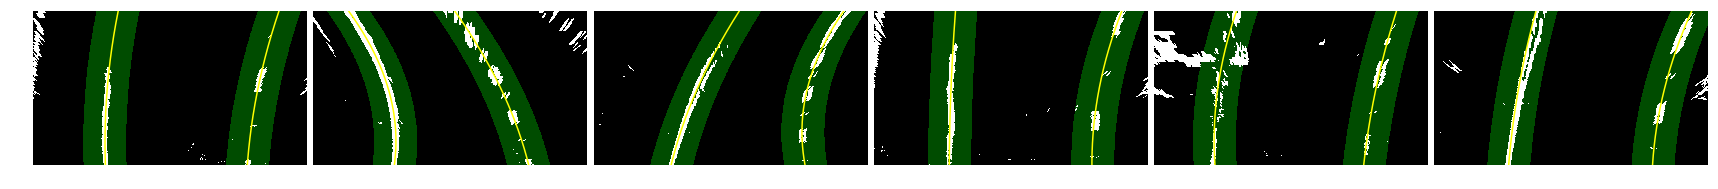

In [132]:
print("Perform sanity check on fitting...")
# Setup the plot grid for test images
plt.figure(figsize = (30,6))
gs1 = gridspec.GridSpec(2,len(warped))
gs1.update(wspace=0.025, hspace=0.05)
fit_results = []
left_fit = []
right_fit = []
left_curverad = 0
right_curverad = 0
margin = 100
sanityOK = False
reset = True
left_line = Line(margin)
right_line = Line(margin)
for i, img in enumerate(warped_imgs):    
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    while 1:
        if not sanityOK:
            
            histogram = np.sum(img[warped.shape[0]//2:,:], axis=0)
            midpoint = np.int(histogram.shape[0]/2)
            lbase = np.argmax(histogram[:midpoint])
            rbase = np.argmax(histogram[midpoint:]) + midpoint
            lval = histogram(lbase)
            rval = histogram(rbase)
            if lval > rval:
                rbase = lbase + 700
            else:
                lbase = rbase - 700
            left_fit = left_line.getPolyfitbySlidingWin(img, lbase)
            right_fit = right_line.getPolyfitbySlidingWin(img, rbase)
            left_line.bufferX(ploty, left_fit)
            right_line.bufferX(ploty, right_fit)
            sanityOK = True
            break
        else:
            left_x, left_fit = left_line.updatePolyfit(img)
            right_x, right_fit = right_line.updatePolyfit(img)
            
            sanityOK = checkSanity(ploty, left_fit, right_fit, margin)
            if sanityOK:
                left_line.current_fit = left_fit
                right_line.current_fit = right_fit
                left_line.bufferX(ploty, left_fit)
                right_line.bufferX(ploty, right_fit)
                break
    
    lc_r = left_line.calculateCurverad(ploty)
    rc_r = right_line.calculateCurverad(ploty)
    print("({:5.2f}, {:5.2f})".format(lc_r, rc_r))
    lc_m = left_line.calculateCurvemit(ploty)
    rc_m = right_line.calculateCurvemit(ploty)
    print("radius = ({:4.3f}km, {:4.3f}km)".format(lc_m/1000, rc_m/1000))
    lo = left_line.getOffset(ploty, int(img.shape[1]/2)) 
    ro = right_line.getOffset(ploty, int(img.shape[1]/2)) 
    print("offset = ({:=4.2f}m, {:=4.2f}m)".format(lo, ro))

    left_line.updateBest(ploty)   
    right_line.updateBest(ploty)  
    # Generate x and y values for plotting
    left_fitx = left_line.getCurrfit(ploty)
    right_fitx = right_line.getCurrfit(ploty)
    
    # Identify the x and y positions of all nonzero pixels in the image
    #nonzero = img.nonzero()
    #nonzeroy = np.array(nonzero[0])
    #nonzerox = np.array(nonzero[1])        
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((img, img, img))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    #out_img[nonzeroy[left_inds], nonzerox[left_inds]] = [255, 0, 0]
    #out_img[nonzeroy[right_inds], nonzerox[right_inds]] = [0, 0, 255]
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
    
    # Plot the original image and the processed images
    #ax1 = plt.subplot(gs1[i,i])
    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    ax1 = plt.subplot(gs1[i])
    plt.axis('off')
    ax1.imshow(result)
    ax1.plot(left_fitx, ploty, color='yellow')
    ax1.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    
    fit_results.append([ploty, left_fitx, right_fitx])
    
    #plt.show()

Unwarp warped images...


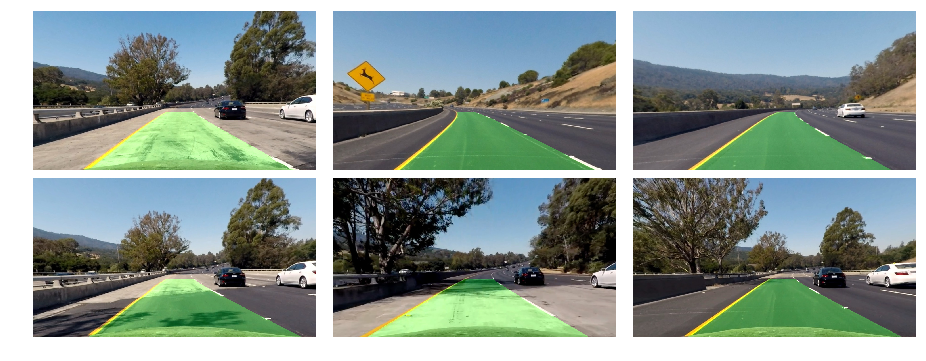

In [99]:
org = org_imgs
undist = undist_imgs
warped = warped_imgs
#fit_results
print("Unwarp warped images...")
# Setup the plot grid for test images
plt.figure(figsize = (16,6))
gs1 = gridspec.GridSpec(2,int(len(warped)/2))
gs1.update(wspace=0.025, hspace=0.05)
for i, vals in enumerate(fit_results):
    ploty, left_fitx, right_fitx = vals
    newwarp = camera.unwarpPerspective(org[i], warped[i], ploty, left_fitx, right_fitx)
    # Combine the result with the original image
    result = cv2.addWeighted(undist[i], 1, newwarp, 0.3, 0)
    
    ax1 = plt.subplot(gs1[i])
    plt.axis('off')
    ax1.imshow(result)

### Smoothing
Even when everything is working, your line detections will jump around from frame to frame a bit and it can be preferable to smooth over the last n frames of video to obtain a cleaner result. Each time you get a new high-confidence measurement, you can append it to the list of recent measurements and then take an average over n past measurements to obtain the lane position you want to draw onto the image.

### <a name="testonvideos"></a>8. Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on three provided videos:

* `project_video.mp4`
* `challenge_video.mp4`
* `harder_challenge_video.mp4`

In [260]:
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import cv2
#from Line import Line
#from ImgProcess import ImgProcess

# Import everything needed to edit/save/watch video clips
import imageio
imageio.plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [593]:
sanityOK = False
ftime = True
#prev_img = [np.array([False])]  
#reset = True

camera = Camera(debug_mode = False, show_plots =False)
camera.calibrate('calibration_wide/GO*.jpg')
left_line = Line(margin=100)
right_line = Line(margin=100)

mtx and dist loaded


In [606]:
def process_image(img):
    global sanityOK
    global ftime
    #global prev_img
    global camera
    global left_line, right_line
    margin = 100
    left_fit = []
    right_fit = []
    left_curverad = 0
    right_curverad = 0
  
    undist = camera.undistort(img)
    bin_img = camera.colorGradientThreshold(undist)
    warped = camera.warpPerspective(bin_img)
    '''
    if ftime:
        warped = np.copy(bw_img)
        ftime = False
    else:
        warped = bw_img | prev_img
    prev_img = np.copy(bw_img)
    '''
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    while 1:
        if not sanityOK:
            histogram = np.sum(warped[int(warped.shape[0]/2):,:], axis=0)
            midpoint = np.int(histogram.shape[0]/2)
            lstart = margin*2
            lend = midpoint-margin
            lbase = np.argmax(histogram[lstart:lend]) + lstart
            rstart = midpoint+margin
            rend = histogram.shape[0]-margin
            rbase = np.argmax(histogram[rstart:rend]) + rstart
            lval = histogram[lbase]
            rval = histogram[rbase]
            if (rbase - lbase) > 750:
                if lval > 100 and rval > 100:
                    linc = abs(histogram[lbase-10]-lval)/lval
                    rinc = abs(histogram[rbase-10]-rval)/rval
                    if linc > rinc: #sharpness
                        rbase = lbase + 700
                        left_line.xbase = lbase
                    else:
                        lbase = rbase -700
                        right_line.xbase = rbase
            elif lval > rval and lval > 100: #P_l(f) < P_r(f)
                if left_line.xbase is None: # only left updated
                    left_line.xbase = lbase
                #elif abs(left_line.xbase-lbase) < 50:
                    left_line.xbase = lbase
                #else:
                    lbase = left_line.xbase 
                rbase = lbase + 700
                print('lbase(c)=', lbase, ' rbase=', rbase)
            #elif rval > 100 and rbase < (histogram.shape[0]-margin):
            elif rval > 100: #P_l(f) < P_r(f)
                if right_line.xbase is None: # only right updated
                    right_line.xbase = rbase
                #elif abs(right_line.xbase-rbase) < 50:
                    right_line.xbase = rbase
                #else:
                    rbase = right_line.xbase
                lbase = rbase - 700
                print('lbase=', lbase, ' rbase(c)=', rbase)
            else: # Both P_l(f) and P_r(f) are high; not any update
                if left_line.xbase is not None:
                    lbase = left_line.xbase
                else:
                    lbase = rbase - 700
                if right_line.xbase is not None:
                    rbase = right_line.xbase
                print('lbase=', lbase, ' rbase=', rbase)
            left_fit = left_line.getPolyfitbySlidingWin(warped, lbase)
            right_fit = right_line.getPolyfitbySlidingWin(warped, rbase)
            left_line.bufferX(ploty, left_fit)
            right_line.bufferX(ploty, right_fit)
            sanityOK = True
            break
        else:
            left_fit = left_line.updatePolyfit(warped)
            right_fit = right_line.updatePolyfit(warped)
            
            sanityOK = checkSanity(ploty, left_fit, right_fit)
            if sanityOK:
                left_line.current_fit = left_fit
                right_line.current_fit = right_fit
                left_line.bufferX(ploty, left_fit)
                right_line.bufferX(ploty, right_fit)
                break
    
    left_line.updateBest(ploty)   
    right_line.updateBest(ploty)  
    # Generate x and y values for plotting
    left_fitx = left_line.getBestfit(ploty)
    right_fitx = right_line.getBestfit(ploty)
    
    # Identify the x and y positions of all nonzero pixels in the image
    #nonzero = img.nonzero()
    #nonzeroy = np.array(nonzero[0])
    #nonzerox = np.array(nonzero[1])        
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((warped, warped, warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    #out_img[nonzeroy[left_inds], nonzerox[left_inds]] = [255, 0, 0]
    #out_img[nonzeroy[right_inds], nonzerox[right_inds]] = [0, 0, 255]
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    # Plot the original image and the processed images
    newwarp = camera.unwarpPerspective(img, warped, ploty, left_fitx, right_fitx)
    # Combine the result with the original image
    lc_r = left_line.calculateCurverad(ploty)
    rc_r = right_line.calculateCurverad(ploty)
    #print("({:5.2f}, {:5.2f})".format(lc_r, rc_r))
    lc_m = left_line.calculateCurvemit(ploty)
    rc_m = right_line.calculateCurvemit(ploty)
    #print("radius = ({:4.3f}km, {:4.3f}km)".format(lc_m/1000, rc_m/1000))
    lo = left_line.getOffset(ploty, int(warped.shape[1]/2)) 
    ro = right_line.getOffset(ploty, int(warped.shape[1]/2)) 
    #print("offset = ({:=4.2f}m, {:=4.2f}m)".format(lo, ro))

    cv2.putText(newwarp, "({:4.3f}km, {:4.3f}km)".format(lc_m/1000, rc_m/1000),
                (int(img.shape[1]/2)-200,img.shape[0]-70), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)
    cv2.putText(newwarp, "offset = ({:=4.2f}m, {:=4.2f}m)".format(lo, ro),
                (int(img.shape[1]/2)-200,img.shape[0]-40), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)

    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    return result

In [587]:
project_output = './output_images/project_video_colored.mp4'
clip1 = VideoFileClip("project_video.mp4")
project_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time project_clip.write_videofile(project_output, audio=False)

lbase(c)= 356  rbase= 1056
[MoviePy] >>>> Building video ./output_images/project_video_colored.mp4
[MoviePy] Writing video ./output_images/project_video_colored.mp4

















  0%|          | 0/1261 [00:00<?, ?it/s]














  0%|          | 1/1261 [00:00<02:52,  7.31it/s]














  0%|          | 2/1261 [00:00<02:50,  7.40it/s]














  0%|          | 3/1261 [00:00<02:38,  7.93it/s]

lbase(c)= 357  rbase= 1057

















  0%|          | 4/1261 [00:00<02:33,  8.17it/s]














  0%|          | 6/1261 [00:00<02:20,  8.92it/s]














  1%|          | 7/1261 [00:00<02:16,  9.19it/s]














  1%|          | 8/1261 [00:00<02:16,  9.16it/s]

lbase(c)= 360  rbase= 1060
lbase(c)= 362  rbase= 1062

















  1%|          | 9/1261 [00:00<02:13,  9.37it/s]














  1%|          | 10/1261 [00:01<02:12,  9.42it/s]

lbase(c)= 362  rbase= 1062
lbase(c)= 361  rbase= 1061

















  1%|          | 11/1261 [00:01<02:23,  8.68it/s]














  1%|          | 12/1261 [00:01<02:28,  8.39it/s]

lbase(c)= 361  rbase= 1061
lbase(c)= 358  rbase= 1058

















  1%|          | 13/1261 [00:01<02:34,  8.10it/s]














  1%|          | 14/1261 [00:01<02:41,  7.71it/s]

lbase(c)= 359  rbase= 1059
lbase(c)= 359  rbase= 1059

















  1%|          | 15/1261 [00:01<02:41,  7.71it/s]














  1%|▏         | 17/1261 [00:01<02:27,  8.43it/s]














  2%|▏         | 19/1261 [00:02<02:23,  8.68it/s]

lbase(c)= 359  rbase= 1059
lbase(c)= 358  rbase= 1058

















  2%|▏         | 20/1261 [00:02<02:17,  9.03it/s]














  2%|▏         | 21/1261 [00:02<02:16,  9.07it/s]

lbase(c)= 356  rbase= 1056
lbase(c)= 356  rbase= 1056

















  2%|▏         | 22/1261 [00:02<02:16,  9.08it/s]














  2%|▏         | 23/1261 [00:02<02:15,  9.14it/s]

lbase(c)= 355  rbase= 1055
lbase(c)= 353  rbase= 1053

















  2%|▏         | 24/1261 [00:02<02:24,  8.56it/s]

lbase(c)= 352  rbase= 1052

















  2%|▏         | 26/1261 [00:02<02:15,  9.10it/s]














  2%|▏         | 28/1261 [00:03<02:10,  9.43it/s]

lbase(c)= 347  rbase= 1047
lbase(c)= 344  rbase= 1044
lbase(c)= 343  rbase= 1043

















  2%|▏         | 29/1261 [00:03<02:10,  9.46it/s]














  2%|▏         | 31/1261 [00:03<02:02, 10.00it/s]














  3%|▎         | 33/1261 [00:03<02:01, 10.11it/s]

lbase(c)= 342  rbase= 1042
lbase(c)= 340  rbase= 1040

















  3%|▎         | 35/1261 [00:03<02:02,  9.97it/s]

lbase(c)= 342  rbase= 1042
lbase(c)= 343  rbase= 1043

















  3%|▎         | 37/1261 [00:03<02:01, 10.10it/s]














  3%|▎         | 39/1261 [00:04<01:59, 10.24it/s]

lbase(c)= 348  rbase= 1048

















  3%|▎         | 41/1261 [00:04<01:52, 10.86it/s]














  3%|▎         | 43/1261 [00:04<02:03,  9.90it/s]














  4%|▎         | 45/1261 [00:04<02:02,  9.94it/s]














  4%|▎         | 47/1261 [00:04<02:04,  9.76it/s]

lbase(c)= 351  rbase= 1051
lbase(c)= 351  rbase= 1051
lbase(c)= 351  rbase= 1051

















  4%|▍         | 48/1261 [00:05<02:06,  9.62it/s]














  4%|▍         | 49/1261 [00:05<02:12,  9.18it/s]














  4%|▍         | 50/1261 [00:05<02:20,  8.63it/s]

lbase(c)= 351  rbase= 1051

















  4%|▍         | 51/1261 [00:05<02:19,  8.68it/s]














  4%|▍         | 52/1261 [00:05<02:17,  8.77it/s]














  4%|▍         | 53/1261 [00:05<02:16,  8.88it/s]

lbase(c)= 352  rbase= 1052

















  4%|▍         | 55/1261 [00:05<02:08,  9.37it/s]














  5%|▍         | 57/1261 [00:06<02:00, 10.03it/s]














  5%|▍         | 59/1261 [00:06<02:05,  9.60it/s]

lbase(c)= 350  rbase= 1050
lbase(c)= 351  rbase= 1051

















  5%|▍         | 60/1261 [00:06<02:04,  9.61it/s]














  5%|▍         | 62/1261 [00:06<02:01,  9.85it/s]

lbase(c)= 350  rbase= 1050
lbase(c)= 350  rbase= 1050

















  5%|▍         | 63/1261 [00:06<02:06,  9.46it/s]














  5%|▌         | 64/1261 [00:06<02:12,  9.06it/s]














  5%|▌         | 65/1261 [00:06<02:15,  8.80it/s]














  5%|▌         | 66/1261 [00:07<02:14,  8.88it/s]














  5%|▌         | 67/1261 [00:07<02:14,  8.87it/s]














  5%|▌         | 68/1261 [00:07<02:13,  8.96it/s]

lbase(c)= 342  rbase= 1042
lbase(c)= 340  rbase= 1040

















  5%|▌         | 69/1261 [00:07<02:25,  8.22it/s]














  6%|▌         | 70/1261 [00:07<02:27,  8.06it/s]

lbase(c)= 339  rbase= 1039
lbase(c)= 337  rbase= 1037

















  6%|▌         | 71/1261 [00:07<02:30,  7.89it/s]














  6%|▌         | 72/1261 [00:07<02:25,  8.17it/s]

lbase(c)= 336  rbase= 1036
lbase(c)= 334  rbase= 1034

















  6%|▌         | 73/1261 [00:07<02:18,  8.56it/s]














  6%|▌         | 75/1261 [00:08<02:09,  9.19it/s]














  6%|▌         | 76/1261 [00:08<02:18,  8.55it/s]














  6%|▌         | 78/1261 [00:08<02:15,  8.71it/s]














  6%|▋         | 79/1261 [00:08<02:10,  9.03it/s]

lbase(c)= 330  rbase= 1030
lbase(c)= 329  rbase= 1029

















  6%|▋         | 80/1261 [00:08<02:17,  8.59it/s]














  6%|▋         | 81/1261 [00:08<02:13,  8.84it/s]

lbase(c)= 328  rbase= 1028
lbase(c)= 328  rbase= 1028

















  7%|▋         | 82/1261 [00:08<02:09,  9.10it/s]














  7%|▋         | 83/1261 [00:08<02:06,  9.30it/s]














  7%|▋         | 84/1261 [00:09<02:05,  9.35it/s]














  7%|▋         | 85/1261 [00:09<02:17,  8.58it/s]

lbase(c)= 320  rbase= 1020
lbase(c)= 319  rbase= 1019

















  7%|▋         | 86/1261 [00:09<02:20,  8.35it/s]














  7%|▋         | 87/1261 [00:09<02:18,  8.47it/s]

lbase(c)= 317  rbase= 1017

















  7%|▋         | 88/1261 [00:09<02:17,  8.51it/s]














  7%|▋         | 89/1261 [00:09<02:15,  8.65it/s]

lbase(c)= 318  rbase= 1018

















  7%|▋         | 90/1261 [00:09<02:10,  9.00it/s]














  7%|▋         | 91/1261 [00:09<02:17,  8.54it/s]














  7%|▋         | 93/1261 [00:10<02:12,  8.83it/s]














  7%|▋         | 94/1261 [00:10<02:18,  8.45it/s]

lbase(c)= 324  rbase= 1024
lbase(c)= 324  rbase= 1024

















  8%|▊         | 95/1261 [00:10<02:34,  7.54it/s]














  8%|▊         | 96/1261 [00:10<02:34,  7.55it/s]














  8%|▊         | 97/1261 [00:10<02:36,  7.42it/s]

lbase(c)= 324  rbase= 1024
lbase(c)= 326  rbase= 1026

















  8%|▊         | 98/1261 [00:10<02:43,  7.10it/s]














  8%|▊         | 99/1261 [00:10<02:43,  7.11it/s]

lbase(c)= 326  rbase= 1026

















  8%|▊         | 100/1261 [00:11<02:56,  6.58it/s]














  8%|▊         | 101/1261 [00:11<03:01,  6.40it/s]














  8%|▊         | 102/1261 [00:11<02:46,  6.98it/s]














  8%|▊         | 104/1261 [00:11<02:29,  7.74it/s]














  8%|▊         | 105/1261 [00:11<02:46,  6.94it/s]














  8%|▊         | 106/1261 [00:11<02:57,  6.52it/s]














  9%|▊         | 108/1261 [00:12<02:48,  6.86it/s]














  9%|▊         | 109/1261 [00:12<03:08,  6.10it/s]

lbase(c)= 335  rbase= 1035

















  9%|▊         | 110/1261 [00:12<03:21,  5.72it/s]














  9%|▉         | 111/1261 [00:12<03:00,  6.39it/s]

lbase(c)= 335  rbase= 1035
lbase(c)= 336  rbase= 1036

















  9%|▉         | 112/1261 [00:12<02:52,  6.66it/s]

lbase(c)= 334  rbase= 1034

















  9%|▉         | 114/1261 [00:13<02:38,  7.25it/s]














  9%|▉         | 115/1261 [00:13<02:27,  7.76it/s]














  9%|▉         | 116/1261 [00:13<02:25,  7.85it/s]














  9%|▉         | 117/1261 [00:13<02:17,  8.30it/s]














  9%|▉         | 119/1261 [00:13<02:07,  8.95it/s]














 10%|▉         | 120/1261 [00:13<02:04,  9.20it/s]














 10%|▉         | 122/1261 [00:13<02:09,  8.78it/s]














 10%|▉         | 123/1261 [00:14<02:15,  8.38it/s]

lbase(c)= 347  rbase= 1047

















 10%|▉         | 124/1261 [00:14<02:25,  7.83it/s]

lbase(c)= 350  rbase= 1050
lbase(c)= 351  rbase= 1051

















 10%|▉         | 125/1261 [00:14<02:37,  7.20it/s]














 10%|▉         | 126/1261 [00:14<02:30,  7.54it/s]














 10%|█         | 128/1261 [00:14<02:20,  8.04it/s]














 10%|█         | 129/1261 [00:14<02:36,  7.22it/s]














 10%|█         | 130/1261 [00:15<02:33,  7.36it/s]














 10%|█         | 131/1261 [00:15<02:22,  7.95it/s]














 10%|█         | 132/1261 [00:15<02:13,  8.47it/s]














 11%|█         | 133/1261 [00:15<02:10,  8.66it/s]

lbase(c)= 357  rbase= 1057

















 11%|█         | 135/1261 [00:15<02:05,  8.96it/s]














 11%|█         | 137/1261 [00:15<02:00,  9.33it/s]














 11%|█         | 138/1261 [00:15<02:06,  8.90it/s]

lbase(c)= 360  rbase= 1060
lbase(c)= 359  rbase= 1059

















 11%|█         | 139/1261 [00:15<02:12,  8.44it/s]














 11%|█         | 140/1261 [00:16<02:24,  7.76it/s]

lbase(c)= 358  rbase= 1058
lbase(c)= 356  rbase= 1056

















 11%|█▏        | 142/1261 [00:16<02:13,  8.37it/s]














 11%|█▏        | 143/1261 [00:16<02:23,  7.80it/s]














 11%|█▏        | 144/1261 [00:16<02:34,  7.21it/s]














 11%|█▏        | 145/1261 [00:16<02:26,  7.61it/s]

lbase(c)= 355  rbase= 1055
lbase(c)= 354  rbase= 1054

















 12%|█▏        | 146/1261 [00:16<02:24,  7.72it/s]














 12%|█▏        | 147/1261 [00:17<02:16,  8.18it/s]

lbase(c)= 354  rbase= 1054
lbase(c)= 353  rbase= 1053

















 12%|█▏        | 148/1261 [00:17<02:14,  8.28it/s]














 12%|█▏        | 149/1261 [00:17<02:28,  7.48it/s]














 12%|█▏        | 150/1261 [00:17<02:25,  7.63it/s]

lbase(c)= 356  rbase= 1056

















 12%|█▏        | 152/1261 [00:17<02:11,  8.43it/s]














 12%|█▏        | 153/1261 [00:17<02:17,  8.09it/s]














 12%|█▏        | 154/1261 [00:17<02:09,  8.52it/s]














 12%|█▏        | 156/1261 [00:18<02:01,  9.07it/s]














 12%|█▏        | 157/1261 [00:18<01:59,  9.21it/s]














 13%|█▎        | 158/1261 [00:18<02:06,  8.71it/s]














 13%|█▎        | 159/1261 [00:18<02:05,  8.75it/s]

lbase(c)= 349  rbase= 1049
lbase(c)= 346  rbase= 1046

















 13%|█▎        | 160/1261 [00:18<02:30,  7.32it/s]

lbase(c)= 345  rbase= 1045
lbase(c)= 342  rbase= 1042

















 13%|█▎        | 161/1261 [00:18<02:54,  6.31it/s]














 13%|█▎        | 162/1261 [00:18<02:42,  6.75it/s]














 13%|█▎        | 163/1261 [00:18<02:28,  7.39it/s]

lbase(c)= 341  rbase= 1041
lbase(c)= 339  rbase= 1039

















 13%|█▎        | 164/1261 [00:19<02:29,  7.31it/s]














 13%|█▎        | 165/1261 [00:19<02:26,  7.48it/s]

lbase(c)= 339  rbase= 1039

















 13%|█▎        | 166/1261 [00:19<02:26,  7.45it/s]














 13%|█▎        | 167/1261 [00:19<02:46,  6.59it/s]














 13%|█▎        | 168/1261 [00:19<02:39,  6.86it/s]














 13%|█▎        | 170/1261 [00:19<02:29,  7.31it/s]

lbase(c)= 335  rbase= 1035
lbase(c)= 333  rbase= 1033

















 14%|█▎        | 172/1261 [00:20<02:21,  7.69it/s]














 14%|█▎        | 173/1261 [00:20<02:19,  7.77it/s]














 14%|█▍        | 174/1261 [00:20<02:21,  7.66it/s]














 14%|█▍        | 175/1261 [00:20<02:20,  7.71it/s]














 14%|█▍        | 176/1261 [00:20<02:21,  7.67it/s]














 14%|█▍        | 177/1261 [00:20<02:23,  7.57it/s]














 14%|█▍        | 178/1261 [00:20<02:15,  7.99it/s]














 14%|█▍        | 179/1261 [00:21<02:08,  8.44it/s]














 14%|█▍        | 180/1261 [00:21<02:22,  7.58it/s]














 14%|█▍        | 181/1261 [00:21<02:19,  7.75it/s]














 14%|█▍        | 182/1261 [00:21<02:18,  7.82it/s]














 15%|█▍        | 183/1261 [00:21<02:10,  8.27it/s]














 15%|█▍        | 184/1261 [00:21<02:04,  8.62it/s]














 15%|█▍        | 186/1261 [00:21<01:57,  9.16it/s]














 15%|█▍        | 187/1261 [00:21<01:59,  9.00it/s]

lbase(c)= 330  rbase= 1030
lbase(c)= 330  rbase= 1030

















 15%|█▍        | 188/1261 [00:22<02:15,  7.91it/s]

lbase(c)= 332  rbase= 1032
lbase(c)= 335  rbase= 1035

















 15%|█▍        | 189/1261 [00:22<02:31,  7.10it/s]














 15%|█▌        | 190/1261 [00:22<02:36,  6.83it/s]














 15%|█▌        | 191/1261 [00:22<02:25,  7.33it/s]

lbase(c)= 338  rbase= 1038
lbase(c)= 342  rbase= 1042

















 15%|█▌        | 192/1261 [00:22<02:25,  7.37it/s]














 15%|█▌        | 194/1261 [00:22<02:10,  8.15it/s]














 16%|█▌        | 196/1261 [00:23<02:00,  8.81it/s]














 16%|█▌        | 197/1261 [00:23<02:03,  8.60it/s]

lbase(c)= 345  rbase= 1045
lbase(c)= 341  rbase= 1041

















 16%|█▌        | 198/1261 [00:23<02:00,  8.85it/s]














 16%|█▌        | 199/1261 [00:23<02:03,  8.61it/s]

lbase(c)= 338  rbase= 1038
lbase(c)= 334  rbase= 1034

















 16%|█▌        | 200/1261 [00:23<02:04,  8.55it/s]














 16%|█▌        | 201/1261 [00:23<02:11,  8.06it/s]

lbase(c)= 334  rbase= 1034

















 16%|█▌        | 202/1261 [00:23<02:05,  8.42it/s]














 16%|█▌        | 203/1261 [00:23<02:00,  8.79it/s]














 16%|█▋        | 205/1261 [00:24<01:52,  9.39it/s]














 16%|█▋        | 206/1261 [00:24<01:56,  9.05it/s]














 16%|█▋        | 208/1261 [00:24<01:46,  9.92it/s]














 17%|█▋        | 210/1261 [00:24<01:48,  9.67it/s]

lbase(c)= 334  rbase= 1034

















 17%|█▋        | 211/1261 [00:24<01:54,  9.18it/s]














 17%|█▋        | 213/1261 [00:24<01:50,  9.47it/s]














 17%|█▋        | 215/1261 [00:25<01:49,  9.53it/s]

lbase(c)= 331  rbase= 1031

















 17%|█▋        | 216/1261 [00:25<01:48,  9.61it/s]














 17%|█▋        | 218/1261 [00:25<01:45,  9.92it/s]














 17%|█▋        | 220/1261 [00:25<01:52,  9.25it/s]

lbase(c)= 326  rbase= 1026
lbase(c)= 326  rbase= 1026

















 18%|█▊        | 221/1261 [00:25<01:57,  8.85it/s]














 18%|█▊        | 222/1261 [00:25<01:55,  8.96it/s]

lbase(c)= 327  rbase= 1027
lbase(c)= 327  rbase= 1027

















 18%|█▊        | 223/1261 [00:26<02:06,  8.19it/s]














 18%|█▊        | 224/1261 [00:26<02:11,  7.89it/s]

lbase(c)= 327  rbase= 1027
lbase(c)= 329  rbase= 1029

















 18%|█▊        | 225/1261 [00:26<02:12,  7.83it/s]














 18%|█▊        | 226/1261 [00:26<02:10,  7.91it/s]

lbase(c)= 328  rbase= 1028

















 18%|█▊        | 227/1261 [00:26<02:08,  8.02it/s]














 18%|█▊        | 229/1261 [00:26<01:56,  8.89it/s]














 18%|█▊        | 230/1261 [00:26<01:58,  8.72it/s]














 18%|█▊        | 231/1261 [00:26<01:54,  8.99it/s]














 18%|█▊        | 233/1261 [00:27<01:53,  9.07it/s]

lbase(c)= 317  rbase= 1017
lbase(c)= 316  rbase= 1016

















 19%|█▊        | 234/1261 [00:27<01:55,  8.90it/s]

lbase(c)= 315  rbase= 1015

















 19%|█▊        | 236/1261 [00:27<01:50,  9.25it/s]














 19%|█▉        | 238/1261 [00:27<01:41, 10.08it/s]














 19%|█▉        | 240/1261 [00:27<01:41, 10.04it/s]














 19%|█▉        | 242/1261 [00:28<01:42,  9.99it/s]














 19%|█▉        | 244/1261 [00:28<01:39, 10.18it/s]














 20%|█▉        | 246/1261 [00:28<01:41,  9.97it/s]














 20%|█▉        | 248/1261 [00:28<01:49,  9.28it/s]














 20%|█▉        | 250/1261 [00:28<01:44,  9.69it/s]














 20%|█▉        | 251/1261 [00:28<01:47,  9.43it/s]














 20%|█▉        | 252/1261 [00:29<01:49,  9.19it/s]














 20%|██        | 253/1261 [00:29<01:48,  9.30it/s]














 20%|██        | 255/1261 [00:29<01:42,  9.84it/s]














 20%|██        | 256/1261 [00:29<01:45,  9.57it/s]














 20%|██        | 258/1261 [00:29<01:42,  9.80it/s]














 21%|██        | 259/1261 [00:29<01:44,  9.60it/s]














 21%|██   

lbase(c)= 302  rbase= 1002
lbase(c)= 302  rbase= 1002

















 21%|██▏       | 271/1261 [00:30<01:35, 10.39it/s]














 22%|██▏       | 273/1261 [00:31<01:34, 10.47it/s]

lbase(c)= 309  rbase= 1009

















 22%|██▏       | 275/1261 [00:31<01:34, 10.47it/s]














 22%|██▏       | 277/1261 [00:31<01:31, 10.80it/s]














 22%|██▏       | 279/1261 [00:31<01:32, 10.66it/s]

lbase(c)= 314  rbase= 1014
lbase(c)= 315  rbase= 1015

















 22%|██▏       | 281/1261 [00:31<01:35, 10.25it/s]

lbase(c)= 317  rbase= 1017

















 22%|██▏       | 283/1261 [00:32<01:30, 10.77it/s]














 23%|██▎       | 285/1261 [00:32<01:37, 10.00it/s]

lbase(c)= 321  rbase= 1021
lbase(c)= 323  rbase= 1023

















 23%|██▎       | 287/1261 [00:32<01:42,  9.52it/s]

lbase(c)= 321  rbase= 1021

















 23%|██▎       | 288/1261 [00:32<01:41,  9.59it/s]














 23%|██▎       | 289/1261 [00:32<01:47,  9.04it/s]














 23%|██▎       | 291/1261 [00:32<01:47,  9.04it/s]














 23%|██▎       | 292/1261 [00:33<01:53,  8.53it/s]

lbase(c)= 328  rbase= 1028
lbase(c)= 330  rbase= 1030

















 23%|██▎       | 293/1261 [00:33<01:58,  8.14it/s]

lbase(c)= 336  rbase= 1036

















 23%|██▎       | 295/1261 [00:33<01:48,  8.92it/s]














 23%|██▎       | 296/1261 [00:33<01:54,  8.45it/s]














 24%|██▎       | 297/1261 [00:33<01:59,  8.08it/s]

lbase(c)= 333  rbase= 1033

















 24%|██▎       | 298/1261 [00:33<02:07,  7.57it/s]














 24%|██▎       | 299/1261 [00:33<01:59,  8.08it/s]














 24%|██▍       | 300/1261 [00:34<01:57,  8.17it/s]














 24%|██▍       | 302/1261 [00:34<01:48,  8.87it/s]














 24%|██▍       | 303/1261 [00:34<01:47,  8.89it/s]














 24%|██▍       | 304/1261 [00:34<01:51,  8.59it/s]

lbase(c)= 328  rbase= 1028
lbase(c)= 328  rbase= 1028

















 24%|██▍       | 305/1261 [00:34<01:49,  8.72it/s]














 24%|██▍       | 307/1261 [00:34<01:45,  9.02it/s]














 24%|██▍       | 308/1261 [00:34<01:43,  9.25it/s]














 25%|██▍       | 309/1261 [00:34<01:48,  8.80it/s]














 25%|██▍       | 310/1261 [00:35<01:44,  9.06it/s]














 25%|██▍       | 311/1261 [00:35<01:57,  8.06it/s]

lbase(c)= 334  rbase= 1034
lbase(c)= 337  rbase= 1037

















 25%|██▍       | 312/1261 [00:35<01:54,  8.27it/s]














 25%|██▍       | 313/1261 [00:35<02:02,  7.76it/s]

lbase(c)= 338  rbase= 1038
lbase(c)= 340  rbase= 1040

















 25%|██▍       | 314/1261 [00:35<02:09,  7.32it/s]














 25%|██▍       | 315/1261 [00:35<02:06,  7.46it/s]

lbase(c)= 340  rbase= 1040
lbase(c)= 340  rbase= 1040

















 25%|██▌       | 316/1261 [00:35<02:04,  7.61it/s]














 25%|██▌       | 317/1261 [00:36<02:06,  7.44it/s]

lbase(c)= 340  rbase= 1040
lbase(c)= 339  rbase= 1039

















 25%|██▌       | 318/1261 [00:36<02:07,  7.42it/s]














 25%|██▌       | 319/1261 [00:36<02:05,  7.49it/s]

lbase(c)= 342  rbase= 1042
lbase(c)= 342  rbase= 1042

















 25%|██▌       | 320/1261 [00:36<02:05,  7.50it/s]














 25%|██▌       | 321/1261 [00:36<01:59,  7.89it/s]

lbase(c)= 345  rbase= 1045
lbase(c)= 345  rbase= 1045

















 26%|██▌       | 322/1261 [00:36<01:57,  7.96it/s]














 26%|██▌       | 323/1261 [00:36<01:54,  8.20it/s]

lbase(c)= 345  rbase= 1045
lbase(c)= 345  rbase= 1045

















 26%|██▌       | 324/1261 [00:36<01:57,  7.99it/s]

lbase(c)= 343  rbase= 1043
lbase(c)= 343  rbase= 1043

















 26%|██▌       | 326/1261 [00:37<01:52,  8.34it/s]














 26%|██▌       | 327/1261 [00:37<01:48,  8.58it/s]

lbase(c)= 343  rbase= 1043
lbase(c)= 340  rbase= 1040

















 26%|██▌       | 329/1261 [00:37<01:46,  8.72it/s]

lbase(c)= 339  rbase= 1039
lbase(c)= 337  rbase= 1037

















 26%|██▌       | 330/1261 [00:37<01:46,  8.71it/s]














 26%|██▌       | 331/1261 [00:37<01:46,  8.70it/s]

lbase(c)= 338  rbase= 1038
lbase(c)= 338  rbase= 1038

















 26%|██▋       | 332/1261 [00:37<01:45,  8.77it/s]














 26%|██▋       | 333/1261 [00:37<01:49,  8.51it/s]

lbase(c)= 342  rbase= 1042
lbase(c)= 343  rbase= 1043

















 27%|██▋       | 335/1261 [00:38<01:45,  8.78it/s]














 27%|██▋       | 336/1261 [00:38<01:43,  8.90it/s]














 27%|██▋       | 337/1261 [00:38<01:44,  8.83it/s]

lbase(c)= 340  rbase= 1040
lbase(c)= 340  rbase= 1040

















 27%|██▋       | 338/1261 [00:38<01:56,  7.89it/s]














 27%|██▋       | 339/1261 [00:38<01:56,  7.91it/s]

lbase(c)= 340  rbase= 1040
lbase(c)= 339  rbase= 1039

















 27%|██▋       | 340/1261 [00:38<01:52,  8.16it/s]














 27%|██▋       | 341/1261 [00:38<01:49,  8.42it/s]

lbase(c)= 342  rbase= 1042
lbase(c)= 344  rbase= 1044

















 27%|██▋       | 342/1261 [00:39<01:56,  7.91it/s]














 27%|██▋       | 343/1261 [00:39<02:01,  7.53it/s]

lbase(c)= 347  rbase= 1047
lbase(c)= 345  rbase= 1045

















 27%|██▋       | 344/1261 [00:39<02:01,  7.54it/s]














 27%|██▋       | 345/1261 [00:39<01:59,  7.67it/s]

lbase(c)= 344  rbase= 1044
lbase(c)= 345  rbase= 1045

















 27%|██▋       | 346/1261 [00:39<01:57,  7.79it/s]














 28%|██▊       | 347/1261 [00:39<01:53,  8.05it/s]

lbase(c)= 342  rbase= 1042
lbase(c)= 345  rbase= 1045

















 28%|██▊       | 348/1261 [00:39<01:54,  7.97it/s]














 28%|██▊       | 349/1261 [00:39<01:50,  8.25it/s]

lbase(c)= 343  rbase= 1043
lbase(c)= 344  rbase= 1044

















 28%|██▊       | 350/1261 [00:40<01:52,  8.08it/s]














 28%|██▊       | 351/1261 [00:40<01:52,  8.06it/s]

lbase(c)= 342  rbase= 1042
lbase(c)= 342  rbase= 1042

















 28%|██▊       | 352/1261 [00:40<01:59,  7.64it/s]














 28%|██▊       | 353/1261 [00:40<02:00,  7.56it/s]

lbase(c)= 341  rbase= 1041
lbase(c)= 340  rbase= 1040

















 28%|██▊       | 354/1261 [00:40<01:59,  7.56it/s]














 28%|██▊       | 355/1261 [00:40<01:54,  7.94it/s]














 28%|██▊       | 356/1261 [00:40<01:52,  8.08it/s]

lbase(c)= 338  rbase= 1038
lbase(c)= 338  rbase= 1038

















 28%|██▊       | 357/1261 [00:40<01:54,  7.88it/s]














 28%|██▊       | 358/1261 [00:41<01:47,  8.38it/s]

lbase(c)= 342  rbase= 1042
lbase(c)= 342  rbase= 1042

















 28%|██▊       | 359/1261 [00:41<01:50,  8.19it/s]














 29%|██▊       | 360/1261 [00:41<01:44,  8.59it/s]














 29%|██▊       | 361/1261 [00:41<01:44,  8.57it/s]














 29%|██▊       | 362/1261 [00:41<01:47,  8.36it/s]

lbase(c)= 345  rbase= 1045
lbase(c)= 353  rbase= 1053

















 29%|██▉       | 363/1261 [00:41<01:46,  8.46it/s]

lbase(c)= 355  rbase= 1055

















 29%|██▉       | 365/1261 [00:41<01:42,  8.76it/s]














 29%|██▉       | 367/1261 [00:42<01:38,  9.04it/s]

lbase(c)= 352  rbase= 1052
lbase(c)= 350  rbase= 1050

















 29%|██▉       | 368/1261 [00:42<01:37,  9.17it/s]














 29%|██▉       | 369/1261 [00:42<01:41,  8.80it/s]














 29%|██▉       | 370/1261 [00:42<01:38,  9.02it/s]

lbase(c)= 350  rbase= 1050
lbase(c)= 347  rbase= 1047

















 29%|██▉       | 371/1261 [00:42<01:46,  8.38it/s]














 30%|██▉       | 372/1261 [00:42<01:41,  8.79it/s]

lbase(c)= 346  rbase= 1046
lbase(c)= 344  rbase= 1044

















 30%|██▉       | 373/1261 [00:42<01:54,  7.78it/s]














 30%|██▉       | 374/1261 [00:42<01:49,  8.11it/s]

lbase(c)= 342  rbase= 1042

















 30%|██▉       | 375/1261 [00:43<01:47,  8.23it/s]














 30%|██▉       | 376/1261 [00:43<01:46,  8.35it/s]

lbase(c)= 339  rbase= 1039
lbase(c)= 343  rbase= 1043

















 30%|██▉       | 377/1261 [00:43<01:48,  8.16it/s]

lbase(c)= 343  rbase= 1043
lbase(c)= 346  rbase= 1046

















 30%|██▉       | 378/1261 [00:43<02:01,  7.25it/s]














 30%|███       | 379/1261 [00:43<02:03,  7.14it/s]














 30%|███       | 380/1261 [00:43<02:02,  7.20it/s]

lbase(c)= 344  rbase= 1044
lbase(c)= 343  rbase= 1043

















 30%|███       | 381/1261 [00:43<01:56,  7.57it/s]














 30%|███       | 383/1261 [00:44<01:46,  8.25it/s]














 30%|███       | 384/1261 [00:44<01:44,  8.36it/s]

lbase(c)= 345  rbase= 1045
lbase(c)= 346  rbase= 1046

















 31%|███       | 385/1261 [00:44<01:48,  8.09it/s]

lbase(c)= 345  rbase= 1045

















 31%|███       | 386/1261 [00:44<01:58,  7.37it/s]














 31%|███       | 387/1261 [00:44<01:57,  7.42it/s]














 31%|███       | 388/1261 [00:44<01:54,  7.61it/s]














 31%|███       | 389/1261 [00:44<01:48,  8.02it/s]

lbase(c)= 342  rbase= 1042
lbase(c)= 339  rbase= 1039

















 31%|███       | 390/1261 [00:44<01:50,  7.91it/s]














 31%|███       | 391/1261 [00:45<01:53,  7.65it/s]

lbase(c)= 338  rbase= 1038
lbase(c)= 338  rbase= 1038

















 31%|███       | 392/1261 [00:45<01:57,  7.39it/s]

lbase(c)= 337  rbase= 1037

















 31%|███       | 394/1261 [00:45<01:46,  8.12it/s]














 31%|███▏      | 396/1261 [00:45<01:37,  8.91it/s]














 31%|███▏      | 397/1261 [00:45<01:44,  8.30it/s]














 32%|███▏      | 398/1261 [00:45<01:40,  8.61it/s]

lbase(c)= 335  rbase= 1035
lbase(c)= 333  rbase= 1033

















 32%|███▏      | 399/1261 [00:45<01:52,  7.68it/s]














 32%|███▏      | 401/1261 [00:46<01:43,  8.30it/s]














 32%|███▏      | 402/1261 [00:46<01:38,  8.69it/s]

lbase(c)= 329  rbase= 1029
lbase(c)= 328  rbase= 1028

















 32%|███▏      | 403/1261 [00:46<01:43,  8.25it/s]














 32%|███▏      | 404/1261 [00:46<01:42,  8.37it/s]

lbase(c)= 329  rbase= 1029
lbase(c)= 327  rbase= 1027

















 32%|███▏      | 405/1261 [00:46<01:54,  7.46it/s]














 32%|███▏      | 406/1261 [00:46<01:48,  7.85it/s]

lbase(c)= 328  rbase= 1028
lbase(c)= 326  rbase= 1026

















 32%|███▏      | 407/1261 [00:46<01:45,  8.09it/s]














 32%|███▏      | 408/1261 [00:47<01:44,  8.15it/s]

lbase(c)= 326  rbase= 1026
lbase(c)= 326  rbase= 1026

















 32%|███▏      | 409/1261 [00:47<01:47,  7.94it/s]














 33%|███▎      | 410/1261 [00:47<01:40,  8.43it/s]

lbase(c)= 325  rbase= 1025
lbase(c)= 325  rbase= 1025

















 33%|███▎      | 411/1261 [00:47<01:51,  7.61it/s]














 33%|███▎      | 412/1261 [00:47<01:45,  8.03it/s]

lbase(c)= 324  rbase= 1024
lbase(c)= 324  rbase= 1024

















 33%|███▎      | 413/1261 [00:47<01:43,  8.22it/s]














 33%|███▎      | 414/1261 [00:47<01:42,  8.25it/s]

lbase(c)= 324  rbase= 1024
lbase(c)= 323  rbase= 1023

















 33%|███▎      | 415/1261 [00:47<01:46,  7.97it/s]














 33%|███▎      | 416/1261 [00:48<01:40,  8.39it/s]

lbase(c)= 321  rbase= 1021
lbase(c)= 318  rbase= 1018

















 33%|███▎      | 417/1261 [00:48<01:39,  8.48it/s]














 33%|███▎      | 418/1261 [00:48<01:35,  8.80it/s]

lbase(c)= 317  rbase= 1017

















 33%|███▎      | 419/1261 [00:48<01:32,  9.11it/s]














 33%|███▎      | 420/1261 [00:48<01:30,  9.27it/s]














 33%|███▎      | 421/1261 [00:48<01:32,  9.03it/s]














 33%|███▎      | 422/1261 [00:48<01:33,  8.94it/s]

lbase(c)= 317  rbase= 1017
lbase(c)= 319  rbase= 1019

















 34%|███▎      | 423/1261 [00:48<01:34,  8.89it/s]

lbase(c)= 317  rbase= 1017

















 34%|███▎      | 425/1261 [00:49<01:31,  9.09it/s]














 34%|███▍      | 426/1261 [00:49<01:34,  8.85it/s]

lbase(c)= 315  rbase= 1015
lbase(c)= 312  rbase= 1012

















 34%|███▍      | 427/1261 [00:49<01:40,  8.34it/s]

lbase(c)= 313  rbase= 1013
lbase(c)= 312  rbase= 1012

















 34%|███▍      | 429/1261 [00:49<01:36,  8.64it/s]

lbase(c)= 312  rbase= 1012

















 34%|███▍      | 431/1261 [00:49<01:28,  9.41it/s]














 34%|███▍      | 432/1261 [00:49<01:37,  8.51it/s]














 34%|███▍      | 433/1261 [00:49<01:34,  8.72it/s]

lbase(c)= 308  rbase= 1008
lbase(c)= 305  rbase= 1005

















 34%|███▍      | 434/1261 [00:50<01:36,  8.56it/s]














 34%|███▍      | 435/1261 [00:50<01:36,  8.56it/s]

lbase(c)= 305  rbase= 1005
lbase(c)= 305  rbase= 1005

















 35%|███▍      | 436/1261 [00:50<01:53,  7.28it/s]














 35%|███▍      | 437/1261 [00:50<01:55,  7.13it/s]

lbase(c)= 305  rbase= 1005
lbase(c)= 307  rbase= 1007

















 35%|███▍      | 438/1261 [00:50<01:54,  7.19it/s]














 35%|███▍      | 439/1261 [00:50<01:45,  7.79it/s]

lbase(c)= 304  rbase= 1004
lbase(c)= 306  rbase= 1006

















 35%|███▍      | 440/1261 [00:50<01:50,  7.43it/s]














 35%|███▍      | 441/1261 [00:50<01:48,  7.55it/s]

lbase(c)= 308  rbase= 1008

















 35%|███▌      | 442/1261 [00:51<01:55,  7.12it/s]

lbase(c)= 306  rbase= 1006
lbase(c)= 301  rbase= 1001

















 35%|███▌      | 443/1261 [00:51<02:05,  6.50it/s]














 35%|███▌      | 444/1261 [00:51<01:57,  6.96it/s]














 35%|███▌      | 445/1261 [00:51<01:48,  7.52it/s]

lbase(c)= 300  rbase= 1000
lbase(c)= 297  rbase= 997

















 35%|███▌      | 446/1261 [00:51<01:40,  8.09it/s]














 35%|███▌      | 447/1261 [00:51<01:45,  7.72it/s]

lbase(c)= 297  rbase= 997
lbase(c)= 298  rbase= 998

















 36%|███▌      | 448/1261 [00:51<01:58,  6.84it/s]

lbase(c)= 297  rbase= 997
lbase(c)= 297  rbase= 997

















 36%|███▌      | 449/1261 [00:52<02:01,  6.67it/s]














 36%|███▌      | 450/1261 [00:52<02:00,  6.71it/s]














 36%|███▌      | 451/1261 [00:52<01:52,  7.20it/s]

lbase(c)= 295  rbase= 995
lbase(c)= 295  rbase= 995

















 36%|███▌      | 452/1261 [00:52<01:55,  6.98it/s]














 36%|███▌      | 453/1261 [00:52<01:54,  7.04it/s]

lbase(c)= 294  rbase= 994
lbase(c)= 294  rbase= 994

















 36%|███▌      | 454/1261 [00:52<02:10,  6.17it/s]














 36%|███▌      | 455/1261 [00:53<02:05,  6.42it/s]

lbase(c)= 298  rbase= 998
lbase(c)= 299  rbase= 999

















 36%|███▌      | 456/1261 [00:53<02:07,  6.34it/s]














 36%|███▌      | 457/1261 [00:53<01:55,  6.93it/s]

lbase(c)= 300  rbase= 1000
lbase(c)= 302  rbase= 1002

















 36%|███▋      | 458/1261 [00:53<01:53,  7.07it/s]

lbase(c)= 303  rbase= 1003
lbase(c)= 309  rbase= 1009

















 36%|███▋      | 459/1261 [00:53<02:02,  6.53it/s]














 36%|███▋      | 460/1261 [00:53<01:58,  6.74it/s]

lbase(c)= 308  rbase= 1008
lbase(c)= 310  rbase= 1010

















 37%|███▋      | 461/1261 [00:53<02:03,  6.46it/s]














 37%|███▋      | 462/1261 [00:54<01:53,  7.01it/s]














 37%|███▋      | 463/1261 [00:54<01:48,  7.37it/s]

lbase(c)= 306  rbase= 1006
lbase(c)= 303  rbase= 1003

















 37%|███▋      | 464/1261 [00:54<01:58,  6.70it/s]














 37%|███▋      | 465/1261 [00:54<01:51,  7.15it/s]

lbase(c)= 309  rbase= 1009

















 37%|███▋      | 466/1261 [00:54<02:00,  6.61it/s]














 37%|███▋      | 467/1261 [00:54<01:51,  7.13it/s]














 37%|███▋      | 469/1261 [00:55<01:44,  7.61it/s]

lbase(c)= 312  rbase= 1012
lbase(c)= 312  rbase= 1012

















 37%|███▋      | 470/1261 [00:55<01:57,  6.72it/s]














 37%|███▋      | 471/1261 [00:55<02:01,  6.49it/s]














 37%|███▋      | 472/1261 [00:55<01:52,  7.02it/s]

lbase(c)= 311  rbase= 1011
lbase(c)= 310  rbase= 1010

















 38%|███▊      | 473/1261 [00:55<01:46,  7.42it/s]














 38%|███▊      | 474/1261 [00:55<01:40,  7.80it/s]

lbase(c)= 311  rbase= 1011
lbase(c)= 313  rbase= 1013

















 38%|███▊      | 475/1261 [00:55<01:44,  7.50it/s]














 38%|███▊      | 476/1261 [00:55<01:37,  8.07it/s]

lbase(c)= 309  rbase= 1009
lbase(c)= 311  rbase= 1011

















 38%|███▊      | 477/1261 [00:56<01:37,  8.01it/s]

lbase(c)= 309  rbase= 1009
lbase(c)= 309  rbase= 1009

















 38%|███▊      | 478/1261 [00:56<01:45,  7.39it/s]














 38%|███▊      | 479/1261 [00:56<01:44,  7.51it/s]














 38%|███▊      | 480/1261 [00:56<01:41,  7.69it/s]

lbase(c)= 309  rbase= 1009
lbase(c)= 308  rbase= 1008

















 38%|███▊      | 481/1261 [00:56<01:38,  7.92it/s]

lbase(c)= 308  rbase= 1008
lbase(c)= 305  rbase= 1005

















 38%|███▊      | 482/1261 [00:56<01:52,  6.93it/s]














 38%|███▊      | 483/1261 [00:56<02:00,  6.48it/s]

lbase(c)= 303  rbase= 1003
lbase(c)= 304  rbase= 1004

















 38%|███▊      | 484/1261 [00:57<02:04,  6.22it/s]














 38%|███▊      | 485/1261 [00:57<01:54,  6.77it/s]














 39%|███▊      | 486/1261 [00:57<01:49,  7.05it/s]

lbase(c)= 303  rbase= 1003
lbase(c)= 308  rbase= 1008

















 39%|███▊      | 487/1261 [00:57<01:46,  7.26it/s]














 39%|███▊      | 488/1261 [00:57<01:38,  7.85it/s]

lbase(c)= 308  rbase= 1008
lbase(c)= 309  rbase= 1009

















 39%|███▉      | 489/1261 [00:57<01:42,  7.50it/s]














 39%|███▉      | 490/1261 [00:57<01:49,  7.06it/s]

lbase(c)= 309  rbase= 1009
lbase(c)= 309  rbase= 1009

















 39%|███▉      | 491/1261 [00:58<01:50,  6.99it/s]

lbase(c)= 310  rbase= 1010
lbase(c)= 308  rbase= 1008

















 39%|███▉      | 492/1261 [00:58<02:05,  6.12it/s]














 39%|███▉      | 494/1261 [00:58<01:49,  7.02it/s]














 39%|███▉      | 495/1261 [00:58<01:43,  7.39it/s]

lbase(c)= 307  rbase= 1007
lbase(c)= 306  rbase= 1006

















 39%|███▉      | 496/1261 [00:58<01:39,  7.69it/s]














 39%|███▉      | 497/1261 [00:58<01:36,  7.90it/s]

lbase(c)= 307  rbase= 1007
lbase(c)= 310  rbase= 1010

















 39%|███▉      | 498/1261 [00:58<01:31,  8.35it/s]

lbase(c)= 311  rbase= 1011
lbase(c)= 307  rbase= 1007

















 40%|███▉      | 499/1261 [00:59<01:44,  7.32it/s]














 40%|███▉      | 500/1261 [00:59<01:55,  6.61it/s]














 40%|███▉      | 501/1261 [00:59<01:47,  7.10it/s]

lbase(c)= 303  rbase= 1003
lbase(c)= 302  rbase= 1002

















 40%|███▉      | 502/1261 [00:59<01:41,  7.45it/s]














 40%|███▉      | 503/1261 [00:59<01:34,  8.04it/s]

lbase(c)= 302  rbase= 1002
lbase(c)= 303  rbase= 1003

















 40%|███▉      | 504/1261 [00:59<01:54,  6.63it/s]














 40%|████      | 505/1261 [00:59<01:46,  7.12it/s]

lbase(c)= 303  rbase= 1003
lbase(c)= 303  rbase= 1003

















 40%|████      | 506/1261 [01:00<01:46,  7.11it/s]














 40%|████      | 507/1261 [01:00<01:44,  7.18it/s]














 40%|████      | 508/1261 [01:00<01:43,  7.30it/s]

lbase(c)= 305  rbase= 1005
lbase(c)= 303  rbase= 1003

















 40%|████      | 509/1261 [01:00<01:41,  7.42it/s]














 40%|████      | 510/1261 [01:00<01:45,  7.14it/s]

lbase(c)= 301  rbase= 1001
lbase(c)= 301  rbase= 1001

















 41%|████      | 511/1261 [01:00<01:45,  7.09it/s]














 41%|████      | 512/1261 [01:00<01:37,  7.69it/s]

lbase(c)= 301  rbase= 1001
lbase(c)= 302  rbase= 1002

















 41%|████      | 514/1261 [01:01<01:32,  8.04it/s]














 41%|████      | 515/1261 [01:01<01:32,  8.06it/s]

lbase(c)= 304  rbase= 1004
lbase(c)= 305  rbase= 1005

















 41%|████      | 516/1261 [01:01<01:32,  8.06it/s]














 41%|████      | 517/1261 [01:01<01:32,  8.05it/s]














 41%|████      | 518/1261 [01:01<01:30,  8.20it/s]

lbase(c)= 302  rbase= 1002
lbase(c)= 302  rbase= 1002

















 41%|████      | 519/1261 [01:01<01:33,  7.95it/s]














 41%|████      | 520/1261 [01:01<01:30,  8.17it/s]

lbase(c)= 303  rbase= 1003
lbase(c)= 305  rbase= 1005

















 41%|████▏     | 521/1261 [01:01<01:32,  8.02it/s]














 41%|████▏     | 522/1261 [01:02<01:28,  8.35it/s]

lbase(c)= 306  rbase= 1006
lbase(c)= 306  rbase= 1006

















 41%|████▏     | 523/1261 [01:02<01:31,  8.09it/s]














 42%|████▏     | 524/1261 [01:02<01:36,  7.67it/s]

lbase(c)= 306  rbase= 1006
lbase(c)= 306  rbase= 1006

















 42%|████▏     | 525/1261 [01:02<01:36,  7.60it/s]














 42%|████▏     | 526/1261 [01:02<01:40,  7.34it/s]

lbase(c)= 308  rbase= 1008
lbase(c)= 305  rbase= 1005

















 42%|████▏     | 527/1261 [01:02<01:43,  7.10it/s]

lbase(c)= 303  rbase= 1003
lbase(c)= 301  rbase= 1001

















 42%|████▏     | 528/1261 [01:03<01:55,  6.33it/s]














 42%|████▏     | 529/1261 [01:03<01:55,  6.35it/s]














 42%|████▏     | 530/1261 [01:03<01:50,  6.61it/s]

lbase(c)= 303  rbase= 1003
lbase(c)= 307  rbase= 1007

















 42%|████▏     | 531/1261 [01:03<01:40,  7.26it/s]














 42%|████▏     | 532/1261 [01:03<01:34,  7.69it/s]

lbase(c)= 311  rbase= 1011

















 42%|████▏     | 533/1261 [01:03<01:34,  7.69it/s]














 42%|████▏     | 534/1261 [01:03<01:32,  7.87it/s]

lbase(c)= 318  rbase= 1018
lbase(c)= 318  rbase= 1018

















 42%|████▏     | 535/1261 [01:03<01:28,  8.24it/s]














 43%|████▎     | 536/1261 [01:03<01:27,  8.24it/s]

lbase(c)= 316  rbase= 1016
lbase(c)= 314  rbase= 1014

















 43%|████▎     | 537/1261 [01:04<01:24,  8.60it/s]














 43%|████▎     | 538/1261 [01:04<01:25,  8.50it/s]

lbase(c)= 314  rbase= 1014
lbase(c)= 312  rbase= 1012

















 43%|████▎     | 539/1261 [01:04<01:32,  7.79it/s]














 43%|████▎     | 540/1261 [01:04<01:32,  7.76it/s]

lbase(c)= 313  rbase= 1013
lbase(c)= 315  rbase= 1015

















 43%|████▎     | 541/1261 [01:04<01:27,  8.19it/s]














 43%|████▎     | 542/1261 [01:04<01:31,  7.87it/s]

lbase(c)= 314  rbase= 1014

















 43%|████▎     | 543/1261 [01:04<01:30,  7.91it/s]














 43%|████▎     | 544/1261 [01:04<01:25,  8.35it/s]

lbase(c)= 315  rbase= 1015
lbase(c)= 321  rbase= 1021

















 43%|████▎     | 546/1261 [01:05<01:22,  8.67it/s]

lbase(c)= 318  rbase= 1018
lbase(c)= 318  rbase= 1018

















 43%|████▎     | 547/1261 [01:05<01:23,  8.60it/s]

lbase(c)= 320  rbase= 1020
lbase(c)= 317  rbase= 1017
lbase(c)= 318  rbase= 1018

















 44%|████▎     | 549/1261 [01:05<01:18,  9.06it/s]














 44%|████▎     | 551/1261 [01:05<01:14,  9.53it/s]

lbase(c)= 313  rbase= 1013
lbase(c)= 312  rbase= 1012
lbase(c)= 312  rbase= 1012

















 44%|████▍     | 552/1261 [01:05<01:17,  9.18it/s]














 44%|████▍     | 554/1261 [01:05<01:14,  9.51it/s]














 44%|████▍     | 555/1261 [01:06<01:13,  9.62it/s]

lbase(c)= 313  rbase= 1013
lbase(c)= 316  rbase= 1016
lbase(c)= 317  rbase= 1017

















 44%|████▍     | 556/1261 [01:06<01:13,  9.64it/s]














 44%|████▍     | 557/1261 [01:06<01:24,  8.30it/s]














 44%|████▍     | 558/1261 [01:06<01:25,  8.19it/s]

lbase(c)= 321  rbase= 1021
lbase(c)= 315  rbase= 1015

















 44%|████▍     | 559/1261 [01:06<01:26,  8.16it/s]

lbase(c)= 306  rbase= 1006
lbase(c)= 296  rbase= 996

















 44%|████▍     | 561/1261 [01:06<01:24,  8.27it/s]

lbase(c)= 289  rbase= 989
lbase(c)= 286  rbase= 986

















 45%|████▍     | 563/1261 [01:07<01:23,  8.36it/s]

lbase(c)= 289  rbase= 989
lbase(c)= 300  rbase= 1000
lbase(c)= 307  rbase= 1007

















 45%|████▍     | 565/1261 [01:07<01:18,  8.82it/s]














 45%|████▍     | 566/1261 [01:07<01:16,  9.11it/s]














 45%|████▍     | 567/1261 [01:07<01:18,  8.84it/s]

lbase(c)= 317  rbase= 1017
lbase(c)= 321  rbase= 1021

















 45%|████▌     | 568/1261 [01:07<01:22,  8.39it/s]














 45%|████▌     | 569/1261 [01:07<01:23,  8.29it/s]

lbase(c)= 324  rbase= 1024
lbase(c)= 317  rbase= 1017

















 45%|████▌     | 570/1261 [01:07<01:21,  8.43it/s]














 45%|████▌     | 571/1261 [01:08<01:27,  7.90it/s]

lbase(c)= 319  rbase= 1019

















 45%|████▌     | 572/1261 [01:08<01:28,  7.76it/s]














 45%|████▌     | 573/1261 [01:08<01:23,  8.19it/s]

lbase(c)= 316  rbase= 1016
lbase(c)= 313  rbase= 1013

















 46%|████▌     | 574/1261 [01:08<01:20,  8.54it/s]














 46%|████▌     | 575/1261 [01:08<01:17,  8.87it/s]

lbase(c)= 316  rbase= 1016
lbase(c)= 317  rbase= 1017

















 46%|████▌     | 576/1261 [01:08<01:18,  8.67it/s]














 46%|████▌     | 577/1261 [01:08<01:16,  8.96it/s]

lbase(c)= 319  rbase= 1019
lbase(c)= 321  rbase= 1021

















 46%|████▌     | 578/1261 [01:08<01:19,  8.63it/s]














 46%|████▌     | 579/1261 [01:08<01:18,  8.71it/s]

lbase(c)= 322  rbase= 1022
lbase(c)= 326  rbase= 1026

















 46%|████▌     | 580/1261 [01:09<01:23,  8.11it/s]














 46%|████▌     | 581/1261 [01:09<01:21,  8.36it/s]

lbase(c)= 326  rbase= 1026

















 46%|████▌     | 582/1261 [01:09<01:22,  8.24it/s]














 46%|████▌     | 583/1261 [01:09<01:18,  8.58it/s]

lbase(c)= 323  rbase= 1023
lbase(c)= 324  rbase= 1024

















 46%|████▋     | 584/1261 [01:09<01:23,  8.10it/s]














 46%|████▋     | 585/1261 [01:09<01:19,  8.47it/s]

lbase(c)= 325  rbase= 1025
lbase(c)= 321  rbase= 1021

















 46%|████▋     | 586/1261 [01:09<01:23,  8.10it/s]

lbase(c)= 325  rbase= 1025
lbase(c)= 322  rbase= 1022

















 47%|████▋     | 588/1261 [01:10<01:21,  8.24it/s]














 47%|████▋     | 589/1261 [01:10<01:18,  8.59it/s]

lbase(c)= 324  rbase= 1024
lbase(c)= 322  rbase= 1022

















 47%|████▋     | 590/1261 [01:10<01:19,  8.44it/s]














 47%|████▋     | 591/1261 [01:10<01:16,  8.76it/s]

lbase(c)= 318  rbase= 1018
lbase(c)= 314  rbase= 1014

















 47%|████▋     | 592/1261 [01:10<01:15,  8.91it/s]














 47%|████▋     | 593/1261 [01:10<01:13,  9.11it/s]

lbase(c)= 314  rbase= 1014
lbase(c)= 311  rbase= 1011

















 47%|████▋     | 594/1261 [01:10<01:16,  8.71it/s]














 47%|████▋     | 595/1261 [01:10<01:22,  8.06it/s]

lbase(c)= 309  rbase= 1009
lbase(c)= 308  rbase= 1008

















 47%|████▋     | 596/1261 [01:10<01:22,  8.07it/s]














 47%|████▋     | 597/1261 [01:11<01:28,  7.54it/s]

lbase(c)= 305  rbase= 1005
lbase(c)= 303  rbase= 1003

















 47%|████▋     | 598/1261 [01:11<01:26,  7.67it/s]

lbase(c)= 300  rbase= 1000
lbase(c)= 299  rbase= 999

















 48%|████▊     | 600/1261 [01:11<01:22,  8.01it/s]














 48%|████▊     | 601/1261 [01:11<01:26,  7.61it/s]

lbase(c)= 298  rbase= 998
lbase(c)= 291  rbase= 991

















 48%|████▊     | 602/1261 [01:11<01:28,  7.47it/s]














 48%|████▊     | 603/1261 [01:11<01:26,  7.62it/s]

lbase(c)= 290  rbase= 990
lbase(c)= 289  rbase= 989

















 48%|████▊     | 604/1261 [01:12<01:24,  7.77it/s]














 48%|████▊     | 605/1261 [01:12<01:22,  7.93it/s]

lbase(c)= 289  rbase= 989
lbase(c)= 292  rbase= 992

















 48%|████▊     | 606/1261 [01:12<01:18,  8.38it/s]














 48%|████▊     | 607/1261 [01:12<01:18,  8.35it/s]














 48%|████▊     | 609/1261 [01:12<01:15,  8.68it/s]














 48%|████▊     | 611/1261 [01:12<01:11,  9.13it/s]














 49%|████▊     | 612/1261 [01:12<01:11,  9.09it/s]














 49%|████▊     | 613/1261 [01:12<01:12,  8.91it/s]














 49%|████▊     | 614/1261 [01:13<01:18,  8.26it/s]














 49%|████▉     | 615/1261 [01:13<01:20,  8.05it/s]














 49%|████▉     | 616/1261 [01:13<01:20,  7.97it/s]














 49%|████▉     | 617/1261 [01:13<01:16,  8.42it/s]














 49%|████▉     | 618/1261 [01:13<01:22,  7.82it/s]














 49%|████▉     | 619/1261 [01:13<01:19,  8.11it/s]














 49%|████▉     | 620/1261 [01:13<01:18,  8.20it/s]














 49%|████▉     | 621/1261 [01:13<01:15,  8.49it/s]














 49%|████▉     | 622/1261 [01:14<01:20,  7.91it/s]

lbase(c)= 294  rbase= 994

















 49%|████▉     | 623/1261 [01:14<01:20,  7.95it/s]














 49%|████▉     | 624/1261 [01:14<01:21,  7.83it/s]

lbase(c)= 296  rbase= 996
lbase(c)= 294  rbase= 994

















 50%|████▉     | 625/1261 [01:14<01:16,  8.34it/s]














 50%|████▉     | 626/1261 [01:14<01:23,  7.62it/s]














 50%|████▉     | 627/1261 [01:14<01:21,  7.80it/s]














 50%|████▉     | 628/1261 [01:14<01:28,  7.12it/s]

lbase(c)= 316  rbase= 1016

















 50%|████▉     | 629/1261 [01:15<01:35,  6.62it/s]














 50%|████▉     | 630/1261 [01:15<01:38,  6.43it/s]














 50%|█████     | 631/1261 [01:15<01:49,  5.78it/s]














 50%|█████     | 632/1261 [01:15<01:46,  5.91it/s]














 50%|█████     | 633/1261 [01:15<01:34,  6.63it/s]














 50%|█████     | 634/1261 [01:15<01:35,  6.58it/s]














 50%|█████     | 635/1261 [01:16<01:26,  7.21it/s]














 50%|█████     | 636/1261 [01:16<01:24,  7.41it/s]














 51%|█████     | 637/1261 [01:16<01:18,  7.91it/s]

lbase(c)= 340  rbase= 1040
lbase(c)= 363  rbase= 1063

















 51%|█████     | 638/1261 [01:16<01:27,  7.15it/s]














 51%|█████     | 639/1261 [01:16<01:36,  6.47it/s]

lbase(c)= 356  rbase= 1056
lbase(c)= 347  rbase= 1047

















 51%|█████     | 640/1261 [01:16<01:43,  6.01it/s]














 51%|█████     | 641/1261 [01:16<01:38,  6.30it/s]

lbase(c)= 334  rbase= 1034
lbase(c)= 346  rbase= 1046

















 51%|█████     | 642/1261 [01:17<01:40,  6.17it/s]














 51%|█████     | 643/1261 [01:17<01:34,  6.52it/s]














 51%|█████     | 644/1261 [01:17<01:27,  7.06it/s]

lbase(c)= 351  rbase= 1051
lbase(c)= 349  rbase= 1049

















 51%|█████     | 645/1261 [01:17<01:24,  7.31it/s]














 51%|█████     | 646/1261 [01:17<01:19,  7.77it/s]

lbase(c)= 352  rbase= 1052
lbase(c)= 363  rbase= 1063

















 51%|█████▏    | 647/1261 [01:17<01:24,  7.29it/s]














 51%|█████▏    | 648/1261 [01:17<01:23,  7.31it/s]

lbase(c)= 375  rbase= 1075
lbase(c)= 371  rbase= 1071

















 51%|█████▏    | 649/1261 [01:18<01:23,  7.37it/s]














 52%|█████▏    | 650/1261 [01:18<01:20,  7.58it/s]

lbase(c)= 368  rbase= 1068
lbase(c)= 364  rbase= 1064

















 52%|█████▏    | 651/1261 [01:18<01:20,  7.55it/s]














 52%|█████▏    | 652/1261 [01:18<01:23,  7.28it/s]

lbase(c)= 368  rbase= 1068
lbase(c)= 366  rbase= 1066

















 52%|█████▏    | 653/1261 [01:18<01:22,  7.33it/s]














 52%|█████▏    | 654/1261 [01:18<01:19,  7.64it/s]

lbase(c)= 364  rbase= 1064

















 52%|█████▏    | 655/1261 [01:18<01:25,  7.06it/s]














 52%|█████▏    | 656/1261 [01:18<01:27,  6.88it/s]














 52%|█████▏    | 657/1261 [01:19<01:31,  6.58it/s]














 52%|█████▏    | 658/1261 [01:19<01:27,  6.88it/s]














 52%|█████▏    | 659/1261 [01:19<01:24,  7.15it/s]














 52%|█████▏    | 660/1261 [01:19<01:17,  7.75it/s]














 52%|█████▏    | 662/1261 [01:19<01:09,  8.62it/s]














 53%|█████▎    | 663/1261 [01:19<01:11,  8.37it/s]














 53%|█████▎    | 664/1261 [01:19<01:08,  8.71it/s]














 53%|█████▎    | 665/1261 [01:20<01:09,  8.52it/s]














 53%|█████▎    | 666/1261 [01:20<01:07,  8.86it/s]














 53%|█████▎    | 668/1261 [01:20<01:02,  9.48it/s]














 53%|█████▎    | 669/1261 [01:20<01:03,  9.28it/s]














 53%|█████▎    | 671/1261 [01:20<01:00,  9.82it/s]














 53%|█████▎    | 673/1261 [01:20<00:58, 10.07it/s]














 54%|█████

lbase(c)= 378  rbase= 1078
lbase(c)= 376  rbase= 1076

















 54%|█████▍    | 678/1261 [01:21<01:03,  9.14it/s]

lbase(c)= 370  rbase= 1070
lbase(c)= 369  rbase= 1069
lbase(c)= 364  rbase= 1064

















 54%|█████▍    | 680/1261 [01:21<01:02,  9.37it/s]














 54%|█████▍    | 681/1261 [01:21<01:09,  8.34it/s]














 54%|█████▍    | 682/1261 [01:21<01:15,  7.70it/s]

lbase(c)= 374  rbase= 1074
lbase(c)= 378  rbase= 1078

















 54%|█████▍    | 683/1261 [01:21<01:15,  7.68it/s]














 54%|█████▍    | 684/1261 [01:22<01:15,  7.67it/s]

lbase(c)= 375  rbase= 1075
lbase(c)= 372  rbase= 1072

















 54%|█████▍    | 685/1261 [01:22<01:18,  7.32it/s]














 54%|█████▍    | 686/1261 [01:22<01:16,  7.47it/s]

lbase(c)= 372  rbase= 1072

















 54%|█████▍    | 687/1261 [01:22<01:17,  7.45it/s]














 55%|█████▍    | 688/1261 [01:22<01:12,  7.93it/s]

lbase(c)= 372  rbase= 1072

















 55%|█████▍    | 689/1261 [01:22<01:08,  8.36it/s]














 55%|█████▍    | 690/1261 [01:22<01:08,  8.36it/s]














 55%|█████▍    | 692/1261 [01:23<01:03,  8.90it/s]














 55%|█████▌    | 694/1261 [01:23<00:59,  9.60it/s]














 55%|█████▌    | 695/1261 [01:23<00:59,  9.46it/s]














 55%|█████▌    | 696/1261 [01:23<01:00,  9.35it/s]














 55%|█████▌    | 697/1261 [01:23<01:03,  8.91it/s]














 55%|█████▌    | 699/1261 [01:23<00:59,  9.48it/s]














 56%|█████▌    | 700/1261 [01:23<00:58,  9.55it/s]














 56%|█████▌    | 702/1261 [01:24<00:55, 10.05it/s]














 56%|█████▌    | 704/1261 [01:24<00:56,  9.93it/s]














 56%|█████▌    | 706/1261 [01:24<00:54, 10.15it/s]














 56%|█████▌    | 708/1261 [01:24<00:53, 10.35it/s]














 56%|█████▋    | 710/1261 [01:24<00:51, 10.60it/s]














 56%|█████▋    | 712/1261 [01:25<00:54, 10.03it/s]














 57%|█████

lbase(c)= 403  rbase= 1103
lbase(c)= 401  rbase= 1101

















 60%|█████▉    | 752/1261 [01:28<00:53,  9.52it/s]














 60%|█████▉    | 753/1261 [01:29<00:53,  9.49it/s]

lbase(c)= 396  rbase= 1096
lbase(c)= 393  rbase= 1093

















 60%|█████▉    | 754/1261 [01:29<00:52,  9.58it/s]














 60%|█████▉    | 756/1261 [01:29<00:50, 10.08it/s]














 60%|██████    | 758/1261 [01:29<00:56,  8.98it/s]














 60%|██████    | 759/1261 [01:29<01:02,  8.00it/s]














 60%|██████    | 760/1261 [01:29<01:06,  7.54it/s]














 60%|██████    | 761/1261 [01:29<01:02,  8.02it/s]














 60%|██████    | 762/1261 [01:30<01:01,  8.07it/s]














 61%|██████    | 763/1261 [01:30<00:58,  8.52it/s]














 61%|██████    | 764/1261 [01:30<00:59,  8.37it/s]














 61%|██████    | 765/1261 [01:30<00:56,  8.77it/s]














 61%|██████    | 767/1261 [01:30<00:53,  9.26it/s]














 61%|██████    | 769/1261 [01:30<00:50,  9.68it/s]














 61%|██████    | 770/1261 [01:30<00:52,  9.43it/s]














 61%|██████    | 772/1261 [01:31<00:50,  9.61it/s]














 61%|██████▏   | 774/1261 [01:31<00:48, 10.01it/s]














 62%|█████

lbase(c)= 408  rbase= 1108
lbase(c)= 408  rbase= 1108

















 62%|██████▏   | 788/1261 [01:33<00:57,  8.27it/s]














 63%|██████▎   | 789/1261 [01:33<00:55,  8.58it/s]

lbase(c)= 411  rbase= 1111

















 63%|██████▎   | 791/1261 [01:33<00:51,  9.14it/s]














 63%|██████▎   | 793/1261 [01:33<00:53,  8.68it/s]

lbase(c)= 411  rbase= 1111
lbase(c)= 411  rbase= 1111

















 63%|██████▎   | 795/1261 [01:33<00:50,  9.14it/s]














 63%|██████▎   | 796/1261 [01:33<00:50,  9.18it/s]

lbase(c)= 411  rbase= 1111
lbase(c)= 411  rbase= 1111

















 63%|██████▎   | 798/1261 [01:34<00:50,  9.15it/s]














 63%|██████▎   | 799/1261 [01:34<00:49,  9.39it/s]

lbase(c)= 408  rbase= 1108
lbase(c)= 417  rbase= 1117

















 63%|██████▎   | 800/1261 [01:34<00:58,  7.93it/s]














 64%|██████▎   | 801/1261 [01:34<00:56,  8.12it/s]

lbase(c)= 413  rbase= 1113
lbase(c)= 410  rbase= 1110

















 64%|██████▎   | 802/1261 [01:34<00:57,  7.94it/s]

lbase(c)= 405  rbase= 1105

















 64%|██████▍   | 804/1261 [01:34<00:56,  8.06it/s]














 64%|██████▍   | 806/1261 [01:35<00:53,  8.54it/s]

lbase(c)= 407  rbase= 1107
lbase(c)= 405  rbase= 1105

















 64%|██████▍   | 808/1261 [01:35<00:48,  9.32it/s]














 64%|██████▍   | 809/1261 [01:35<00:49,  9.08it/s]














 64%|██████▍   | 810/1261 [01:35<00:49,  9.11it/s]














 64%|██████▍   | 812/1261 [01:35<00:48,  9.32it/s]














 64%|██████▍   | 813/1261 [01:35<00:49,  9.14it/s]














 65%|██████▍   | 814/1261 [01:35<00:48,  9.18it/s]














 65%|██████▍   | 816/1261 [01:36<00:48,  9.23it/s]














 65%|██████▍   | 818/1261 [01:36<00:45,  9.75it/s]














 65%|██████▍   | 819/1261 [01:36<00:45,  9.64it/s]














 65%|██████▌   | 821/1261 [01:36<00:45,  9.64it/s]














 65%|██████▌   | 822/1261 [01:36<00:45,  9.67it/s]

lbase(c)= 376  rbase= 1076
lbase(c)= 370  rbase= 1070

















 65%|██████▌   | 823/1261 [01:36<00:49,  8.80it/s]














 65%|██████▌   | 824/1261 [01:36<00:49,  8.87it/s]

lbase(c)= 368  rbase= 1068
lbase(c)= 368  rbase= 1068

















 65%|██████▌   | 825/1261 [01:37<00:52,  8.33it/s]














 66%|██████▌   | 826/1261 [01:37<00:51,  8.51it/s]

lbase(c)= 368  rbase= 1068
lbase(c)= 372  rbase= 1072

















 66%|██████▌   | 827/1261 [01:37<00:53,  8.18it/s]














 66%|██████▌   | 828/1261 [01:37<00:50,  8.59it/s]

lbase(c)= 372  rbase= 1072
lbase(c)= 371  rbase= 1071

















 66%|██████▌   | 829/1261 [01:37<00:51,  8.32it/s]














 66%|██████▌   | 830/1261 [01:37<00:50,  8.56it/s]

lbase(c)= 370  rbase= 1070
lbase(c)= 366  rbase= 1066

















 66%|██████▌   | 831/1261 [01:37<00:49,  8.63it/s]














 66%|██████▌   | 832/1261 [01:37<00:48,  8.93it/s]

lbase(c)= 365  rbase= 1065
lbase(c)= 363  rbase= 1063

















 66%|██████▌   | 834/1261 [01:38<00:48,  8.80it/s]














 66%|██████▋   | 836/1261 [01:38<00:43,  9.69it/s]

lbase(c)= 356  rbase= 1056

















 66%|██████▋   | 838/1261 [01:38<00:45,  9.23it/s]














 67%|██████▋   | 840/1261 [01:38<00:42,  9.93it/s]














 67%|██████▋   | 842/1261 [01:38<00:42,  9.96it/s]














 67%|██████▋   | 844/1261 [01:39<00:41, 10.08it/s]














 67%|██████▋   | 846/1261 [01:39<00:38, 10.66it/s]














 67%|██████▋   | 848/1261 [01:39<00:41,  9.98it/s]














 67%|██████▋   | 850/1261 [01:39<00:43,  9.44it/s]














 67%|██████▋   | 851/1261 [01:39<00:48,  8.43it/s]














 68%|██████▊   | 852/1261 [01:39<00:48,  8.50it/s]














 68%|██████▊   | 853/1261 [01:40<00:46,  8.79it/s]














 68%|██████▊   | 854/1261 [01:40<00:47,  8.63it/s]














 68%|██████▊   | 855/1261 [01:40<00:46,  8.73it/s]

lbase(c)= 326  rbase= 1026
lbase(c)= 325  rbase= 1025

















 68%|██████▊   | 856/1261 [01:40<00:51,  7.91it/s]














 68%|██████▊   | 857/1261 [01:40<00:51,  7.84it/s]

lbase(c)= 328  rbase= 1028
lbase(c)= 328  rbase= 1028

















 68%|██████▊   | 858/1261 [01:40<00:52,  7.64it/s]














 68%|██████▊   | 859/1261 [01:40<00:51,  7.82it/s]

lbase(c)= 331  rbase= 1031
lbase(c)= 331  rbase= 1031

















 68%|██████▊   | 860/1261 [01:40<00:48,  8.33it/s]














 68%|██████▊   | 861/1261 [01:41<00:48,  8.18it/s]

lbase(c)= 332  rbase= 1032
lbase(c)= 333  rbase= 1033

















 68%|██████▊   | 862/1261 [01:41<00:48,  8.28it/s]














 68%|██████▊   | 863/1261 [01:41<00:46,  8.63it/s]

lbase(c)= 331  rbase= 1031
lbase(c)= 328  rbase= 1028

















 69%|██████▊   | 864/1261 [01:41<00:47,  8.27it/s]














 69%|██████▊   | 865/1261 [01:41<00:51,  7.75it/s]

lbase(c)= 326  rbase= 1026
lbase(c)= 322  rbase= 1022

















 69%|██████▊   | 866/1261 [01:41<00:52,  7.48it/s]














 69%|██████▉   | 867/1261 [01:41<00:53,  7.37it/s]

lbase(c)= 325  rbase= 1025
lbase(c)= 321  rbase= 1021

















 69%|██████▉   | 868/1261 [01:42<00:52,  7.49it/s]














 69%|██████▉   | 869/1261 [01:42<00:49,  7.87it/s]

lbase(c)= 323  rbase= 1023
lbase(c)= 328  rbase= 1028

















 69%|██████▉   | 870/1261 [01:42<00:48,  8.13it/s]














 69%|██████▉   | 871/1261 [01:42<00:47,  8.18it/s]

lbase(c)= 326  rbase= 1026
lbase(c)= 328  rbase= 1028

















 69%|██████▉   | 872/1261 [01:42<00:47,  8.19it/s]














 69%|██████▉   | 873/1261 [01:42<00:47,  8.08it/s]

lbase(c)= 323  rbase= 1023
lbase(c)= 322  rbase= 1022

















 69%|██████▉   | 874/1261 [01:42<00:47,  8.09it/s]














 69%|██████▉   | 875/1261 [01:42<00:47,  8.13it/s]

lbase(c)= 317  rbase= 1017
lbase(c)= 320  rbase= 1020

















 69%|██████▉   | 876/1261 [01:42<00:46,  8.26it/s]














 70%|██████▉   | 877/1261 [01:43<00:46,  8.23it/s]














 70%|██████▉   | 878/1261 [01:43<00:45,  8.44it/s]














 70%|██████▉   | 879/1261 [01:43<00:43,  8.70it/s]














 70%|██████▉   | 881/1261 [01:43<00:41,  9.25it/s]














 70%|██████▉   | 882/1261 [01:43<00:44,  8.52it/s]

lbase(c)= 317  rbase= 1017
lbase(c)= 320  rbase= 1020

















 70%|███████   | 883/1261 [01:43<00:52,  7.20it/s]














 70%|███████   | 885/1261 [01:44<00:47,  7.95it/s]














 70%|███████   | 886/1261 [01:44<00:47,  7.85it/s]

lbase(c)= 323  rbase= 1023
lbase(c)= 329  rbase= 1029

















 70%|███████   | 887/1261 [01:44<00:47,  7.94it/s]














 70%|███████   | 888/1261 [01:44<00:46,  8.05it/s]

lbase(c)= 329  rbase= 1029
lbase(c)= 331  rbase= 1031

















 70%|███████   | 889/1261 [01:44<00:44,  8.39it/s]














 71%|███████   | 890/1261 [01:44<00:45,  8.23it/s]

lbase(c)= 333  rbase= 1033
lbase(c)= 333  rbase= 1033

















 71%|███████   | 891/1261 [01:44<00:45,  8.17it/s]














 71%|███████   | 892/1261 [01:44<00:48,  7.58it/s]

lbase(c)= 336  rbase= 1036
lbase(c)= 333  rbase= 1033

















 71%|███████   | 893/1261 [01:45<00:50,  7.36it/s]














 71%|███████   | 894/1261 [01:45<00:46,  7.86it/s]

lbase(c)= 335  rbase= 1035
lbase(c)= 336  rbase= 1036

















 71%|███████   | 895/1261 [01:45<00:44,  8.28it/s]














 71%|███████   | 896/1261 [01:45<00:43,  8.37it/s]

lbase(c)= 335  rbase= 1035
lbase(c)= 348  rbase= 1048

















 71%|███████   | 897/1261 [01:45<00:42,  8.52it/s]














 71%|███████   | 898/1261 [01:45<00:42,  8.56it/s]

lbase(c)= 344  rbase= 1044
lbase(c)= 346  rbase= 1046

















 71%|███████▏  | 899/1261 [01:45<00:41,  8.69it/s]














 71%|███████▏  | 900/1261 [01:45<00:46,  7.77it/s]

lbase(c)= 346  rbase= 1046
lbase(c)= 347  rbase= 1047

















 71%|███████▏  | 901/1261 [01:46<00:45,  7.93it/s]














 72%|███████▏  | 902/1261 [01:46<00:44,  8.00it/s]

lbase(c)= 349  rbase= 1049
lbase(c)= 345  rbase= 1045

















 72%|███████▏  | 903/1261 [01:46<00:44,  8.06it/s]














 72%|███████▏  | 904/1261 [01:46<00:46,  7.74it/s]

lbase(c)= 345  rbase= 1045
lbase(c)= 342  rbase= 1042

















 72%|███████▏  | 905/1261 [01:46<00:45,  7.83it/s]














 72%|███████▏  | 906/1261 [01:46<00:42,  8.33it/s]

lbase(c)= 337  rbase= 1037
lbase(c)= 341  rbase= 1041

















 72%|███████▏  | 907/1261 [01:46<00:46,  7.69it/s]














 72%|███████▏  | 908/1261 [01:46<00:44,  7.87it/s]

lbase(c)= 337  rbase= 1037
lbase(c)= 339  rbase= 1039

















 72%|███████▏  | 909/1261 [01:47<00:46,  7.58it/s]














 72%|███████▏  | 910/1261 [01:47<00:47,  7.46it/s]

lbase(c)= 338  rbase= 1038
lbase(c)= 339  rbase= 1039

















 72%|███████▏  | 911/1261 [01:47<00:44,  7.82it/s]














 72%|███████▏  | 912/1261 [01:47<00:42,  8.12it/s]














 72%|███████▏  | 913/1261 [01:47<00:43,  7.93it/s]














 72%|███████▏  | 914/1261 [01:47<00:44,  7.82it/s]














 73%|███████▎  | 915/1261 [01:47<00:41,  8.34it/s]














 73%|███████▎  | 916/1261 [01:47<00:41,  8.37it/s]














 73%|███████▎  | 918/1261 [01:48<00:38,  8.89it/s]














 73%|███████▎  | 919/1261 [01:48<00:37,  9.19it/s]














 73%|███████▎  | 921/1261 [01:48<00:35,  9.49it/s]














 73%|███████▎  | 923/1261 [01:48<00:34,  9.87it/s]














 73%|███████▎  | 924/1261 [01:48<00:34,  9.72it/s]














 73%|███████▎  | 926/1261 [01:48<00:34,  9.58it/s]














 74%|███████▎  | 928/1261 [01:49<00:33,  9.92it/s]

lbase(c)= 331  rbase= 1031
lbase(c)= 335  rbase= 1035

















 74%|███████▍  | 930/1261 [01:49<00:36,  9.00it/s]














 74%|███████▍  | 931/1261 [01:49<00:35,  9.22it/s]

lbase(c)= 338  rbase= 1038
lbase(c)= 336  rbase= 1036

















 74%|███████▍  | 932/1261 [01:49<00:43,  7.62it/s]














 74%|███████▍  | 933/1261 [01:49<00:42,  7.73it/s]

lbase(c)= 340  rbase= 1040
lbase(c)= 342  rbase= 1042

















 74%|███████▍  | 934/1261 [01:49<00:44,  7.28it/s]














 74%|███████▍  | 935/1261 [01:50<00:42,  7.72it/s]

lbase(c)= 341  rbase= 1041
lbase(c)= 345  rbase= 1045

















 74%|███████▍  | 936/1261 [01:50<00:43,  7.50it/s]














 74%|███████▍  | 937/1261 [01:50<00:42,  7.56it/s]

lbase(c)= 350  rbase= 1050
lbase(c)= 349  rbase= 1049

















 74%|███████▍  | 938/1261 [01:50<00:47,  6.73it/s]














 74%|███████▍  | 939/1261 [01:50<00:44,  7.22it/s]

lbase(c)= 351  rbase= 1051
lbase(c)= 349  rbase= 1049

















 75%|███████▍  | 940/1261 [01:50<00:43,  7.34it/s]

lbase(c)= 349  rbase= 1049

















 75%|███████▍  | 942/1261 [01:50<00:41,  7.62it/s]














 75%|███████▍  | 944/1261 [01:51<00:39,  8.00it/s]














 75%|███████▌  | 946/1261 [01:51<00:38,  8.14it/s]














 75%|███████▌  | 948/1261 [01:51<00:36,  8.67it/s]














 75%|███████▌  | 949/1261 [01:51<00:37,  8.43it/s]














 75%|███████▌  | 950/1261 [01:51<00:36,  8.51it/s]














 75%|███████▌  | 951/1261 [01:51<00:35,  8.72it/s]














 76%|███████▌  | 953/1261 [01:52<00:33,  9.32it/s]














 76%|███████▌  | 954/1261 [01:52<00:33,  9.13it/s]














 76%|███████▌  | 955/1261 [01:52<00:37,  8.21it/s]

lbase(c)= 340  rbase= 1040
lbase(c)= 341  rbase= 1041

















 76%|███████▌  | 956/1261 [01:52<00:38,  7.94it/s]














 76%|███████▌  | 957/1261 [01:52<00:38,  7.91it/s]

lbase(c)= 351  rbase= 1051
lbase(c)= 346  rbase= 1046

















 76%|███████▌  | 958/1261 [01:52<00:38,  7.95it/s]














 76%|███████▌  | 959/1261 [01:52<00:35,  8.43it/s]














 76%|███████▌  | 961/1261 [01:53<00:33,  9.03it/s]














 76%|███████▋  | 963/1261 [01:53<00:31,  9.57it/s]














 76%|███████▋  | 964/1261 [01:53<00:33,  8.75it/s]














 77%|███████▋  | 966/1261 [01:53<00:32,  9.00it/s]














 77%|███████▋  | 967/1261 [01:53<00:34,  8.54it/s]

lbase(c)= 362  rbase= 1062
lbase(c)= 378  rbase= 1078

















 77%|███████▋  | 968/1261 [01:53<00:36,  8.14it/s]














 77%|███████▋  | 969/1261 [01:53<00:35,  8.25it/s]

lbase(c)= 376  rbase= 1076
lbase(c)= 373  rbase= 1073

















 77%|███████▋  | 970/1261 [01:54<00:35,  8.16it/s]














 77%|███████▋  | 971/1261 [01:54<00:36,  7.87it/s]

lbase(c)= 367  rbase= 1067
lbase(c)= 375  rbase= 1075

















 77%|███████▋  | 972/1261 [01:54<00:41,  7.05it/s]














 77%|███████▋  | 973/1261 [01:54<00:41,  6.90it/s]

lbase(c)= 371  rbase= 1071
lbase(c)= 369  rbase= 1069

















 77%|███████▋  | 974/1261 [01:54<00:42,  6.78it/s]














 77%|███████▋  | 975/1261 [01:54<00:40,  7.07it/s]

lbase(c)= 365  rbase= 1065
lbase(c)= 377  rbase= 1077

















 77%|███████▋  | 976/1261 [01:54<00:40,  7.09it/s]














 77%|███████▋  | 977/1261 [01:55<00:38,  7.29it/s]

lbase(c)= 373  rbase= 1073
lbase(c)= 369  rbase= 1069

















 78%|███████▊  | 978/1261 [01:55<00:38,  7.39it/s]














 78%|███████▊  | 979/1261 [01:55<00:40,  6.98it/s]

lbase(c)= 372  rbase= 1072
lbase(c)= 376  rbase= 1076

















 78%|███████▊  | 980/1261 [01:55<00:38,  7.38it/s]














 78%|███████▊  | 981/1261 [01:55<00:35,  7.97it/s]

lbase(c)= 375  rbase= 1075
lbase(c)= 375  rbase= 1075

















 78%|███████▊  | 982/1261 [01:55<00:35,  7.76it/s]

lbase(c)= 371  rbase= 1071

















 78%|███████▊  | 984/1261 [01:55<00:33,  8.33it/s]














 78%|███████▊  | 985/1261 [01:56<00:35,  7.85it/s]














 78%|███████▊  | 986/1261 [01:56<00:33,  8.33it/s]

lbase(c)= 360  rbase= 1060

















 78%|███████▊  | 987/1261 [01:56<00:35,  7.75it/s]














 78%|███████▊  | 988/1261 [01:56<00:36,  7.54it/s]

lbase(c)= 376  rbase= 1076
lbase(c)= 375  rbase= 1075

















 78%|███████▊  | 989/1261 [01:56<00:35,  7.68it/s]














 79%|███████▊  | 990/1261 [01:56<00:34,  7.89it/s]

lbase(c)= 372  rbase= 1072
lbase(c)= 368  rbase= 1068

















 79%|███████▊  | 991/1261 [01:56<00:33,  8.11it/s]














 79%|███████▊  | 992/1261 [01:56<00:32,  8.36it/s]

lbase(c)= 366  rbase= 1066
lbase(c)= 354  rbase= 1054

















 79%|███████▊  | 993/1261 [01:57<00:31,  8.38it/s]














 79%|███████▉  | 994/1261 [01:57<00:31,  8.55it/s]

lbase(c)= 351  rbase= 1051
lbase(c)= 350  rbase= 1050

















 79%|███████▉  | 995/1261 [01:57<00:30,  8.68it/s]














 79%|███████▉  | 996/1261 [01:57<00:31,  8.51it/s]

lbase(c)= 348  rbase= 1048
lbase(c)= 346  rbase= 1046

















 79%|███████▉  | 997/1261 [01:57<00:30,  8.54it/s]














 79%|███████▉  | 998/1261 [01:57<00:34,  7.52it/s]














 79%|███████▉  | 999/1261 [01:57<00:39,  6.68it/s]














 79%|███████▉  | 1000/1261 [01:58<00:39,  6.61it/s]














 79%|███████▉  | 1001/1261 [01:58<00:36,  7.18it/s]














 79%|███████▉  | 1002/1261 [01:58<00:35,  7.32it/s]

lbase(c)= 331  rbase= 1031
lbase(c)= 313  rbase= 1013

















 80%|███████▉  | 1003/1261 [01:58<00:34,  7.52it/s]














 80%|███████▉  | 1004/1261 [01:58<00:34,  7.40it/s]

lbase(c)= 299  rbase= 999
lbase(c)= 292  rbase= 992

















 80%|███████▉  | 1005/1261 [01:58<00:35,  7.19it/s]














 80%|███████▉  | 1006/1261 [01:58<00:36,  6.96it/s]

lbase(c)= 292  rbase= 992
lbase(c)= 321  rbase= 1021

















 80%|███████▉  | 1007/1261 [01:59<00:40,  6.33it/s]

lbase(c)= 319  rbase= 1019
lbase(c)= 323  rbase= 1023

















 80%|███████▉  | 1008/1261 [01:59<00:39,  6.33it/s]














 80%|████████  | 1009/1261 [01:59<00:37,  6.81it/s]














 80%|████████  | 1010/1261 [01:59<00:33,  7.40it/s]

lbase(c)= 321  rbase= 1021
lbase(c)= 315  rbase= 1015

















 80%|████████  | 1011/1261 [01:59<00:31,  7.87it/s]














 80%|████████  | 1012/1261 [01:59<00:31,  7.96it/s]

lbase(c)= 314  rbase= 1014
lbase(c)= 303  rbase= 1003

















 80%|████████  | 1013/1261 [01:59<00:31,  7.76it/s]














 80%|████████  | 1014/1261 [01:59<00:30,  8.18it/s]

lbase(c)= 300  rbase= 1000
lbase(c)= 298  rbase= 998

















 80%|████████  | 1015/1261 [02:00<00:29,  8.33it/s]














 81%|████████  | 1016/1261 [02:00<00:29,  8.29it/s]

lbase(c)= 292  rbase= 992
lbase(c)= 293  rbase= 993

















 81%|████████  | 1017/1261 [02:00<00:29,  8.28it/s]














 81%|████████  | 1018/1261 [02:00<00:29,  8.35it/s]

lbase(c)= 292  rbase= 992
lbase(c)= 296  rbase= 996

















 81%|████████  | 1019/1261 [02:00<00:28,  8.48it/s]














 81%|████████  | 1020/1261 [02:00<00:31,  7.75it/s]

lbase(c)= 295  rbase= 995
lbase(c)= 293  rbase= 993

















 81%|████████  | 1021/1261 [02:00<00:29,  8.15it/s]














 81%|████████  | 1022/1261 [02:00<00:29,  8.15it/s]














 81%|████████  | 1023/1261 [02:01<00:27,  8.52it/s]














 81%|████████  | 1024/1261 [02:01<00:27,  8.56it/s]














 81%|████████▏ | 1025/1261 [02:01<00:28,  8.24it/s]

lbase(c)= 284  rbase= 984
lbase(c)= 278  rbase= 978

















 81%|████████▏ | 1026/1261 [02:01<00:29,  7.97it/s]














 81%|████████▏ | 1027/1261 [02:01<00:28,  8.33it/s]














 82%|████████▏ | 1029/1261 [02:01<00:26,  8.71it/s]














 82%|████████▏ | 1030/1261 [02:01<00:27,  8.53it/s]














 82%|████████▏ | 1031/1261 [02:01<00:26,  8.84it/s]

lbase(c)= 290  rbase= 990

















 82%|████████▏ | 1032/1261 [02:02<00:27,  8.41it/s]














 82%|████████▏ | 1033/1261 [02:02<00:26,  8.67it/s]

lbase(c)= 287  rbase= 987

















 82%|████████▏ | 1034/1261 [02:02<00:27,  8.32it/s]














 82%|████████▏ | 1035/1261 [02:02<00:27,  8.08it/s]

lbase(c)= 285  rbase= 985
lbase(c)= 289  rbase= 989

















 82%|████████▏ | 1036/1261 [02:02<00:27,  8.09it/s]

lbase(c)= 290  rbase= 990
lbase(c)= 289  rbase= 989

















 82%|████████▏ | 1037/1261 [02:02<00:31,  7.21it/s]














 82%|████████▏ | 1038/1261 [02:02<00:31,  7.17it/s]














 82%|████████▏ | 1039/1261 [02:03<00:30,  7.18it/s]

lbase(c)= 289  rbase= 989
lbase(c)= 304  rbase= 1004

















 82%|████████▏ | 1040/1261 [02:03<00:30,  7.15it/s]














 83%|████████▎ | 1041/1261 [02:03<00:31,  6.98it/s]

lbase(c)= 296  rbase= 996
lbase(c)= 290  rbase= 990

















 83%|████████▎ | 1042/1261 [02:03<00:31,  6.95it/s]














 83%|████████▎ | 1043/1261 [02:03<00:30,  7.25it/s]

lbase(c)= 290  rbase= 990
lbase(c)= 290  rbase= 990

















 83%|████████▎ | 1044/1261 [02:03<00:31,  6.96it/s]














 83%|████████▎ | 1045/1261 [02:03<00:31,  6.87it/s]

lbase(c)= 336  rbase= 1036
lbase(c)= 321  rbase= 1021

















 83%|████████▎ | 1046/1261 [02:03<00:28,  7.49it/s]














 83%|████████▎ | 1047/1261 [02:04<00:29,  7.34it/s]














 83%|████████▎ | 1048/1261 [02:04<00:27,  7.71it/s]

lbase(c)= 319  rbase= 1019

















 83%|████████▎ | 1049/1261 [02:04<00:27,  7.80it/s]














 83%|████████▎ | 1050/1261 [02:04<00:26,  7.97it/s]














 83%|████████▎ | 1051/1261 [02:04<00:25,  8.33it/s]

lbase(c)= 290  rbase= 990
lbase(c)= 291  rbase= 991

















 83%|████████▎ | 1052/1261 [02:04<00:25,  8.14it/s]














 84%|████████▎ | 1053/1261 [02:04<00:27,  7.60it/s]

lbase(c)= 290  rbase= 990
lbase(c)= 284  rbase= 984

















 84%|████████▎ | 1054/1261 [02:04<00:25,  8.17it/s]














 84%|████████▎ | 1056/1261 [02:05<00:24,  8.51it/s]

lbase(c)= 291  rbase= 991
lbase(c)= 332  rbase= 1032

















 84%|████████▍ | 1057/1261 [02:05<00:23,  8.87it/s]














 84%|████████▍ | 1058/1261 [02:05<00:23,  8.48it/s]

lbase(c)= 344  rbase= 1044
lbase(c)= 352  rbase= 1052

















 84%|████████▍ | 1059/1261 [02:05<00:23,  8.70it/s]

lbase(c)= 363  rbase= 1063
lbase(c)= 372  rbase= 1072

















 84%|████████▍ | 1060/1261 [02:05<00:26,  7.64it/s]














 84%|████████▍ | 1061/1261 [02:05<00:28,  6.92it/s]

lbase(c)= 388  rbase= 1088
lbase(c)= 374  rbase= 1074

















 84%|████████▍ | 1062/1261 [02:06<00:30,  6.51it/s]














 84%|████████▍ | 1063/1261 [02:06<00:28,  6.99it/s]














 84%|████████▍ | 1064/1261 [02:06<00:25,  7.62it/s]

lbase(c)= 355  rbase= 1055
lbase(c)= 358  rbase= 1058

















 84%|████████▍ | 1065/1261 [02:06<00:26,  7.48it/s]














 85%|████████▍ | 1066/1261 [02:06<00:24,  7.91it/s]

lbase(c)= 341  rbase= 1041
lbase(c)= 336  rbase= 1036

















 85%|████████▍ | 1067/1261 [02:06<00:25,  7.73it/s]














 85%|████████▍ | 1068/1261 [02:06<00:23,  8.12it/s]

lbase(c)= 335  rbase= 1035
lbase(c)= 335  rbase= 1035

















 85%|████████▍ | 1069/1261 [02:06<00:24,  7.68it/s]














 85%|████████▍ | 1070/1261 [02:07<00:24,  7.73it/s]

lbase(c)= 345  rbase= 1045
lbase(c)= 345  rbase= 1045

















 85%|████████▍ | 1071/1261 [02:07<00:25,  7.54it/s]














 85%|████████▌ | 1072/1261 [02:07<00:23,  8.07it/s]

lbase(c)= 340  rbase= 1040
lbase(c)= 349  rbase= 1049

















 85%|████████▌ | 1073/1261 [02:07<00:23,  8.07it/s]














 85%|████████▌ | 1074/1261 [02:07<00:23,  8.09it/s]

lbase(c)= 347  rbase= 1047
lbase(c)= 351  rbase= 1051

















 85%|████████▌ | 1075/1261 [02:07<00:24,  7.62it/s]














 85%|████████▌ | 1076/1261 [02:07<00:24,  7.49it/s]

lbase(c)= 354  rbase= 1054
lbase(c)= 352  rbase= 1052

















 85%|████████▌ | 1077/1261 [02:07<00:25,  7.31it/s]














 85%|████████▌ | 1078/1261 [02:08<00:24,  7.45it/s]

lbase(c)= 363  rbase= 1063
lbase(c)= 366  rbase= 1066

















 86%|████████▌ | 1079/1261 [02:08<00:24,  7.56it/s]














 86%|████████▌ | 1080/1261 [02:08<00:22,  8.15it/s]

lbase(c)= 365  rbase= 1065
lbase(c)= 365  rbase= 1065

















 86%|████████▌ | 1081/1261 [02:08<00:24,  7.34it/s]














 86%|████████▌ | 1082/1261 [02:08<00:22,  7.89it/s]

lbase(c)= 355  rbase= 1055

















 86%|████████▌ | 1083/1261 [02:08<00:23,  7.66it/s]














 86%|████████▌ | 1084/1261 [02:08<00:23,  7.46it/s]














 86%|████████▌ | 1085/1261 [02:09<00:23,  7.61it/s]














 86%|████████▌ | 1086/1261 [02:09<00:21,  8.19it/s]

lbase(c)= 359  rbase= 1059
lbase(c)= 354  rbase= 1054

















 86%|████████▌ | 1087/1261 [02:09<00:21,  8.18it/s]














 86%|████████▋ | 1088/1261 [02:09<00:20,  8.33it/s]

lbase(c)= 360  rbase= 1060
lbase(c)= 359  rbase= 1059

















 86%|████████▋ | 1089/1261 [02:09<00:21,  8.02it/s]














 86%|████████▋ | 1090/1261 [02:09<00:20,  8.31it/s]

lbase(c)= 360  rbase= 1060
lbase(c)= 366  rbase= 1066

















 87%|████████▋ | 1091/1261 [02:09<00:21,  7.85it/s]














 87%|████████▋ | 1092/1261 [02:09<00:20,  8.16it/s]

lbase(c)= 359  rbase= 1059
lbase(c)= 357  rbase= 1057

















 87%|████████▋ | 1093/1261 [02:09<00:21,  7.91it/s]














 87%|████████▋ | 1094/1261 [02:10<00:22,  7.48it/s]

lbase(c)= 356  rbase= 1056
lbase(c)= 356  rbase= 1056

















 87%|████████▋ | 1095/1261 [02:10<00:23,  7.11it/s]














 87%|████████▋ | 1096/1261 [02:10<00:22,  7.49it/s]

lbase(c)= 361  rbase= 1061
lbase(c)= 361  rbase= 1061

















 87%|████████▋ | 1097/1261 [02:10<00:21,  7.69it/s]














 87%|████████▋ | 1098/1261 [02:10<00:20,  8.09it/s]

lbase(c)= 362  rbase= 1062
lbase(c)= 363  rbase= 1063

















 87%|████████▋ | 1099/1261 [02:10<00:20,  7.94it/s]














 87%|████████▋ | 1100/1261 [02:10<00:20,  7.71it/s]

lbase(c)= 368  rbase= 1068
lbase(c)= 373  rbase= 1073

















 87%|████████▋ | 1101/1261 [02:11<00:21,  7.31it/s]














 87%|████████▋ | 1102/1261 [02:11<00:20,  7.65it/s]

lbase(c)= 374  rbase= 1074
lbase(c)= 364  rbase= 1064

















 87%|████████▋ | 1103/1261 [02:11<00:20,  7.57it/s]














 88%|████████▊ | 1104/1261 [02:11<00:19,  7.88it/s]

lbase(c)= 368  rbase= 1068
lbase(c)= 366  rbase= 1066

















 88%|████████▊ | 1105/1261 [02:11<00:19,  7.93it/s]














 88%|████████▊ | 1106/1261 [02:11<00:20,  7.59it/s]

lbase(c)= 366  rbase= 1066

















 88%|████████▊ | 1107/1261 [02:11<00:21,  7.32it/s]














 88%|████████▊ | 1108/1261 [02:11<00:19,  7.67it/s]

lbase(c)= 365  rbase= 1065

















 88%|████████▊ | 1109/1261 [02:12<00:19,  7.73it/s]














 88%|████████▊ | 1110/1261 [02:12<00:18,  8.11it/s]

lbase(c)= 366  rbase= 1066
lbase(c)= 365  rbase= 1065

















 88%|████████▊ | 1111/1261 [02:12<00:18,  8.09it/s]














 88%|████████▊ | 1112/1261 [02:12<00:18,  8.09it/s]

lbase(c)= 368  rbase= 1068
lbase(c)= 362  rbase= 1062

















 88%|████████▊ | 1113/1261 [02:12<00:18,  8.16it/s]














 88%|████████▊ | 1114/1261 [02:12<00:17,  8.38it/s]

lbase(c)= 365  rbase= 1065
lbase(c)= 363  rbase= 1063

















 88%|████████▊ | 1115/1261 [02:12<00:17,  8.24it/s]














 89%|████████▊ | 1116/1261 [02:12<00:16,  8.53it/s]

lbase(c)= 357  rbase= 1057
lbase(c)= 368  rbase= 1068

















 89%|████████▊ | 1117/1261 [02:13<00:17,  8.44it/s]














 89%|████████▊ | 1118/1261 [02:13<00:17,  8.37it/s]

lbase(c)= 372  rbase= 1072
lbase(c)= 372  rbase= 1072

















 89%|████████▊ | 1119/1261 [02:13<00:17,  7.93it/s]














 89%|████████▉ | 1120/1261 [02:13<00:16,  8.38it/s]

lbase(c)= 368  rbase= 1068
lbase(c)= 362  rbase= 1062

















 89%|████████▉ | 1121/1261 [02:13<00:16,  8.36it/s]














 89%|████████▉ | 1122/1261 [02:13<00:15,  8.79it/s]

lbase(c)= 358  rbase= 1058
lbase(c)= 353  rbase= 1053

















 89%|████████▉ | 1123/1261 [02:13<00:15,  8.98it/s]














 89%|████████▉ | 1124/1261 [02:13<00:16,  8.27it/s]

lbase(c)= 346  rbase= 1046
lbase(c)= 354  rbase= 1054

















 89%|████████▉ | 1125/1261 [02:13<00:17,  7.94it/s]














 89%|████████▉ | 1126/1261 [02:14<00:16,  8.09it/s]

lbase(c)= 346  rbase= 1046
lbase(c)= 346  rbase= 1046

















 89%|████████▉ | 1127/1261 [02:14<00:16,  8.26it/s]














 89%|████████▉ | 1128/1261 [02:14<00:15,  8.34it/s]

lbase(c)= 347  rbase= 1047
lbase(c)= 343  rbase= 1043

















 90%|████████▉ | 1129/1261 [02:14<00:17,  7.48it/s]














 90%|████████▉ | 1130/1261 [02:14<00:16,  7.92it/s]














 90%|████████▉ | 1132/1261 [02:14<00:14,  8.67it/s]














 90%|████████▉ | 1133/1261 [02:14<00:15,  8.11it/s]














 90%|████████▉ | 1134/1261 [02:15<00:14,  8.53it/s]














 90%|█████████ | 1135/1261 [02:15<00:14,  8.43it/s]














 90%|█████████ | 1136/1261 [02:15<00:14,  8.60it/s]

lbase(c)= 350  rbase= 1050
lbase(c)= 352  rbase= 1052

















 90%|█████████ | 1137/1261 [02:15<00:15,  8.13it/s]














 90%|█████████ | 1138/1261 [02:15<00:14,  8.39it/s]

lbase(c)= 359  rbase= 1059
lbase(c)= 355  rbase= 1055

















 90%|█████████ | 1139/1261 [02:15<00:15,  7.72it/s]














 90%|█████████ | 1140/1261 [02:15<00:14,  8.12it/s]

lbase(c)= 356  rbase= 1056
lbase(c)= 359  rbase= 1059

















 90%|█████████ | 1141/1261 [02:15<00:16,  7.37it/s]














 91%|█████████ | 1142/1261 [02:16<00:14,  7.98it/s]

lbase(c)= 355  rbase= 1055
lbase(c)= 355  rbase= 1055

















 91%|█████████ | 1143/1261 [02:16<00:14,  7.90it/s]














 91%|█████████ | 1144/1261 [02:16<00:15,  7.54it/s]

lbase(c)= 356  rbase= 1056
lbase(c)= 356  rbase= 1056

















 91%|█████████ | 1145/1261 [02:16<00:14,  7.94it/s]














 91%|█████████ | 1146/1261 [02:16<00:13,  8.25it/s]

lbase(c)= 361  rbase= 1061
lbase(c)= 357  rbase= 1057

















 91%|█████████ | 1147/1261 [02:16<00:13,  8.23it/s]

lbase(c)= 357  rbase= 1057
lbase(c)= 357  rbase= 1057

















 91%|█████████ | 1148/1261 [02:16<00:15,  7.31it/s]














 91%|█████████ | 1149/1261 [02:16<00:14,  7.58it/s]














 91%|█████████ | 1150/1261 [02:17<00:13,  8.17it/s]

lbase(c)= 350  rbase= 1050
lbase(c)= 352  rbase= 1052

















 91%|█████████▏| 1151/1261 [02:17<00:14,  7.45it/s]














 91%|█████████▏| 1152/1261 [02:17<00:14,  7.61it/s]

lbase(c)= 352  rbase= 1052
lbase(c)= 350  rbase= 1050

















 91%|█████████▏| 1153/1261 [02:17<00:14,  7.37it/s]














 92%|█████████▏| 1154/1261 [02:17<00:14,  7.43it/s]

lbase(c)= 351  rbase= 1051
lbase(c)= 342  rbase= 1042

















 92%|█████████▏| 1155/1261 [02:17<00:14,  7.53it/s]














 92%|█████████▏| 1156/1261 [02:17<00:13,  7.70it/s]

lbase(c)= 346  rbase= 1046
lbase(c)= 346  rbase= 1046

















 92%|█████████▏| 1157/1261 [02:18<00:13,  7.84it/s]














 92%|█████████▏| 1158/1261 [02:18<00:12,  8.14it/s]

lbase(c)= 338  rbase= 1038
lbase(c)= 343  rbase= 1043

















 92%|█████████▏| 1159/1261 [02:18<00:12,  8.08it/s]














 92%|█████████▏| 1160/1261 [02:18<00:12,  8.21it/s]














 92%|█████████▏| 1161/1261 [02:18<00:11,  8.39it/s]














 92%|█████████▏| 1162/1261 [02:18<00:11,  8.57it/s]














 92%|█████████▏| 1163/1261 [02:18<00:11,  8.30it/s]














 92%|█████████▏| 1164/1261 [02:18<00:12,  7.98it/s]














 92%|█████████▏| 1165/1261 [02:18<00:11,  8.23it/s]














 93%|█████████▎| 1167/1261 [02:19<00:10,  8.95it/s]














 93%|█████████▎| 1168/1261 [02:19<00:10,  9.11it/s]

lbase(c)= 350  rbase= 1050
lbase(c)= 350  rbase= 1050
lbase(c)= 349  rbase= 1049

















 93%|█████████▎| 1170/1261 [02:19<00:09,  9.10it/s]














 93%|█████████▎| 1171/1261 [02:19<00:09,  9.31it/s]














 93%|█████████▎| 1172/1261 [02:19<00:10,  8.82it/s]

lbase(c)= 349  rbase= 1049
lbase(c)= 359  rbase= 1059

















 93%|█████████▎| 1173/1261 [02:19<00:09,  8.86it/s]














 93%|█████████▎| 1174/1261 [02:19<00:10,  8.36it/s]

lbase(c)= 346  rbase= 1046
lbase(c)= 369  rbase= 1069

















 93%|█████████▎| 1175/1261 [02:20<00:09,  8.71it/s]














 93%|█████████▎| 1176/1261 [02:20<00:09,  8.80it/s]

lbase(c)= 364  rbase= 1064
lbase(c)= 363  rbase= 1063

















 93%|█████████▎| 1177/1261 [02:20<00:09,  8.64it/s]

lbase(c)= 363  rbase= 1063
lbase(c)= 361  rbase= 1061

















 93%|█████████▎| 1179/1261 [02:20<00:09,  8.82it/s]














 94%|█████████▎| 1180/1261 [02:20<00:08,  9.09it/s]

lbase(c)= 371  rbase= 1071
lbase(c)= 369  rbase= 1069

















 94%|█████████▎| 1181/1261 [02:20<00:09,  8.79it/s]














 94%|█████████▎| 1182/1261 [02:20<00:08,  9.03it/s]

lbase(c)= 369  rbase= 1069
lbase(c)= 372  rbase= 1072

















 94%|█████████▍| 1183/1261 [02:20<00:09,  8.13it/s]














 94%|█████████▍| 1184/1261 [02:21<00:09,  8.06it/s]

lbase(c)= 372  rbase= 1072
lbase(c)= 375  rbase= 1075

















 94%|█████████▍| 1185/1261 [02:21<00:09,  7.68it/s]














 94%|█████████▍| 1186/1261 [02:21<00:09,  7.51it/s]

lbase(c)= 381  rbase= 1081
lbase(c)= 378  rbase= 1078

















 94%|█████████▍| 1187/1261 [02:21<00:09,  7.40it/s]














 94%|█████████▍| 1188/1261 [02:21<00:10,  7.26it/s]

lbase(c)= 378  rbase= 1078
lbase(c)= 378  rbase= 1078

















 94%|█████████▍| 1189/1261 [02:21<00:09,  7.36it/s]














 94%|█████████▍| 1190/1261 [02:21<00:09,  7.84it/s]

lbase(c)= 375  rbase= 1075
lbase(c)= 375  rbase= 1075

















 95%|█████████▍| 1192/1261 [02:22<00:08,  8.23it/s]














 95%|█████████▍| 1194/1261 [02:22<00:07,  8.42it/s]














 95%|█████████▍| 1195/1261 [02:22<00:07,  8.69it/s]














 95%|█████████▍| 1197/1261 [02:22<00:06,  9.32it/s]














 95%|█████████▌| 1198/1261 [02:22<00:06,  9.20it/s]














 95%|█████████▌| 1199/1261 [02:22<00:06,  9.11it/s]














 95%|█████████▌| 1200/1261 [02:22<00:07,  8.53it/s]

lbase(c)= 369  rbase= 1069
lbase(c)= 362  rbase= 1062

















 95%|█████████▌| 1201/1261 [02:23<00:07,  8.02it/s]














 95%|█████████▌| 1202/1261 [02:23<00:07,  8.07it/s]

lbase(c)= 366  rbase= 1066
lbase(c)= 368  rbase= 1068

















 95%|█████████▌| 1203/1261 [02:23<00:07,  7.59it/s]














 95%|█████████▌| 1204/1261 [02:23<00:07,  7.86it/s]

lbase(c)= 373  rbase= 1073
lbase(c)= 378  rbase= 1078

















 96%|█████████▌| 1205/1261 [02:23<00:06,  8.24it/s]














 96%|█████████▌| 1206/1261 [02:23<00:06,  8.24it/s]

lbase(c)= 381  rbase= 1081

















 96%|█████████▌| 1207/1261 [02:23<00:06,  8.70it/s]














 96%|█████████▌| 1208/1261 [02:23<00:05,  9.03it/s]














 96%|█████████▌| 1210/1261 [02:24<00:05,  9.38it/s]














 96%|█████████▌| 1212/1261 [02:24<00:05,  9.76it/s]














 96%|█████████▌| 1213/1261 [02:24<00:05,  8.70it/s]

lbase(c)= 392  rbase= 1092
lbase(c)= 391  rbase= 1091

















 96%|█████████▋| 1214/1261 [02:24<00:05,  8.39it/s]














 96%|█████████▋| 1215/1261 [02:24<00:05,  8.20it/s]

lbase(c)= 390  rbase= 1090
lbase(c)= 392  rbase= 1092

















 96%|█████████▋| 1216/1261 [02:24<00:05,  7.59it/s]














 97%|█████████▋| 1217/1261 [02:25<00:05,  7.34it/s]

lbase(c)= 389  rbase= 1089
lbase(c)= 388  rbase= 1088

















 97%|█████████▋| 1218/1261 [02:25<00:06,  6.97it/s]














 97%|█████████▋| 1219/1261 [02:25<00:05,  7.20it/s]

lbase(c)= 386  rbase= 1086
lbase(c)= 398  rbase= 1098

















 97%|█████████▋| 1220/1261 [02:25<00:05,  7.58it/s]














 97%|█████████▋| 1221/1261 [02:25<00:04,  8.09it/s]














 97%|█████████▋| 1222/1261 [02:25<00:04,  8.17it/s]














 97%|█████████▋| 1223/1261 [02:25<00:04,  8.29it/s]

lbase(c)= 407  rbase= 1107
lbase(c)= 414  rbase= 1114

















 97%|█████████▋| 1224/1261 [02:25<00:04,  8.27it/s]














 97%|█████████▋| 1225/1261 [02:26<00:04,  8.55it/s]

lbase(c)= 410  rbase= 1110
lbase(c)= 408  rbase= 1108

















 97%|█████████▋| 1226/1261 [02:26<00:04,  8.25it/s]














 97%|█████████▋| 1227/1261 [02:26<00:04,  8.25it/s]

lbase(c)= 403  rbase= 1103
lbase(c)= 399  rbase= 1099

















 97%|█████████▋| 1228/1261 [02:26<00:04,  8.04it/s]














 97%|█████████▋| 1229/1261 [02:26<00:03,  8.34it/s]

lbase(c)= 398  rbase= 1098
lbase(c)= 392  rbase= 1092

















 98%|█████████▊| 1230/1261 [02:26<00:03,  7.85it/s]














 98%|█████████▊| 1231/1261 [02:26<00:03,  8.37it/s]

lbase(c)= 392  rbase= 1092

















 98%|█████████▊| 1232/1261 [02:26<00:03,  7.75it/s]














 98%|█████████▊| 1233/1261 [02:27<00:03,  8.08it/s]














 98%|█████████▊| 1234/1261 [02:27<00:03,  7.71it/s]

lbase(c)= 398  rbase= 1098
lbase(c)= 398  rbase= 1098

















 98%|█████████▊| 1235/1261 [02:27<00:03,  7.78it/s]














 98%|█████████▊| 1236/1261 [02:27<00:03,  7.52it/s]

lbase(c)= 397  rbase= 1097
lbase(c)= 398  rbase= 1098

















 98%|█████████▊| 1237/1261 [02:27<00:03,  7.66it/s]














 98%|█████████▊| 1238/1261 [02:27<00:02,  8.19it/s]

lbase(c)= 395  rbase= 1095
lbase(c)= 395  rbase= 1095

















 98%|█████████▊| 1239/1261 [02:27<00:02,  8.31it/s]














 98%|█████████▊| 1240/1261 [02:27<00:02,  8.57it/s]

lbase(c)= 400  rbase= 1100
lbase(c)= 398  rbase= 1098

















 98%|█████████▊| 1241/1261 [02:28<00:02,  8.15it/s]














 98%|█████████▊| 1242/1261 [02:28<00:02,  7.79it/s]

lbase(c)= 399  rbase= 1099
lbase(c)= 397  rbase= 1097

















 99%|█████████▊| 1243/1261 [02:28<00:02,  7.56it/s]














 99%|█████████▊| 1244/1261 [02:28<00:02,  7.73it/s]

lbase(c)= 392  rbase= 1092
lbase(c)= 395  rbase= 1095

















 99%|█████████▊| 1245/1261 [02:28<00:02,  7.52it/s]

lbase(c)= 391  rbase= 1091
lbase(c)= 389  rbase= 1089
lbase(c)= 395  rbase= 1095

















 99%|█████████▉| 1247/1261 [02:28<00:01,  8.11it/s]














 99%|█████████▉| 1248/1261 [02:28<00:01,  8.21it/s]














 99%|█████████▉| 1249/1261 [02:28<00:01,  8.41it/s]

lbase(c)= 393  rbase= 1093
lbase(c)= 394  rbase= 1094

















 99%|█████████▉| 1250/1261 [02:29<00:01,  7.69it/s]














 99%|█████████▉| 1251/1261 [02:29<00:01,  8.08it/s]

lbase(c)= 394  rbase= 1094
lbase(c)= 387  rbase= 1087

















 99%|█████████▉| 1252/1261 [02:29<00:01,  8.18it/s]














 99%|█████████▉| 1253/1261 [02:29<00:01,  7.96it/s]

lbase(c)= 388  rbase= 1088
lbase(c)= 383  rbase= 1083

















 99%|█████████▉| 1254/1261 [02:29<00:00,  7.67it/s]














100%|█████████▉| 1255/1261 [02:29<00:00,  7.63it/s]

lbase(c)= 381  rbase= 1081
lbase(c)= 379  rbase= 1079

















100%|█████████▉| 1256/1261 [02:29<00:00,  7.83it/s]














100%|█████████▉| 1257/1261 [02:30<00:00,  7.79it/s]

lbase(c)= 377  rbase= 1077
lbase(c)= 374  rbase= 1074

















100%|█████████▉| 1258/1261 [02:30<00:00,  7.73it/s]














100%|█████████▉| 1259/1261 [02:30<00:00,  7.49it/s]

lbase(c)= 374  rbase= 1074
lbase(c)= 371  rbase= 1071

















100%|█████████▉| 1260/1261 [02:30<00:00,  7.72it/s]
















lbase(c)= 371  rbase= 1071
[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_images/project_video_colored.mp4 

CPU times: user 5min 33s, sys: 1.91 s, total: 5min 35s
Wall time: 2min 31s


In [589]:
HTML("""
<video width="640" height="480" controls="controls">
  <source src="{0}" type="video/mp4">
</video>
""".format(project_output))

## Reflections

Detecting lane lines is the first step and foremost important. I spent a lot of time in extracting two lines by determining the region of interest (ROI). I found the ROI should be updated over time since the camera angle is moving in driving. So, I adjusted it based on four corners on the two lines, assuming that the corners are correctedly detected first. Since the corners are correctedly updated, the ROI is corrected determined in the next frame. 
Updating the fitted line is also a challenging point. Currently I filtered noises from the Hough lines, based on 'line_update_thres_pixel'. Any points that are greater than the threshold are ignored. This is very heuristic. There should be a better way to update the fitted. One that I may think of is to determine detailed ROIs, not just one but several ones. For instance, any things on the lane (between the lines) correspond to noise, which are to be excluded in ROIs.

## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [611]:
sanityOK = False
ftime = True
#prev_img = [np.array([False])]  
#reset = True

camera = Camera(debug_mode = False, show_plots =False)
camera.calibrate('calibration_wide/GO*.jpg')
left_line = Line(margin=100)
right_line = Line(margin=100)

mtx and dist loaded


In [612]:
project_output2 = './output_images/challenge_video_colored.mp4'
clip1 = VideoFileClip("challenge_video.mp4")
project_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time project_clip.write_videofile(project_output2, audio=False)

lbase= 265  rbase(c)= 965
[MoviePy] >>>> Building video ./output_images/challenge_video_colored.mp4
[MoviePy] Writing video ./output_images/challenge_video_colored.mp4

















  0%|          | 0/485 [00:00<?, ?it/s]














  0%|          | 1/485 [00:00<00:59,  8.14it/s]

lbase= 265  rbase(c)= 965

















  0%|          | 2/485 [00:00<00:58,  8.22it/s]

lbase= 266  rbase(c)= 966

















  1%|          | 3/485 [00:00<00:56,  8.51it/s]

lbase= 270  rbase(c)= 970
lbase= 272  rbase(c)= 972


lbase= 270  rbase(c)= 970

















  1%|          | 5/485 [00:00<00:53,  9.04it/s]














  1%|          | 6/485 [00:00<00:52,  9.16it/s]

lbase= 271  rbase(c)= 971

















  1%|▏         | 7/485 [00:00<00:51,  9.36it/s]

lbase= 269  rbase(c)= 969

















  2%|▏         | 8/485 [00:00<00:53,  8.92it/s]

lbase= 270  rbase(c)= 970

















  2%|▏         | 9/485 [00:00<00:54,  8.76it/s]

lbase= 272  rbase(c)= 972

















  2%|▏         | 10/485 [00:01<00:56,  8.42it/s]

lbase= 273  rbase(c)= 973

















  2%|▏         | 11/485 [00:01<00:54,  8.67it/s]

lbase= 279  rbase(c)= 979

















  2%|▏         | 12/485 [00:01<00:54,  8.67it/s]

lbase= 270  rbase= 965

















  3%|▎         | 13/485 [00:01<00:55,  8.52it/s]

lbase= 271  rbase= 965

















  3%|▎         | 14/485 [00:01<00:52,  8.90it/s]














  3%|▎         | 16/485 [00:01<00:49,  9.48it/s]














  4%|▎         | 17/485 [00:01<00:49,  9.43it/s]

lbase= 271  rbase(c)= 971
lbase= 271  rbase= 965
lbase= 273  rbase= 965

















  4%|▍         | 19/485 [00:02<00:48,  9.67it/s]














  4%|▍         | 21/485 [00:02<00:45, 10.13it/s]

lbase= 274  rbase= 965
lbase= 296  rbase= 965
lbase= 277  rbase= 965

















  5%|▍         | 23/485 [00:02<00:46,  9.95it/s]

lbase= 281  rbase= 965
lbase= 280  rbase= 965
lbase= 281  rbase(c)= 981

















  5%|▌         | 25/485 [00:02<00:44, 10.31it/s]














  6%|▌         | 27/485 [00:02<00:43, 10.65it/s]

lbase= 280  rbase= 965
lbase= 304  rbase= 965
lbase= 285  rbase= 965

















  6%|▌         | 29/485 [00:02<00:42, 10.61it/s]

lbase= 285  rbase= 965
lbase= 287  rbase= 965
lbase=
















  6%|▋         | 31/485 [00:03<00:43, 10.32it/s]














  7%|▋         | 33/485 [00:03<00:44, 10.13it/s]

 288  rbase= 965
lbase= 290  rbase= 965
lbase= 222  rbase= 965
lbase= 220  rbase= 965

















  7%|▋         | 35/485 [00:03<00:43, 10.32it/s]














  8%|▊         | 37/485 [00:03<00:41, 10.73it/s]

lbase= 295  rbase= 965
lbase= 214  rbase= 965
lbase= 211  rbase= 965

















  8%|▊         | 39/485 [00:03<00:41, 10.67it/s]

lbase= 209  rbase= 965
lbase= 208  rbase= 965
lbase= 208  rbase= 965

















  8%|▊         | 41/485 [00:04<00:41, 10.60it/s]

lbase= 210  rbase(c)= 910
lbase= 209  rbase(c)= 909

















  9%|▉         | 43/485 [00:04<00:47,  9.34it/s]

lbase= 206  rbase= 965
lbase= 205  rbase= 965

















  9%|▉         | 45/485 [00:04<00:46,  9.53it/s]

lbase= 204  rbase= 965
lbase= 207  rbase= 965
lbase= 208  rbase= 965

















 10%|▉         | 47/485 [00:04<00:44,  9.86it/s]














 10%|█         | 49/485 [00:04<00:44,  9.88it/s]

lbase= 196  rbase= 965
lbase= 205  rbase= 965
lbase= 205  rbase= 965

















 11%|█         | 51/485 [00:05<00:45,  9.46it/s]














 11%|█         | 52/485 [00:05<00:46,  9.30it/s]

lbase= 187  rbase= 965
lbase= 185  rbase= 965

















 11%|█         | 53/485 [00:05<00:45,  9.45it/s]














 11%|█         | 54/485 [00:05<00:46,  9.31it/s]

lbase= 197  rbase= 965
lbase= 200  rbase= 965

















 11%|█▏        | 55/485 [00:05<00:47,  9.03it/s]














 12%|█▏        | 56/485 [00:05<00:50,  8.54it/s]

lbase= 199  rbase= 965
lbase= 198  rbase= 965

















 12%|█▏        | 57/485 [00:05<00:51,  8.28it/s]














 12%|█▏        | 58/485 [00:06<00:49,  8.58it/s]

lbase= 197  rbase= 965
lbase= 196  rbase= 965

















 12%|█▏        | 59/485 [00:06<00:49,  8.60it/s]














 12%|█▏        | 60/485 [00:06<00:50,  8.50it/s]

lbase= 195  rbase= 965
lbase= 195  rbase= 965

















 13%|█▎        | 61/485 [00:06<00:50,  8.46it/s]














 13%|█▎        | 62/485 [00:06<00:47,  8.86it/s]

lbase= 179  rbase= 965
lbase= 216  rbase= 965

















 13%|█▎        | 63/485 [00:06<00:49,  8.53it/s]














 13%|█▎        | 64/485 [00:06<00:52,  8.09it/s]

lbase= 216  rbase= 965
lbase= 212  rbase= 965

















 13%|█▎        | 65/485 [00:06<00:54,  7.76it/s]

lbase= 213  rbase= 965
lbase= 209  rbase= 965

















 14%|█▍        | 67/485 [00:07<00:51,  8.18it/s]














 14%|█▍        | 68/485 [00:07<00:50,  8.26it/s]

lbase= 251  rbase= 965
lbase= 261  rbase= 965

















 14%|█▍        | 69/485 [00:07<00:52,  7.97it/s]

lbase= 244  rbase= 965
lbase= 250  rbase= 965

















 15%|█▍        | 71/485 [00:07<00:50,  8.15it/s]

lbase= 246  rbase= 965
lbase= 249  rbase= 965
lbase= 197  rbase= 965

















 15%|█▌        | 73/485 [00:07<00:47,  8.66it/s]














 15%|█▌        | 74/485 [00:07<00:47,  8.66it/s]














 15%|█▌        | 75/485 [00:08<00:48,  8.51it/s]

lbase= 199  rbase= 965
lbase= 200  rbase= 965

















 16%|█▌        | 76/485 [00:08<00:49,  8.29it/s]

lbase= 183  rbase= 965
lbase= 234  rbase= 965
lbase= 229  rbase= 965

















 16%|█▌        | 78/485 [00:08<00:46,  8.69it/s]














 16%|█▋        | 80/485 [00:08<00:43,  9.24it/s]

lbase= 223  rbase= 965
lbase= 222  rbase= 965
lbase= 215  rbase= 965

















 17%|█▋        | 81/485 [00:08<00:44,  9.14it/s]














 17%|█▋        | 83/485 [00:08<00:41,  9.58it/s]

lbase= 216  rbase= 965
lbase= 214  rbase= 965
lbase= 304  rbase= 965

















 17%|█▋        | 84/485 [00:08<00:41,  9.63it/s]














 18%|█▊        | 85/485 [00:09<00:44,  9.00it/s]

lbase= 298  rbase= 965
lbase= 295  rbase= 965
lbase= 275  rbase= 965

















 18%|█▊        | 87/485 [00:09<00:42,  9.41it/s]














 18%|█▊        | 88/485 [00:09<00:43,  9.22it/s]

lbase= 268  rbase= 965
lbase= 261  rbase= 965
lbase= 262  rbase= 965

















 19%|█▊        | 90/485 [00:09<00:42,  9.33it/s]














 19%|█▉        | 92/485 [00:09<00:40,  9.72it/s]

lbase= 256  rbase= 965
lbase= 246  rbase= 965

















 19%|█▉        | 93/485 [00:09<00:42,  9.28it/s]

lbase= 247  rbase= 965
lbase= 243  rbase= 965
lbase= 234  rbase= 965

















 20%|█▉        | 95/485 [00:10<00:41,  9.50it/s]














 20%|██        | 97/485 [00:10<00:38, 10.05it/s]

lbase= 303  rbase= 965
lbase= 284  rbase= 965

















 20%|██        | 99/485 [00:10<00:41,  9.41it/s]

lbase= 207  rbase= 965
lbase= 202  rbase= 965
lbase= 202  rbase= 965

















 21%|██        | 100/485 [00:10<00:41,  9.28it/s]














 21%|██        | 102/485 [00:10<00:39,  9.76it/s]

lbase= 204  rbase= 965
lbase= 206  rbase= 965

















 21%|██        | 103/485 [00:10<00:43,  8.88it/s]














 21%|██▏       | 104/485 [00:11<00:44,  8.64it/s]

lbase= 207  rbase= 965
lbase= 273  rbase= 965

















 22%|██▏       | 105/485 [00:11<00:43,  8.81it/s]














 22%|██▏       | 106/485 [00:11<00:41,  9.08it/s]

lbase= 261  rbase= 965
lbase= 255  rbase= 965

















 22%|██▏       | 107/485 [00:11<00:43,  8.78it/s]

lbase= 255  rbase= 965
lbase= 243  rbase= 965

















 22%|██▏       | 109/485 [00:11<00:40,  9.21it/s]














 23%|██▎       | 110/485 [00:11<00:40,  9.36it/s]

lbase= 239  rbase= 965
lbase= 234  rbase= 965

















 23%|██▎       | 111/485 [00:11<00:45,  8.28it/s]














 23%|██▎       | 112/485 [00:11<00:43,  8.59it/s]

lbase= 234  rbase= 965
lbase= 280  rbase= 965

















 23%|██▎       | 113/485 [00:12<00:44,  8.36it/s]














 24%|██▎       | 114/485 [00:12<00:43,  8.47it/s]

lbase= 275  rbase= 965
lbase= 233  rbase= 965

















 24%|██▎       | 115/485 [00:12<00:44,  8.34it/s]

lbase= 275  rbase= 965
lbase= 234  rbase= 965

















 24%|██▍       | 117/485 [00:12<00:43,  8.52it/s]

lbase= 271  rbase= 965
lbase= 260  rbase= 965
lbase= 248  rbase= 965

















 25%|██▍       | 119/485 [00:12<00:40,  9.05it/s]














 25%|██▍       | 120/485 [00:12<00:40,  8.91it/s]














 25%|██▍       | 121/485 [00:12<00:39,  9.21it/s]

lbase= 247  rbase= 965
lbase= 245  rbase= 965
lbase= 244  rbase= 965

















 25%|██▌       | 122/485 [00:13<00:40,  9.05it/s]














 25%|██▌       | 123/485 [00:13<00:43,  8.37it/s]

lbase= 240  rbase= 965
lbase= 237  rbase= 965

















 26%|██▌       | 125/485 [00:13<00:41,  8.66it/s]

lbase= 232  rbase= 965
lbase= 234  rbase= 965
lbase= 234  rbase= 965

















 26%|██▌       | 127/485 [00:13<00:39,  9.13it/s]














 26%|██▋       | 128/485 [00:13<00:38,  9.26it/s]

lbase= 233  rbase= 965
lbase= 233  rbase= 965

















 27%|██▋       | 130/485 [00:13<00:37,  9.41it/s]

lbase= 235  rbase= 965
lbase= 216  rbase= 965
lbase= 216  rbase= 965

















 27%|██▋       | 132/485 [00:14<00:36,  9.79it/s]














 27%|██▋       | 133/485 [00:14<00:38,  9.14it/s]

lbase= 228  rbase= 965
lbase= 99  rbase= 965
lbase= 95  rbase= 965

















 28%|██▊       | 135/485 [00:14<00:36,  9.66it/s]














 28%|██▊       | 137/485 [00:14<00:35,  9.81it/s]

lbase= 85  rbase= 965
lbase= 50  rbase= 965
lbase= 48  rbase= 965

















 29%|██▊       | 139/485 [00:14<00:34,  9.98it/s]

lbase= 47  rbase= 965
lbase= 273  rbase= 965

















 29%|██▉       | 141/485 [00:14<00:35,  9.78it/s]














 29%|██▉       | 142/485 [00:15<00:35,  9.71it/s]

lbase= 267  rbase= 965
lbase= 257  rbase= 965
lbase= 238  rbase= 965

















 30%|██▉       | 144/485 [00:15<00:35,  9.67it/s]

lbase= 254  rbase= 965
lbase= 250  rbase= 965
lbase= 260  rbase= 965

















 30%|███       | 146/485 [00:15<00:33, 10.08it/s]














 31%|███       | 148/485 [00:15<00:35,  9.59it/s]

lbase= 43  rbase= 965
lbase= 40  rbase= 965

















 31%|███       | 149/485 [00:15<00:37,  8.95it/s]














 31%|███       | 150/485 [00:15<00:37,  8.92it/s]

lbase= 247  rbase= 965
lbase= 245  rbase= 965

















 31%|███       | 151/485 [00:16<00:42,  7.91it/s]














 31%|███▏      | 152/485 [00:16<00:40,  8.19it/s]

lbase= 236  rbase= 965
lbase= 231  rbase= 965

















 32%|███▏      | 153/485 [00:16<00:41,  7.93it/s]

lbase= 229  rbase= 965
lbase= 268  rbase= 965
lbase= 229  rbase= 965

















 32%|███▏      | 155/485 [00:16<00:39,  8.30it/s]














 32%|███▏      | 157/485 [00:16<00:36,  8.94it/s]

lbase= 228  rbase= 965
lbase= 229  rbase= 965

















 33%|███▎      | 158/485 [00:16<00:38,  8.48it/s]














 33%|███▎      | 159/485 [00:17<00:38,  8.41it/s]

lbase= 227  rbase= 965
lbase= 251  rbase= 965

















 33%|███▎      | 160/485 [00:17<00:40,  8.08it/s]














 33%|███▎      | 161/485 [00:17<00:40,  7.94it/s]

lbase= 251  rbase= 965
lbase= 248  rbase= 965

















 33%|███▎      | 162/485 [00:17<00:39,  8.26it/s]














 34%|███▎      | 163/485 [00:17<00:39,  8.24it/s]

lbase= 243  rbase= 965
lbase= 238  rbase= 965

















 34%|███▍      | 164/485 [00:17<00:41,  7.81it/s]














 34%|███▍      | 165/485 [00:17<00:41,  7.67it/s]

lbase= 237  rbase= 965
lbase= 231  rbase= 965

















 34%|███▍      | 166/485 [00:17<00:42,  7.59it/s]














 34%|███▍      | 167/485 [00:18<00:42,  7.49it/s]

lbase= 231  rbase= 965
lbase= 227  rbase= 965

















 35%|███▍      | 168/485 [00:18<00:42,  7.40it/s]














 35%|███▍      | 169/485 [00:18<00:39,  7.93it/s]

lbase= 225  rbase= 965
lbase= 223  rbase= 965

















 35%|███▌      | 170/485 [00:18<00:39,  7.97it/s]














 35%|███▌      | 171/485 [00:18<00:38,  8.10it/s]

lbase= 220  rbase= 965
lbase= 220  rbase= 965

















 35%|███▌      | 172/485 [00:18<00:39,  7.83it/s]














 36%|███▌      | 173/485 [00:18<00:37,  8.22it/s]

lbase= 222  rbase= 965
lbase= 225  rbase= 965

















 36%|███▌      | 174/485 [00:18<00:38,  8.04it/s]














 36%|███▌      | 175/485 [00:19<00:36,  8.41it/s]

lbase= 224  rbase= 965
lbase= 237  rbase= 965

















 36%|███▋      | 176/485 [00:19<00:36,  8.52it/s]

lbase= 233  rbase= 965
lbase= 232  rbase= 965
lbase= 229  rbase= 965

















 37%|███▋      | 178/485 [00:19<00:34,  8.86it/s]














 37%|███▋      | 179/485 [00:19<00:33,  9.07it/s]

lbase= 226  rbase= 965
lbase= 225  rbase= 965
lbase= 208  rbase= 965

















 37%|███▋      | 181/485 [00:19<00:32,  9.35it/s]














 38%|███▊      | 182/485 [00:19<00:32,  9.28it/s]














 38%|███▊      | 183/485 [00:19<00:33,  9.11it/s]

lbase= 221  rbase= 965
lbase= 219  rbase= 965

















 38%|███▊      | 184/485 [00:20<00:36,  8.14it/s]














 38%|███▊      | 185/485 [00:20<00:36,  8.28it/s]

lbase= 220  rbase= 965
lbase= 220  rbase= 965

















 38%|███▊      | 186/485 [00:20<00:35,  8.40it/s]














 39%|███▊      | 187/485 [00:20<00:34,  8.59it/s]

lbase= 220  rbase= 965
lbase= 246  rbase= 965

















 39%|███▉      | 188/485 [00:20<00:35,  8.45it/s]














 39%|███▉      | 189/485 [00:20<00:35,  8.45it/s]

lbase= 242  rbase= 965
lbase= 237  rbase= 965

















 39%|███▉      | 190/485 [00:20<00:34,  8.66it/s]














 39%|███▉      | 191/485 [00:20<00:34,  8.49it/s]

lbase= 220  rbase= 965
lbase= 235  rbase= 965

















 40%|███▉      | 192/485 [00:20<00:33,  8.81it/s]














 40%|███▉      | 193/485 [00:21<00:34,  8.40it/s]

lbase= 234  rbase= 965
lbase= 270  rbase= 965

















 40%|████      | 194/485 [00:21<00:33,  8.58it/s]














 40%|████      | 195/485 [00:21<00:33,  8.67it/s]

lbase= 260  rbase= 965
lbase= 207  rbase= 965

















 40%|████      | 196/485 [00:21<00:33,  8.70it/s]














 41%|████      | 197/485 [00:21<00:31,  9.04it/s]

lbase= 247  rbase= 965
lbase= 205  rbase= 965

















 41%|████      | 198/485 [00:21<00:35,  8.14it/s]














 41%|████      | 199/485 [00:21<00:35,  8.17it/s]

lbase= 205  rbase= 965
lbase= 223  rbase= 965

















 41%|████      | 200/485 [00:21<00:33,  8.58it/s]

lbase= 241  rbase= 965
lbase= 239  rbase= 965
lbase= 236  rbase= 965

















 42%|████▏     | 202/485 [00:22<00:31,  8.91it/s]














 42%|████▏     | 203/485 [00:22<00:32,  8.55it/s]














 42%|████▏     | 204/485 [00:22<00:31,  8.80it/s]

lbase= 231  rbase= 965
lbase= 228  rbase= 965
lbase= 223  rbase= 965

















 42%|████▏     | 206/485 [00:22<00:31,  8.90it/s]














 43%|████▎     | 207/485 [00:22<00:32,  8.54it/s]

lbase= 220  rbase= 965
lbase= 218  rbase= 965

















 43%|████▎     | 208/485 [00:22<00:31,  8.90it/s]














 43%|████▎     | 209/485 [00:22<00:31,  8.76it/s]

lbase= 218  rbase= 965
lbase= 219  rbase= 965

















 43%|████▎     | 210/485 [00:23<00:30,  9.02it/s]














 44%|████▎     | 211/485 [00:23<00:31,  8.78it/s]

lbase= 217  rbase= 965
lbase= 215  rbase= 965

















 44%|████▎     | 212/485 [00:23<00:30,  8.88it/s]














 44%|████▍     | 213/485 [00:23<00:31,  8.67it/s]

lbase= 211  rbase= 965
lbase= 211  rbase= 965

















 44%|████▍     | 214/485 [00:23<00:30,  8.87it/s]














 44%|████▍     | 215/485 [00:23<00:30,  8.95it/s]

lbase= 213  rbase= 965
lbase= 215  rbase= 965

















 45%|████▍     | 216/485 [00:23<00:30,  8.95it/s]

lbase= 231  rbase= 965
lbase= 228  rbase= 965

















 45%|████▍     | 218/485 [00:23<00:28,  9.26it/s]

lbase= 226  rbase= 965
lbase= 221  rbase= 965
lbase= 220  rbase= 965

















 45%|████▌     | 220/485 [00:24<00:28,  9.31it/s]














 46%|████▌     | 221/485 [00:24<00:27,  9.45it/s]














 46%|████▌     | 222/485 [00:24<00:27,  9.53it/s]

lbase= 219  rbase= 965
lbase= 219  rbase= 965

















 46%|████▌     | 223/485 [00:24<00:27,  9.37it/s]

lbase= 218  rbase= 965
lbase= 217  rbase= 965
lbase= 215  rbase= 965

















 46%|████▋     | 225/485 [00:24<00:27,  9.53it/s]














 47%|████▋     | 227/485 [00:24<00:26,  9.80it/s]

lbase= 196  rbase= 965
lbase= 210  rbase= 965
lbase= 211  rbase= 965

















 47%|████▋     | 228/485 [00:24<00:26,  9.54it/s]














 47%|████▋     | 229/485 [00:25<00:28,  8.99it/s]














 47%|████▋     | 230/485 [00:25<00:27,  9.12it/s]

lbase= 222  rbase= 965
lbase= 219  rbase= 965

















 48%|████▊     | 231/485 [00:25<00:28,  8.78it/s]














 48%|████▊     | 232/485 [00:25<00:28,  8.75it/s]

lbase= 218  rbase= 965
lbase= 219  rbase= 965

















 48%|████▊     | 233/485 [00:25<00:28,  8.89it/s]














 48%|████▊     | 234/485 [00:25<00:29,  8.55it/s]

lbase= 214  rbase= 965
lbase= 214  rbase= 965

















 48%|████▊     | 235/485 [00:25<00:29,  8.39it/s]














 49%|████▊     | 236/485 [00:25<00:29,  8.53it/s]

lbase= 213  rbase= 965
lbase= 214  rbase= 965

















 49%|████▉     | 237/485 [00:25<00:29,  8.41it/s]














 49%|████▉     | 238/485 [00:26<00:28,  8.64it/s]

lbase= 207  rbase= 965
lbase= 207  rbase= 965

















 49%|████▉     | 239/485 [00:26<00:29,  8.43it/s]














 49%|████▉     | 240/485 [00:26<00:27,  8.82it/s]

lbase= 205  rbase= 965
lbase= 206  rbase= 965

















 50%|████▉     | 241/485 [00:26<00:30,  8.03it/s]














 50%|████▉     | 242/485 [00:26<00:29,  8.18it/s]

lbase= 207  rbase= 965
lbase= 211  rbase= 965

















 50%|█████     | 243/485 [00:26<00:29,  8.14it/s]














 50%|█████     | 244/485 [00:26<00:27,  8.61it/s]

lbase= 211  rbase= 965
lbase= 213  rbase= 965

















 51%|█████     | 245/485 [00:26<00:28,  8.40it/s]














 51%|█████     | 246/485 [00:27<00:28,  8.33it/s]

lbase= 224  rbase= 965
lbase= 225  rbase= 965

















 51%|█████     | 247/485 [00:27<00:29,  8.13it/s]

lbase= 209  rbase= 965
lbase= 221  rbase= 965
lbase= 204  rbase= 965
















 51%|█████▏    | 249/485 [00:27<00:27,  8.59it/s]














 52%|█████▏    | 251/485 [00:27<00:25,  9.14it/s]


lbase= 220  rbase= 965
lbase= 217  rbase= 965

















 52%|█████▏    | 252/485 [00:27<00:26,  8.94it/s]














 52%|█████▏    | 253/485 [00:27<00:28,  8.24it/s]

lbase= 218  rbase= 965
lbase= 217  rbase= 965

















 52%|█████▏    | 254/485 [00:27<00:27,  8.43it/s]

lbase= 203  rbase= 965
lbase= 236  rbase= 965
lbase= 249  rbase= 965

















 53%|█████▎    | 256/485 [00:28<00:25,  8.96it/s]














 53%|█████▎    | 257/485 [00:28<00:26,  8.72it/s]














 53%|█████▎    | 258/485 [00:28<00:26,  8.44it/s]

lbase= 234  rbase= 965
lbase= 229  rbase= 965

















 53%|█████▎    | 259/485 [00:28<00:27,  8.20it/s]














 54%|█████▎    | 260/485 [00:28<00:27,  8.20it/s]

lbase= 225  rbase= 965
lbase= 224  rbase= 965

















 54%|█████▍    | 261/485 [00:28<00:26,  8.49it/s]














 54%|█████▍    | 262/485 [00:28<00:25,  8.89it/s]

lbase= 218  rbase= 965
lbase= 214  rbase= 965

















 54%|█████▍    | 263/485 [00:28<00:26,  8.28it/s]














 54%|█████▍    | 264/485 [00:29<00:25,  8.64it/s]

lbase= 210  rbase= 965
lbase= 209  rbase= 965

















 55%|█████▍    | 265/485 [00:29<00:25,  8.64it/s]














 55%|█████▍    | 266/485 [00:29<00:25,  8.71it/s]

lbase= 208  rbase= 965
lbase= 209  rbase= 965

















 55%|█████▌    | 267/485 [00:29<00:27,  8.03it/s]














 55%|█████▌    | 268/485 [00:29<00:25,  8.42it/s]

lbase= 209  rbase= 965
lbase= 209  rbase= 965

















 55%|█████▌    | 269/485 [00:29<00:26,  8.28it/s]

lbase= 228  rbase= 965
lbase= 233  rbase= 965

















 56%|█████▌    | 271/485 [00:29<00:24,  8.67it/s]

lbase= 245  rbase= 965
lbase= 236  rbase= 965
lbase= 231  rbase= 965

















 56%|█████▋    | 273/485 [00:30<00:23,  9.17it/s]














 56%|█████▋    | 274/485 [00:30<00:23,  9.16it/s]

lbase= 226  rbase= 965
lbase= 222  rbase= 965
lbase= 218  rbase= 965

















 57%|█████▋    | 276/485 [00:30<00:22,  9.47it/s]














 57%|█████▋    | 277/485 [00:30<00:22,  9.23it/s]














 57%|█████▋    | 278/485 [00:30<00:22,  9.25it/s]

lbase= 216  rbase= 965
lbase= 213  rbase= 965
lbase= 211  rbase= 965

















 58%|█████▊    | 280/485 [00:30<00:21,  9.71it/s]














 58%|█████▊    | 281/485 [00:30<00:21,  9.37it/s]

lbase= 211  rbase= 965
lbase= 211  rbase= 965

















 58%|█████▊    | 282/485 [00:31<00:21,  9.46it/s]














 58%|█████▊    | 283/485 [00:31<00:22,  8.93it/s]

lbase= 213  rbase= 965
lbase= 214  rbase= 965

















 59%|█████▊    | 284/485 [00:31<00:23,  8.54it/s]














 59%|█████▉    | 285/485 [00:31<00:24,  8.09it/s]

lbase= 231  rbase= 965
lbase= 230  rbase= 965

















 59%|█████▉    | 286/485 [00:31<00:23,  8.51it/s]














 59%|█████▉    | 287/485 [00:31<00:23,  8.39it/s]

lbase= 231  rbase= 965
lbase= 215  rbase= 965

















 59%|█████▉    | 288/485 [00:31<00:23,  8.51it/s]

lbase= 226  rbase= 965
lbase= 223  rbase= 965
lbase= 253  rbase= 965

















 60%|█████▉    | 290/485 [00:31<00:21,  8.98it/s]














 60%|██████    | 292/485 [00:32<00:20,  9.27it/s]

lbase= 249  rbase= 965
lbase= 216  rbase= 965
lbase= 217  rbase= 965

















 61%|██████    | 294/485 [00:32<00:19,  9.64it/s]














 61%|██████    | 295/485 [00:32<00:19,  9.69it/s]

lbase= 217  rbase= 965
lbase= 217  rbase= 965

















 61%|██████    | 297/485 [00:32<00:19,  9.63it/s]

lbase= 220  rbase= 965
lbase= 221  rbase= 965

















 62%|██████▏   | 299/485 [00:32<00:18,  9.93it/s]

lbase= 222  rbase= 965
lbase= 221  rbase= 965

















 62%|██████▏   | 300/485 [00:32<00:20,  9.16it/s]

lbase= 233  rbase= 965
lbase= 232  rbase= 965

















 62%|██████▏   | 302/485 [00:33<00:19,  9.32it/s]

lbase= 225  rbase= 965
lbase= 225  rbase= 965

















 63%|██████▎   | 304/485 [00:33<00:19,  9.18it/s]














 63%|██████▎   | 305/485 [00:33<00:19,  9.20it/s]

lbase= 218  rbase= 965
lbase= 215  rbase= 965

















 63%|██████▎   | 307/485 [00:33<00:18,  9.46it/s]

lbase= 212  rbase= 965
lbase= 212  rbase= 965

















 64%|██████▎   | 308/485 [00:33<00:18,  9.44it/s]

lbase= 212  rbase= 965
lbase= 214  rbase= 965
lbase= 215  rbase= 965

















 64%|██████▍   | 310/485 [00:34<00:18,  9.71it/s]














 64%|██████▍   | 312/485 [00:34<00:17,  9.80it/s]

lbase= 215  rbase= 965
lbase= 218  rbase= 965
lbase= 218  rbase= 965

















 65%|██████▍   | 314/485 [00:34<00:17, 10.05it/s]

lbase= 217  rbase= 965
lbase= 213  rbase= 965
lbase= 208  rbase= 965

















 65%|██████▌   | 316/485 [00:34<00:16, 10.06it/s]














 66%|██████▌   | 318/485 [00:34<00:16, 10.10it/s]

lbase= 206  rbase= 965
lbase= 202  rbase= 965
lbase= 201  rbase= 965

















 66%|██████▌   | 320/485 [00:34<00:16,  9.99it/s]

lbase= 202  rbase= 965
lbase= 201  rbase= 965

















 66%|██████▋   | 322/485 [00:35<00:16,  9.69it/s]














 67%|██████▋   | 323/485 [00:35<00:16,  9.61it/s]

lbase= 199  rbase= 965
lbase= 199  rbase= 965

















 67%|██████▋   | 324/485 [00:35<00:19,  8.26it/s]














 67%|██████▋   | 325/485 [00:35<00:20,  8.00it/s]

lbase= 215  rbase= 965
lbase= 214  rbase= 965

















 67%|██████▋   | 326/485 [00:35<00:19,  8.05it/s]














 67%|██████▋   | 327/485 [00:35<00:19,  8.31it/s]

lbase= 225  rbase= 965
lbase= 224  rbase= 965

















 68%|██████▊   | 329/485 [00:36<00:17,  8.83it/s]

lbase= 208  rbase= 965
lbase= 221  rbase= 965

















 68%|██████▊   | 330/485 [00:36<00:19,  8.09it/s]

lbase= 221  rbase= 965
lbase= 217  rbase= 965
lbase= 216  rbase= 965

















 68%|██████▊   | 332/485 [00:36<00:17,  8.69it/s]














 69%|██████▊   | 333/485 [00:36<00:17,  8.88it/s]














 69%|██████▉   | 334/485 [00:36<00:16,  9.02it/s]

lbase= 216  rbase= 965
lbase= 217  rbase= 965

















 69%|██████▉   | 335/485 [00:36<00:17,  8.49it/s]














 69%|██████▉   | 336/485 [00:36<00:16,  8.81it/s]

lbase= 215  rbase= 965
lbase= 215  rbase= 965

















 69%|██████▉   | 337/485 [00:36<00:16,  8.85it/s]














 70%|██████▉   | 338/485 [00:37<00:16,  8.90it/s]

lbase= 217  rbase= 965
lbase= 216  rbase= 965

















 70%|██████▉   | 339/485 [00:37<00:18,  8.02it/s]

lbase= 217  rbase= 965
lbase= 214  rbase= 965

















 70%|███████   | 341/485 [00:37<00:16,  8.56it/s]

lbase= 216  rbase= 965
lbase= 211  rbase= 965
lbase= 208  rbase= 965

















 71%|███████   | 343/485 [00:37<00:15,  9.10it/s]














 71%|███████   | 344/485 [00:37<00:15,  9.17it/s]

lbase= 209  rbase= 965
lbase= 215  rbase= 965
lbase= 211  rbase= 965

















 71%|███████▏  | 346/485 [00:37<00:14,  9.42it/s]














 72%|███████▏  | 347/485 [00:37<00:14,  9.49it/s]

lbase= 209  rbase= 965
lbase= 204  rbase(c)= 904
lbase= 207  rbase(c)= 907

















 72%|███████▏  | 349/485 [00:38<00:14,  9.65it/s]














 72%|███████▏  | 351/485 [00:38<00:13,  9.95it/s]

lbase= 191  rbase= 965
lbase= 192  rbase= 965

















 73%|███████▎  | 353/485 [00:38<00:13,  9.91it/s]

lbase= 194  rbase= 965
lbase= 196  rbase= 965
lbase= 194  rbase= 965

















 73%|███████▎  | 354/485 [00:38<00:13,  9.62it/s]














 73%|███████▎  | 355/485 [00:38<00:13,  9.46it/s]














 73%|███████▎  | 356/485 [00:38<00:13,  9.52it/s]

lbase= 198  rbase= 965
lbase= 194  rbase= 965
lbase= 197  rbase= 965

















 74%|███████▎  | 357/485 [00:39<00:13,  9.46it/s]














 74%|███████▍  | 358/485 [00:39<00:13,  9.40it/s]














 74%|███████▍  | 359/485 [00:39<00:13,  9.19it/s]

lbase= 195  rbase= 965
lbase= 212  rbase(c)= 912

















 74%|███████▍  | 360/485 [00:39<00:14,  8.76it/s]














 74%|███████▍  | 361/485 [00:39<00:15,  8.16it/s]

lbase= 208  rbase(c)= 908
lbase= 194  rbase(c)= 894

















 75%|███████▍  | 362/485 [00:39<00:14,  8.61it/s]














 75%|███████▍  | 363/485 [00:39<00:15,  8.03it/s]

lbase= 192  rbase(c)= 892
lbase= 194  rbase(c)= 894

















 75%|███████▌  | 364/485 [00:39<00:15,  7.85it/s]














 75%|███████▌  | 365/485 [00:39<00:14,  8.32it/s]

lbase= 192  rbase(c)= 892
lbase= 192  rbase= 965

















 75%|███████▌  | 366/485 [00:40<00:14,  7.98it/s]














 76%|███████▌  | 367/485 [00:40<00:14,  8.07it/s]

lbase= 184  rbase= 965
lbase= 181  rbase= 965

















 76%|███████▌  | 368/485 [00:40<00:14,  8.19it/s]














 76%|███████▌  | 369/485 [00:40<00:13,  8.51it/s]

lbase= 179  rbase= 965
lbase= 180  rbase= 965

















 76%|███████▋  | 370/485 [00:40<00:13,  8.70it/s]














 76%|███████▋  | 371/485 [00:40<00:14,  8.14it/s]

lbase= 188  rbase= 965
lbase= 190  rbase= 965

















 77%|███████▋  | 372/485 [00:40<00:13,  8.12it/s]














 77%|███████▋  | 373/485 [00:40<00:14,  7.75it/s]

lbase= 189  rbase= 965
lbase= 190  rbase(c)= 890

















 77%|███████▋  | 374/485 [00:41<00:14,  7.76it/s]

lbase= 189  rbase(c)= 889
lbase= 206  rbase(c)= 906
lbase= 189  rbase(c)= 889

















 78%|███████▊  | 376/485 [00:41<00:12,  8.61it/s]














 78%|███████▊  | 377/485 [00:41<00:13,  8.23it/s]

lbase= 190  rbase(c)= 890
lbase= 188  rbase(c)= 888
lbase= 190  rbase(c)= 890

















 78%|███████▊  | 379/485 [00:41<00:12,  8.79it/s]














 78%|███████▊  | 380/485 [00:41<00:11,  8.87it/s]

lbase= 189  rbase= 965
lbase= 191  rbase= 965
lbase= 204  rbase= 965

















 79%|███████▉  | 382/485 [00:41<00:11,  9.15it/s]














 79%|███████▉  | 383/485 [00:42<00:11,  9.10it/s]














 79%|███████▉  | 384/485 [00:42<00:11,  8.90it/s]

lbase= 188  rbase= 965
lbase= 189  rbase= 965

















 79%|███████▉  | 385/485 [00:42<00:11,  8.95it/s]














 80%|███████▉  | 386/485 [00:42<00:11,  8.99it/s]

lbase= 200  rbase= 965
lbase= 197  rbase= 965

















 80%|███████▉  | 387/485 [00:42<00:11,  8.62it/s]














 80%|████████  | 388/485 [00:42<00:11,  8.60it/s]

lbase= 195  rbase= 965
lbase= 196  rbase(c)= 896

















 80%|████████  | 389/485 [00:42<00:11,  8.53it/s]














 80%|████████  | 390/485 [00:42<00:11,  8.44it/s]

lbase= 198  rbase= 965
lbase= 200  rbase= 965

















 81%|████████  | 391/485 [00:42<00:11,  8.38it/s]














 81%|████████  | 392/485 [00:43<00:10,  8.65it/s]

lbase= 200  rbase= 965
lbase= 182  rbase= 965

















 81%|████████  | 393/485 [00:43<00:10,  8.49it/s]














 81%|████████  | 394/485 [00:43<00:10,  8.66it/s]

lbase= 182  rbase= 965
lbase= 199  rbase= 965

















 81%|████████▏ | 395/485 [00:43<00:10,  8.50it/s]














 82%|████████▏ | 396/485 [00:43<00:10,  8.78it/s]

lbase= 200  rbase= 965
lbase= 205  rbase= 965

















 82%|████████▏ | 397/485 [00:43<00:10,  8.66it/s]














 82%|████████▏ | 398/485 [00:43<00:09,  8.91it/s]

lbase= 203  rbase= 965
lbase= 202  rbase= 965

















 82%|████████▏ | 399/485 [00:43<00:09,  8.66it/s]














 82%|████████▏ | 400/485 [00:44<00:10,  8.41it/s]

lbase= 198  rbase= 965
lbase= 182  rbase= 965

















 83%|████████▎ | 401/485 [00:44<00:09,  8.68it/s]

lbase= 200  rbase= 965
lbase= 204  rbase= 965

















 83%|████████▎ | 403/485 [00:44<00:09,  8.97it/s]














 83%|████████▎ | 404/485 [00:44<00:08,  9.25it/s]

lbase= 204  rbase= 965
lbase= 203  rbase= 965
lbase= 201  rbase= 965

















 84%|████████▎ | 405/485 [00:44<00:08,  9.12it/s]














 84%|████████▎ | 406/485 [00:44<00:08,  9.35it/s]

lbase= 202  rbase= 965
lbase= 200  rbase= 965
lbase= 209  rbase= 965

















 84%|████████▍ | 408/485 [00:44<00:08,  9.36it/s]














 84%|████████▍ | 409/485 [00:44<00:08,  9.21it/s]














 85%|████████▍ | 410/485 [00:45<00:08,  8.95it/s]

lbase= 216  rbase= 965
lbase= 220  rbase= 965

















 85%|████████▍ | 411/485 [00:45<00:08,  8.98it/s]

lbase= 213  rbase= 965
lbase= 211  rbase= 965

















 85%|████████▌ | 413/485 [00:45<00:08,  8.81it/s]














 85%|████████▌ | 414/485 [00:45<00:07,  8.98it/s]

lbase= 209  rbase= 965
lbase= 206  rbase= 965

















 86%|████████▌ | 415/485 [00:45<00:07,  8.82it/s]














 86%|████████▌ | 416/485 [00:45<00:08,  8.24it/s]

lbase= 218  rbase= 965
lbase= 217  rbase= 965

















 86%|████████▌ | 417/485 [00:45<00:08,  8.17it/s]














 86%|████████▌ | 418/485 [00:46<00:08,  7.65it/s]

lbase= 217  rbase= 965
lbase= 218  rbase= 965

















 86%|████████▋ | 419/485 [00:46<00:08,  7.71it/s]

lbase= 218  rbase(c)= 918
lbase= 220  rbase= 965
lbase= 223  rbase= 965

















 87%|████████▋ | 421/485 [00:46<00:07,  8.35it/s]














 87%|████████▋ | 423/485 [00:46<00:06,  9.06it/s]

lbase= 227  rbase= 965
lbase= 230  rbase= 965

















 87%|████████▋ | 424/485 [00:46<00:07,  8.58it/s]














 88%|████████▊ | 425/485 [00:46<00:06,  8.75it/s]

lbase= 228  rbase= 965
lbase= 224  rbase= 965

















 88%|████████▊ | 426/485 [00:46<00:07,  8.26it/s]














 88%|████████▊ | 427/485 [00:47<00:06,  8.57it/s]

lbase= 237  rbase= 965
lbase= 221  rbase= 965

















 88%|████████▊ | 428/485 [00:47<00:06,  8.26it/s]

lbase= 219  rbase= 965
lbase= 219  rbase= 965

















 89%|████████▊ | 430/485 [00:47<00:06,  8.74it/s]

lbase= 238  rbase= 965
lbase= 241  rbase(c)= 941
lbase= 243  rbase(c)= 943

















 89%|████████▉ | 432/485 [00:47<00:05,  9.14it/s]














 89%|████████▉ | 433/485 [00:47<00:05,  8.75it/s]

lbase= 246  rbase(c)= 946
lbase= 248  rbase= 965

















 90%|████████▉ | 435/485 [00:47<00:05,  9.03it/s]

lbase= 248  rbase= 965
lbase= 253  rbase= 965
lbase= 233  rbase= 965

















 90%|█████████ | 437/485 [00:48<00:05,  9.25it/s]














 90%|█████████ | 438/485 [00:48<00:05,  9.30it/s]














 91%|█████████ | 439/485 [00:48<00:04,  9.40it/s]

lbase= 249  rbase= 965
lbase= 251  rbase= 965

















 91%|█████████ | 440/485 [00:48<00:05,  8.31it/s]














 91%|█████████ | 441/485 [00:48<00:05,  8.40it/s]

lbase= 249  rbase= 965

















 91%|█████████ | 442/485 [00:48<00:05,  8.59it/s]

lbase= 253  rbase= 965
lbase= 254  rbase= 965

















 92%|█████████▏| 444/485 [00:48<00:04,  8.60it/s]

lbase= 251  rbase= 965
lbase= 252  rbase= 965
lbase= 252  rbase(c)= 952

















 92%|█████████▏| 446/485 [00:49<00:04,  8.88it/s]














 92%|█████████▏| 448/485 [00:49<00:03,  9.49it/s]

lbase= 236  rbase(c)= 936
lbase= 239  rbase(c)= 939
lbase= 242  rbase= 965

















 93%|█████████▎| 449/485 [00:49<00:03,  9.40it/s]














 93%|█████████▎| 451/485 [00:49<00:03,  9.46it/s]

lbase= 246  rbase= 965
lbase= 248  rbase= 965
lbase= 254  rbase= 965

















 93%|█████████▎| 453/485 [00:49<00:03,  9.94it/s]

lbase= 255  rbase= 965
lbase= 257  rbase= 965

















 94%|█████████▍| 455/485 [00:50<00:03,  9.95it/s]














 94%|█████████▍| 457/485 [00:50<00:02, 10.06it/s]

lbase= 262  rbase= 965
lbase= 258  rbase(c)= 958

















 95%|█████████▍| 459/485 [00:50<00:02, 10.14it/s]

lbase= 254  rbase(c)= 954
lbase= 253  rbase= 965
lbase= 254  rbase= 965

















 95%|█████████▌| 461/485 [00:50<00:02, 10.02it/s]














 95%|█████████▌| 463/485 [00:50<00:02,  9.69it/s]

lbase= 269  rbase= 965
lbase= 258  rbase= 965

















 96%|█████████▌| 464/485 [00:50<00:02,  8.85it/s]














 96%|█████████▌| 465/485 [00:51<00:02,  9.07it/s]

lbase= 274  rbase= 965
lbase= 276  rbase= 965

















 96%|█████████▌| 466/485 [00:51<00:02,  8.48it/s]

lbase= 279  rbase= 965
lbase= 275  rbase= 965

















 96%|█████████▋| 468/485 [00:51<00:01,  8.62it/s]














 97%|█████████▋| 470/485 [00:51<00:01,  9.46it/s]

lbase= 272  rbase= 965
lbase= 270  rbase= 965

















 97%|█████████▋| 471/485 [00:51<00:01,  9.05it/s]














 97%|█████████▋| 472/485 [00:51<00:01,  8.92it/s]














 98%|█████████▊| 473/485 [00:51<00:01,  9.03it/s]

lbase= 273  rbase= 965
lbase= 260  rbase= 965

















 98%|█████████▊| 474/485 [00:52<00:01,  8.31it/s]














 98%|█████████▊| 475/485 [00:52<00:01,  8.46it/s]

lbase= 262  rbase= 965
lbase= 264  rbase= 965

















 98%|█████████▊| 476/485 [00:52<00:01,  8.08it/s]














 98%|█████████▊| 477/485 [00:52<00:00,  8.49it/s]

lbase= 265  rbase= 965
lbase= 267  rbase= 965
lbase= 266  rbase= 965

















 99%|█████████▉| 479/485 [00:52<00:00,  8.93it/s]














 99%|█████████▉| 480/485 [00:52<00:00,  9.06it/s]

lbase= 267  rbase= 965
lbase= 263  rbase= 965

















 99%|█████████▉| 482/485 [00:52<00:00,  9.40it/s]

lbase= 250  rbase= 965
lbase= 250  rbase= 965

















100%|█████████▉| 483/485 [00:53<00:00,  9.45it/s]














100%|█████████▉| 484/485 [00:53<00:00,  8.90it/s]

lbase= 253  rbase= 965
lbase= 254  rbase= 965

















100%|██████████| 485/485 [00:53<00:00,  8.96it/s]
















lbase= 254  rbase= 965
[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_images/challenge_video_colored.mp4 

CPU times: user 2min 1s, sys: 732 ms, total: 2min 2s
Wall time: 53.9 s


In [613]:
HTML("""
<video width="640" height="480" controls="controls">
  <source src="{0}" type="video/mp4">
</video>
""".format(project_output2))